### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinidos
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
   # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



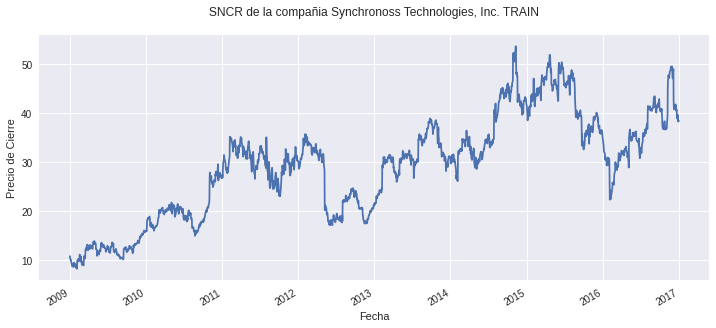

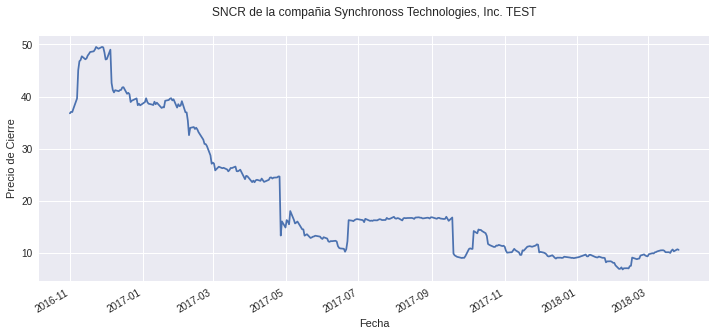

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 1
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [7]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo SNCR de la compañia Synchronoss Technologies, Inc.


In [9]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [27]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1002.9897 - porcentaje_margen: 0.0000e+00 - val_loss: 942.1330 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 762us/step - loss: 1000.4453 - porcentaje_margen: 0.0000e+00 - val_loss: 939.6879 - val_porcentaje_marg

Epoch 88/1500
1314/1314 [==============================] - 1s 695us/step - loss: 801.2452 - porcentaje_margen: 0.0000e+00 - val_loss: 748.5715 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
1314/1314 [==============================] - 1s 682us/step - loss: 799.0977 - porcentaje_margen: 0.0000e+00 - val_loss: 746.5053 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
1314/1314 [==============================] - 1s 696us/step - loss: 796.9552 - porcentaje_margen: 0.0000e+00 - val_loss: 744.4573 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
1314/1314 [==============================] - 1s 826us/step - loss: 794.8208 - porcentaje_margen: 0.0000e+00 - val_loss: 742.4319 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
1314/1314 [==============================] - 1s 724us/step - loss: 792.6799 - porcentaje_margen: 0.0000e+00 - val_loss: 740.3724 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
1314/1314 [==============================] - 1s 782us/step - loss: 790.5489 - porcentaje_ma

1314/1314 [==============================] - 1s 635us/step - loss: 622.3695 - porcentaje_margen: 0.0000e+00 - val_loss: 577.9744 - val_porcentaje_margen: 0.0000e+00
Epoch 179/1500
1314/1314 [==============================] - 1s 690us/step - loss: 620.5245 - porcentaje_margen: 0.0000e+00 - val_loss: 576.2081 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
1314/1314 [==============================] - 1s 633us/step - loss: 618.6827 - porcentaje_margen: 0.0000e+00 - val_loss: 574.4695 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
1314/1314 [==============================] - 1s 613us/step - loss: 616.8571 - porcentaje_margen: 0.0000e+00 - val_loss: 572.7295 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
1314/1314 [==============================] - 1s 638us/step - loss: 615.0281 - porcentaje_margen: 0.0000e+00 - val_loss: 570.9904 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
1314/1314 [==============================] - 1s 680us/step - loss: 613.1940 - porcentaje_margen: 0.0

Epoch 224/1500
1314/1314 [==============================] - 1s 645us/step - loss: 541.5586 - porcentaje_margen: 7.4405e-04 - val_loss: 501.3637 - val_porcentaje_margen: 0.0030
Epoch 225/1500
1314/1314 [==============================] - 1s 600us/step - loss: 539.8763 - porcentaje_margen: 7.4405e-04 - val_loss: 499.7564 - val_porcentaje_margen: 0.0030
Epoch 226/1500
1314/1314 [==============================] - 1s 685us/step - loss: 538.1871 - porcentaje_margen: 7.4405e-04 - val_loss: 498.1712 - val_porcentaje_margen: 0.0030
Epoch 227/1500
1314/1314 [==============================] - 1s 651us/step - loss: 536.5288 - porcentaje_margen: 7.4405e-04 - val_loss: 496.6053 - val_porcentaje_margen: 0.0030
Epoch 228/1500
1314/1314 [==============================] - 1s 655us/step - loss: 534.8703 - porcentaje_margen: 7.4405e-04 - val_loss: 495.0340 - val_porcentaje_margen: 0.0030
Epoch 229/1500
1314/1314 [==============================] - 1s 631us/step - loss: 533.2089 - porcentaje_margen: 7.4405e-

Epoch 319/1500
1314/1314 [==============================] - 1s 658us/step - loss: 397.3558 - porcentaje_margen: 0.0543 - val_loss: 365.7533 - val_porcentaje_margen: 0.0536
Epoch 320/1500
1314/1314 [==============================] - 1s 638us/step - loss: 396.0088 - porcentaje_margen: 0.0417 - val_loss: 364.5220 - val_porcentaje_margen: 0.0506
Epoch 321/1500
1314/1314 [==============================] - 1s 642us/step - loss: 394.6614 - porcentaje_margen: 0.0379 - val_loss: 363.2409 - val_porcentaje_margen: 0.0491
Epoch 322/1500
1314/1314 [==============================] - 1s 645us/step - loss: 393.3143 - porcentaje_margen: 0.0365 - val_loss: 361.9901 - val_porcentaje_margen: 0.0491
Epoch 323/1500
1314/1314 [==============================] - 1s 630us/step - loss: 391.9684 - porcentaje_margen: 0.0357 - val_loss: 360.7448 - val_porcentaje_margen: 0.0491
Epoch 324/1500
1314/1314 [==============================] - 1s 609us/step - loss: 390.6204 - porcentaje_margen: 0.0357 - val_loss: 359.4759 

Epoch 414/1500
1314/1314 [==============================] - 1s 596us/step - loss: 282.9751 - porcentaje_margen: 0.0305 - val_loss: 259.8744 - val_porcentaje_margen: 0.0324
Epoch 415/1500
1314/1314 [==============================] - 1s 635us/step - loss: 281.9439 - porcentaje_margen: 0.0305 - val_loss: 258.9230 - val_porcentaje_margen: 0.0309
Epoch 416/1500
1314/1314 [==============================] - 1s 639us/step - loss: 280.9228 - porcentaje_margen: 0.0312 - val_loss: 257.9892 - val_porcentaje_margen: 0.0339
Epoch 417/1500
1314/1314 [==============================] - 1s 594us/step - loss: 279.8733 - porcentaje_margen: 0.0305 - val_loss: 257.0411 - val_porcentaje_margen: 0.0324
Epoch 418/1500
1314/1314 [==============================] - 1s 628us/step - loss: 278.8497 - porcentaje_margen: 0.0312 - val_loss: 256.0974 - val_porcentaje_margen: 0.0309
Epoch 419/1500
1314/1314 [==============================] - 1s 636us/step - loss: 277.8001 - porcentaje_margen: 0.0320 - val_loss: 255.1311 

Epoch 509/1500
1314/1314 [==============================] - 1s 642us/step - loss: 198.1902 - porcentaje_margen: 0.0647 - val_loss: 183.3698 - val_porcentaje_margen: 0.0670
Epoch 510/1500
1314/1314 [==============================] - 1s 637us/step - loss: 197.4545 - porcentaje_margen: 0.0640 - val_loss: 182.7232 - val_porcentaje_margen: 0.0699
Epoch 511/1500
1314/1314 [==============================] - 1s 625us/step - loss: 196.7164 - porcentaje_margen: 0.0640 - val_loss: 182.0601 - val_porcentaje_margen: 0.0670
Epoch 512/1500
1314/1314 [==============================] - 1s 598us/step - loss: 195.9768 - porcentaje_margen: 0.0625 - val_loss: 181.4155 - val_porcentaje_margen: 0.0670
Epoch 513/1500
1314/1314 [==============================] - 1s 619us/step - loss: 195.2564 - porcentaje_margen: 0.0625 - val_loss: 180.7768 - val_porcentaje_margen: 0.0670
Epoch 514/1500
1314/1314 [==============================] - 1s 593us/step - loss: 194.5292 - porcentaje_margen: 0.0625 - val_loss: 180.1274 

Epoch 604/1500
1314/1314 [==============================] - 1s 627us/step - loss: 141.6905 - porcentaje_margen: 0.0357 - val_loss: 134.8124 - val_porcentaje_margen: 0.0387
Epoch 605/1500
1314/1314 [==============================] - 1s 571us/step - loss: 141.2396 - porcentaje_margen: 0.0342 - val_loss: 134.4370 - val_porcentaje_margen: 0.0387
Epoch 606/1500
1314/1314 [==============================] - 1s 670us/step - loss: 140.7936 - porcentaje_margen: 0.0327 - val_loss: 134.0662 - val_porcentaje_margen: 0.0387
Epoch 607/1500
1314/1314 [==============================] - 1s 641us/step - loss: 140.3610 - porcentaje_margen: 0.0327 - val_loss: 133.7294 - val_porcentaje_margen: 0.0387
Epoch 608/1500
1314/1314 [==============================] - 1s 604us/step - loss: 139.9431 - porcentaje_margen: 0.0432 - val_loss: 133.3897 - val_porcentaje_margen: 0.0387
Epoch 609/1500
1314/1314 [==============================] - 1s 597us/step - loss: 139.5136 - porcentaje_margen: 0.0305 - val_loss: 133.0326 

1314/1314 [==============================] - 1s 653us/step - loss: 111.8091 - porcentaje_margen: 0.0513 - val_loss: 112.0106 - val_porcentaje_margen: 0.0681
Epoch 699/1500
1314/1314 [==============================] - 1s 626us/step - loss: 111.6237 - porcentaje_margen: 0.0513 - val_loss: 111.8989 - val_porcentaje_margen: 0.0681
Epoch 700/1500
1314/1314 [==============================] - 1s 586us/step - loss: 111.4468 - porcentaje_margen: 0.0506 - val_loss: 111.7771 - val_porcentaje_margen: 0.0681
Epoch 701/1500
1314/1314 [==============================] - 1s 595us/step - loss: 111.2576 - porcentaje_margen: 0.0618 - val_loss: 111.6558 - val_porcentaje_margen: 0.0666
Epoch 702/1500
1314/1314 [==============================] - 1s 612us/step - loss: 111.0778 - porcentaje_margen: 0.0506 - val_loss: 111.5416 - val_porcentaje_margen: 0.0681
Epoch 703/1500
1314/1314 [==============================] - 1s 594us/step - loss: 110.8930 - porcentaje_margen: 0.0528 - val_loss: 111.4204 - val_porcentaj

Epoch 746/1500
1314/1314 [==============================] - 1s 646us/step - loss: 105.0318 - porcentaje_margen: 0.0900 - val_loss: 108.2030 - val_porcentaje_margen: 0.0756
Epoch 747/1500
1314/1314 [==============================] - 1s 607us/step - loss: 104.9359 - porcentaje_margen: 0.0789 - val_loss: 108.1629 - val_porcentaje_margen: 0.0741
Epoch 748/1500
1314/1314 [==============================] - 1s 567us/step - loss: 104.8418 - porcentaje_margen: 0.0804 - val_loss: 108.1263 - val_porcentaje_margen: 0.0741
Epoch 749/1500
1314/1314 [==============================] - 1s 578us/step - loss: 104.7442 - porcentaje_margen: 0.0789 - val_loss: 108.0897 - val_porcentaje_margen: 0.0741
Epoch 750/1500
1314/1314 [==============================] - 1s 614us/step - loss: 104.6493 - porcentaje_margen: 0.0804 - val_loss: 108.0523 - val_porcentaje_margen: 0.0771
Epoch 751/1500
1314/1314 [==============================] - 1s 597us/step - loss: 104.5570 - porcentaje_margen: 0.0804 - val_loss: 108.0174 

Epoch 841/1500
1314/1314 [==============================] - 1s 586us/step - loss: 101.4582 - porcentaje_margen: 0.1510 - val_loss: 108.0470 - val_porcentaje_margen: 0.1329
Epoch 842/1500
1314/1314 [==============================] - 1s 588us/step - loss: 101.4511 - porcentaje_margen: 0.1518 - val_loss: 108.0683 - val_porcentaje_margen: 0.1329
Epoch 843/1500
1314/1314 [==============================] - 1s 615us/step - loss: 101.4446 - porcentaje_margen: 0.1518 - val_loss: 108.0729 - val_porcentaje_margen: 0.1329
Epoch 844/1500
1314/1314 [==============================] - 1s 582us/step - loss: 101.4393 - porcentaje_margen: 0.1533 - val_loss: 108.0911 - val_porcentaje_margen: 0.1329
Epoch 845/1500
1314/1314 [==============================] - 1s 665us/step - loss: 101.4284 - porcentaje_margen: 0.1533 - val_loss: 108.1051 - val_porcentaje_margen: 0.1344
Epoch 846/1500
1314/1314 [==============================] - 1s 585us/step - loss: 101.4221 - porcentaje_margen: 0.1533 - val_loss: 108.1147 

Epoch 936/1500
1314/1314 [==============================] - 1s 641us/step - loss: 101.2877 - porcentaje_margen: 0.1682 - val_loss: 108.6538 - val_porcentaje_margen: 0.1553
Epoch 937/1500
1314/1314 [==============================] - 1s 622us/step - loss: 101.2884 - porcentaje_margen: 0.1682 - val_loss: 108.6636 - val_porcentaje_margen: 0.1582
Epoch 938/1500
1314/1314 [==============================] - 1s 697us/step - loss: 101.2873 - porcentaje_margen: 0.1682 - val_loss: 108.6636 - val_porcentaje_margen: 0.1582
Epoch 939/1500
1314/1314 [==============================] - 1s 631us/step - loss: 101.2877 - porcentaje_margen: 0.1793 - val_loss: 108.6674 - val_porcentaje_margen: 0.1582
Epoch 940/1500
1314/1314 [==============================] - 1s 611us/step - loss: 101.2869 - porcentaje_margen: 0.1682 - val_loss: 108.6727 - val_porcentaje_margen: 0.1582
Epoch 941/1500
1314/1314 [==============================] - 1s 591us/step - loss: 101.2861 - porcentaje_margen: 0.1808 - val_loss: 108.6818 

1314/1314 [==============================] - 1s 587us/step - loss: 101.2849 - porcentaje_margen: 0.1741 - val_loss: 108.8564 - val_porcentaje_margen: 0.1597
Epoch 1031/1500
1314/1314 [==============================] - 1s 582us/step - loss: 101.2839 - porcentaje_margen: 0.1741 - val_loss: 108.8500 - val_porcentaje_margen: 0.1597
Epoch 1032/1500
1314/1314 [==============================] - 1s 659us/step - loss: 101.2833 - porcentaje_margen: 0.1734 - val_loss: 108.8341 - val_porcentaje_margen: 0.1597
Epoch 1033/1500
1314/1314 [==============================] - 1s 642us/step - loss: 101.2835 - porcentaje_margen: 0.1734 - val_loss: 108.8299 - val_porcentaje_margen: 0.1597
Epoch 1034/1500
1314/1314 [==============================] - 1s 634us/step - loss: 101.2838 - porcentaje_margen: 0.1734 - val_loss: 108.8280 - val_porcentaje_margen: 0.1597
Epoch 1035/1500
1314/1314 [==============================] - 1s 680us/step - loss: 101.2836 - porcentaje_margen: 0.1734 - val_loss: 108.8298 - val_porc

1314/1314 [==============================] - 1s 619us/step - loss: 101.2829 - porcentaje_margen: 0.1734 - val_loss: 108.8249 - val_porcentaje_margen: 0.1597
Epoch 1125/1500
1314/1314 [==============================] - 1s 584us/step - loss: 101.2836 - porcentaje_margen: 0.1838 - val_loss: 108.8328 - val_porcentaje_margen: 0.1597
Epoch 1126/1500
1314/1314 [==============================] - 1s 625us/step - loss: 101.2840 - porcentaje_margen: 0.1734 - val_loss: 108.8357 - val_porcentaje_margen: 0.1597
Epoch 1127/1500
1314/1314 [==============================] - 1s 628us/step - loss: 101.2847 - porcentaje_margen: 0.1845 - val_loss: 108.8336 - val_porcentaje_margen: 0.1597
Epoch 1128/1500
1314/1314 [==============================] - 1s 612us/step - loss: 101.2834 - porcentaje_margen: 0.1741 - val_loss: 108.8480 - val_porcentaje_margen: 0.1597
Epoch 1129/1500
1314/1314 [==============================] - 1s 597us/step - loss: 101.2837 - porcentaje_margen: 0.1741 - val_loss: 108.8541 - val_porc

1314/1314 [==============================] - 1s 653us/step - loss: 101.2841 - porcentaje_margen: 0.1734 - val_loss: 108.8270 - val_porcentaje_margen: 0.1597
Epoch 1219/1500
1314/1314 [==============================] - 1s 652us/step - loss: 101.2834 - porcentaje_margen: 0.1734 - val_loss: 108.8330 - val_porcentaje_margen: 0.1597
Epoch 1220/1500
1314/1314 [==============================] - 1s 645us/step - loss: 101.2832 - porcentaje_margen: 0.1845 - val_loss: 108.8258 - val_porcentaje_margen: 0.1597
Epoch 1221/1500
1314/1314 [==============================] - 1s 666us/step - loss: 101.2834 - porcentaje_margen: 0.1726 - val_loss: 108.8274 - val_porcentaje_margen: 0.1597
Epoch 1222/1500
1314/1314 [==============================] - 1s 573us/step - loss: 101.2836 - porcentaje_margen: 0.1734 - val_loss: 108.8284 - val_porcentaje_margen: 0.1597
Epoch 1223/1500
1314/1314 [==============================] - 1s 621us/step - loss: 101.2829 - porcentaje_margen: 0.1734 - val_loss: 108.8373 - val_porc

1314/1314 [==============================] - 1s 594us/step - loss: 101.2859 - porcentaje_margen: 0.1726 - val_loss: 108.8076 - val_porcentaje_margen: 0.1597
Epoch 1313/1500
1314/1314 [==============================] - 1s 628us/step - loss: 101.2837 - porcentaje_margen: 0.1719 - val_loss: 108.7980 - val_porcentaje_margen: 0.1582
Epoch 1314/1500
1314/1314 [==============================] - 1s 569us/step - loss: 101.2839 - porcentaje_margen: 0.1823 - val_loss: 108.7970 - val_porcentaje_margen: 0.1582
Epoch 1315/1500
1314/1314 [==============================] - 1s 599us/step - loss: 101.2832 - porcentaje_margen: 0.1711 - val_loss: 108.7939 - val_porcentaje_margen: 0.1582
Epoch 1316/1500
1314/1314 [==============================] - 1s 616us/step - loss: 101.2832 - porcentaje_margen: 0.1711 - val_loss: 108.8027 - val_porcentaje_margen: 0.1582
Epoch 1317/1500
1314/1314 [==============================] - 1s 622us/step - loss: 101.2838 - porcentaje_margen: 0.1726 - val_loss: 108.8149 - val_porc

1314/1314 [==============================] - 1s 568us/step - loss: 101.2832 - porcentaje_margen: 0.1845 - val_loss: 108.8315 - val_porcentaje_margen: 0.1597
Epoch 1407/1500
1314/1314 [==============================] - 1s 607us/step - loss: 101.2842 - porcentaje_margen: 0.1845 - val_loss: 108.8317 - val_porcentaje_margen: 0.1597
Epoch 1408/1500
1314/1314 [==============================] - 1s 570us/step - loss: 101.2859 - porcentaje_margen: 0.1734 - val_loss: 108.8310 - val_porcentaje_margen: 0.1597
Epoch 1409/1500
1314/1314 [==============================] - 1s 610us/step - loss: 101.2836 - porcentaje_margen: 0.1845 - val_loss: 108.8342 - val_porcentaje_margen: 0.1597
Epoch 1410/1500
1314/1314 [==============================] - 1s 569us/step - loss: 101.2832 - porcentaje_margen: 0.1845 - val_loss: 108.8307 - val_porcentaje_margen: 0.1597
Epoch 1411/1500
1314/1314 [==============================] - 1s 580us/step - loss: 101.2846 - porcentaje_margen: 0.1734 - val_loss: 108.8320 - val_porc

1314/1314 [==============================] - 1s 580us/step - loss: 101.2842 - porcentaje_margen: 0.1726 - val_loss: 108.8244 - val_porcentaje_margen: 0.1597


In [10]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 25ms/step - loss: 987.7457 - porcentaje_margen: 0.0000e+00 - val_loss: 965.8576 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 17ms/step - loss: 955.6379 - porcentaje_margen: 0.0000e+00 - val_loss: 927.9213 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [======================

Epoch 47/1500
42/42 [==============================] - 1s 15ms/step - loss: 6.4074 - porcentaje_margen: 0.4643 - val_loss: 6.4735 - val_porcentaje_margen: 0.4517
Epoch 48/1500
42/42 [==============================] - 1s 15ms/step - loss: 6.2343 - porcentaje_margen: 0.4836 - val_loss: 6.3792 - val_porcentaje_margen: 0.4696
Epoch 49/1500
42/42 [==============================] - 1s 17ms/step - loss: 6.0932 - porcentaje_margen: 0.4903 - val_loss: 6.5807 - val_porcentaje_margen: 0.4286
Epoch 50/1500
42/42 [==============================] - 1s 18ms/step - loss: 6.0722 - porcentaje_margen: 0.4799 - val_loss: 7.2507 - val_porcentaje_margen: 0.4234
Epoch 51/1500
42/42 [==============================] - 1s 17ms/step - loss: 6.1484 - porcentaje_margen: 0.4576 - val_loss: 6.2257 - val_porcentaje_margen: 0.4390
Epoch 52/1500
42/42 [==============================] - 1s 17ms/step - loss: 6.0930 - porcentaje_margen: 0.4524 - val_loss: 6.4738 - val_porcentaje_margen: 0.4747
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 17ms/step - loss: 4.5089 - porcentaje_margen: 0.5707 - val_loss: 4.8086 - val_porcentaje_margen: 0.5494
Epoch 98/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.5817 - porcentaje_margen: 0.5699 - val_loss: 6.2657 - val_porcentaje_margen: 0.4859
Epoch 99/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.8593 - porcentaje_margen: 0.5469 - val_loss: 4.8494 - val_porcentaje_margen: 0.5584
Epoch 100/1500
42/42 [==============================] - 1s 17ms/step - loss: 5.0886 - porcentaje_margen: 0.5424 - val_loss: 5.0147 - val_porcentaje_margen: 0.5440
Epoch 101/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.8633 - porcentaje_margen: 0.5439 - val_loss: 5.2296 - val_porcentaje_margen: 0.5339
Epoch 102/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.6942 - porcentaje_margen: 0.5513 - val_loss: 6.3934 - val_porcentaje_margen: 0.4711
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 18ms/step - loss: 3.8135 - porcentaje_margen: 0.6183 - val_loss: 3.9240 - val_porcentaje_margen: 0.6098
Epoch 148/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.7370 - porcentaje_margen: 0.6153 - val_loss: 3.9914 - val_porcentaje_margen: 0.6109
Epoch 149/1500
42/42 [==============================] - 1s 14ms/step - loss: 3.7726 - porcentaje_margen: 0.6094 - val_loss: 3.8839 - val_porcentaje_margen: 0.6190
Epoch 150/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.8744 - porcentaje_margen: 0.6079 - val_loss: 4.0951 - val_porcentaje_margen: 0.5985
Epoch 151/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.2543 - porcentaje_margen: 0.5536 - val_loss: 3.9489 - val_porcentaje_margen: 0.6065
Epoch 152/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.8178 - porcentaje_margen: 0.5915 - val_loss: 4.0902 - val_porcentaje_margen: 0.5997
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 3.5396 - porcentaje_margen: 0.6302 - val_loss: 4.7803 - val_porcentaje_margen: 0.5369
Epoch 198/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.4059 - porcentaje_margen: 0.6644 - val_loss: 3.3887 - val_porcentaje_margen: 0.6642
Epoch 199/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.2485 - porcentaje_margen: 0.6570 - val_loss: 3.3755 - val_porcentaje_margen: 0.6567
Epoch 200/1500
42/42 [==============================] - 1s 15ms/step - loss: 3.3540 - porcentaje_margen: 0.6562 - val_loss: 3.6094 - val_porcentaje_margen: 0.6329
Epoch 201/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.4254 - porcentaje_margen: 0.6362 - val_loss: 3.8811 - val_porcentaje_margen: 0.5961
Epoch 202/1500
42/42 [==============================] - 1s 15ms/step - loss: 3.4243 - porcentaje_margen: 0.6406 - val_loss: 3.3232 - val_porcentaje_margen: 0.6597
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 3.2608 - porcentaje_margen: 0.6838 - val_loss: 3.3225 - val_porcentaje_margen: 0.6806
Epoch 248/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.3978 - porcentaje_margen: 0.6622 - val_loss: 3.4240 - val_porcentaje_margen: 0.6582
Epoch 249/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.1723 - porcentaje_margen: 0.6763 - val_loss: 3.3151 - val_porcentaje_margen: 0.6749
Epoch 250/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.3362 - porcentaje_margen: 0.6414 - val_loss: 3.2613 - val_porcentaje_margen: 0.6716
Epoch 251/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.3002 - porcentaje_margen: 0.6600 - val_loss: 3.2473 - val_porcentaje_margen: 0.6820
Epoch 252/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.3382 - porcentaje_margen: 0.6518 - val_loss: 3.2393 - val_porcentaje_margen: 0.6809
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 2.9502 - porcentaje_margen: 0.6808 - val_loss: 3.0261 - val_porcentaje_margen: 0.7085
Epoch 298/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.9571 - porcentaje_margen: 0.6711 - val_loss: 3.2027 - val_porcentaje_margen: 0.6594
Epoch 299/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.0275 - porcentaje_margen: 0.6838 - val_loss: 3.0268 - val_porcentaje_margen: 0.6996
Epoch 300/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.8943 - porcentaje_margen: 0.6920 - val_loss: 3.0129 - val_porcentaje_margen: 0.7040
Epoch 301/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.9562 - porcentaje_margen: 0.6801 - val_loss: 3.0046 - val_porcentaje_margen: 0.7040
Epoch 302/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.1873 - porcentaje_margen: 0.6719 - val_loss: 3.0131 - val_porcentaje_margen: 0.7067
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.8363 - porcentaje_margen: 0.6815 - val_loss: 3.3834 - val_porcentaje_margen: 0.6574
Epoch 348/1500
42/42 [==============================] - 1s 14ms/step - loss: 3.3567 - porcentaje_margen: 0.6310 - val_loss: 2.9092 - val_porcentaje_margen: 0.6973
Epoch 349/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.0160 - porcentaje_margen: 0.6778 - val_loss: 3.2252 - val_porcentaje_margen: 0.6705
Epoch 350/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.8711 - porcentaje_margen: 0.6786 - val_loss: 2.8860 - val_porcentaje_margen: 0.7115
Epoch 351/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.7702 - porcentaje_margen: 0.6972 - val_loss: 2.8756 - val_porcentaje_margen: 0.7171
Epoch 352/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.7570 - porcentaje_margen: 0.6845 - val_loss: 2.9147 - val_porcentaje_margen: 0.6996
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.7608 - porcentaje_margen: 0.6920 - val_loss: 2.8168 - val_porcentaje_margen: 0.7082
Epoch 398/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.6604 - porcentaje_margen: 0.7076 - val_loss: 2.8241 - val_porcentaje_margen: 0.7141
Epoch 399/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.6722 - porcentaje_margen: 0.6920 - val_loss: 2.8625 - val_porcentaje_margen: 0.6992
Epoch 400/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.7340 - porcentaje_margen: 0.6890 - val_loss: 2.8165 - val_porcentaje_margen: 0.7100
Epoch 401/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.6914 - porcentaje_margen: 0.7039 - val_loss: 3.8842 - val_porcentaje_margen: 0.6184
Epoch 402/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.9328 - porcentaje_margen: 0.6793 - val_loss: 2.7982 - val_porcentaje_margen: 0.7153
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 3.0555 - porcentaje_margen: 0.6562 - val_loss: 3.5935 - val_porcentaje_margen: 0.6023
Epoch 448/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.8420 - porcentaje_margen: 0.6659 - val_loss: 2.9575 - val_porcentaje_margen: 0.6969
Epoch 449/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.6367 - porcentaje_margen: 0.7173 - val_loss: 2.7276 - val_porcentaje_margen: 0.7171
Epoch 450/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.6396 - porcentaje_margen: 0.6935 - val_loss: 2.8912 - val_porcentaje_margen: 0.6939
Epoch 451/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.8343 - porcentaje_margen: 0.6682 - val_loss: 2.7370 - val_porcentaje_margen: 0.7189
Epoch 452/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.6272 - porcentaje_margen: 0.6927 - val_loss: 2.7251 - val_porcentaje_margen: 0.7201
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 21ms/step - loss: 2.6602 - porcentaje_margen: 0.6942 - val_loss: 2.8031 - val_porcentaje_margen: 0.7156
Epoch 498/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.5674 - porcentaje_margen: 0.7046 - val_loss: 2.8144 - val_porcentaje_margen: 0.7159
Epoch 499/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.6651 - porcentaje_margen: 0.6905 - val_loss: 3.0721 - val_porcentaje_margen: 0.6716
Epoch 500/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.8004 - porcentaje_margen: 0.6815 - val_loss: 3.2558 - val_porcentaje_margen: 0.6526
Epoch 501/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.7637 - porcentaje_margen: 0.6853 - val_loss: 2.8787 - val_porcentaje_margen: 0.7044
Epoch 502/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.6346 - porcentaje_margen: 0.7098 - val_loss: 2.7705 - val_porcentaje_margen: 0.6992
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.6492 - porcentaje_margen: 0.6845 - val_loss: 2.6210 - val_porcentaje_margen: 0.7171
Epoch 548/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.7517 - porcentaje_margen: 0.6607 - val_loss: 2.6387 - val_porcentaje_margen: 0.7302
Epoch 549/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.4734 - porcentaje_margen: 0.7210 - val_loss: 2.9846 - val_porcentaje_margen: 0.7082
Epoch 550/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.5213 - porcentaje_margen: 0.7202 - val_loss: 2.5786 - val_porcentaje_margen: 0.7305
Epoch 551/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.4962 - porcentaje_margen: 0.7232 - val_loss: 3.0426 - val_porcentaje_margen: 0.7011
Epoch 552/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.6670 - porcentaje_margen: 0.7016 - val_loss: 3.0598 - val_porcentaje_margen: 0.6984
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 2.3939 - porcentaje_margen: 0.7091 - val_loss: 3.3064 - val_porcentaje_margen: 0.6533
Epoch 598/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.5484 - porcentaje_margen: 0.7150 - val_loss: 3.0574 - val_porcentaje_margen: 0.6999
Epoch 599/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.4123 - porcentaje_margen: 0.7098 - val_loss: 2.5363 - val_porcentaje_margen: 0.7379
Epoch 600/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.4817 - porcentaje_margen: 0.7128 - val_loss: 2.5390 - val_porcentaje_margen: 0.7379
Epoch 601/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.3890 - porcentaje_margen: 0.7344 - val_loss: 2.5373 - val_porcentaje_margen: 0.7383
Epoch 602/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.3735 - porcentaje_margen: 0.7284 - val_loss: 2.5255 - val_porcentaje_margen: 0.7379
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.4298 - porcentaje_margen: 0.7165 - val_loss: 2.4673 - val_porcentaje_margen: 0.7498
Epoch 648/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.3732 - porcentaje_margen: 0.7247 - val_loss: 2.4931 - val_porcentaje_margen: 0.7371
Epoch 649/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.3556 - porcentaje_margen: 0.7321 - val_loss: 2.4346 - val_porcentaje_margen: 0.7513
Epoch 650/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.3422 - porcentaje_margen: 0.7307 - val_loss: 2.4557 - val_porcentaje_margen: 0.7498
Epoch 651/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.2861 - porcentaje_margen: 0.7262 - val_loss: 2.6291 - val_porcentaje_margen: 0.7305
Epoch 652/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.3811 - porcentaje_margen: 0.7366 - val_loss: 2.5118 - val_porcentaje_margen: 0.7454
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 2.2850 - porcentaje_margen: 0.7336 - val_loss: 2.6238 - val_porcentaje_margen: 0.7255
Epoch 698/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.3935 - porcentaje_margen: 0.7329 - val_loss: 2.4232 - val_porcentaje_margen: 0.7546
Epoch 699/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.3055 - porcentaje_margen: 0.7433 - val_loss: 2.4145 - val_porcentaje_margen: 0.7584
Epoch 700/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.2768 - porcentaje_margen: 0.7269 - val_loss: 2.6005 - val_porcentaje_margen: 0.7383
Epoch 701/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.3852 - porcentaje_margen: 0.7225 - val_loss: 2.6028 - val_porcentaje_margen: 0.7335
Epoch 702/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.2593 - porcentaje_margen: 0.7351 - val_loss: 3.0579 - val_porcentaje_margen: 0.6806
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 2.2255 - porcentaje_margen: 0.7321 - val_loss: 2.6241 - val_porcentaje_margen: 0.7421
Epoch 748/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.3216 - porcentaje_margen: 0.7359 - val_loss: 2.3447 - val_porcentaje_margen: 0.7502
Epoch 749/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.2051 - porcentaje_margen: 0.7463 - val_loss: 2.5144 - val_porcentaje_margen: 0.7469
Epoch 750/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.2090 - porcentaje_margen: 0.7455 - val_loss: 2.4763 - val_porcentaje_margen: 0.7353
Epoch 751/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.2618 - porcentaje_margen: 0.7463 - val_loss: 2.3670 - val_porcentaje_margen: 0.7688
Epoch 752/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.2857 - porcentaje_margen: 0.7202 - val_loss: 2.3924 - val_porcentaje_margen: 0.7513
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.5582 - porcentaje_margen: 0.7068 - val_loss: 2.5561 - val_porcentaje_margen: 0.7320
Epoch 798/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.3420 - porcentaje_margen: 0.7403 - val_loss: 2.4684 - val_porcentaje_margen: 0.7543
Epoch 799/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.2118 - porcentaje_margen: 0.7396 - val_loss: 3.0124 - val_porcentaje_margen: 0.6711
Epoch 800/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.4531 - porcentaje_margen: 0.7024 - val_loss: 2.3628 - val_porcentaje_margen: 0.7503
Epoch 801/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.1774 - porcentaje_margen: 0.7507 - val_loss: 2.3356 - val_porcentaje_margen: 0.7629
Epoch 802/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1897 - porcentaje_margen: 0.7440 - val_loss: 2.3459 - val_porcentaje_margen: 0.7641
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 2.1770 - porcentaje_margen: 0.7433 - val_loss: 2.3138 - val_porcentaje_margen: 0.7771
Epoch 848/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1385 - porcentaje_margen: 0.7500 - val_loss: 2.4619 - val_porcentaje_margen: 0.7439
Epoch 849/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.5263 - porcentaje_margen: 0.6942 - val_loss: 2.3054 - val_porcentaje_margen: 0.7760
Epoch 850/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1698 - porcentaje_margen: 0.7619 - val_loss: 2.3035 - val_porcentaje_margen: 0.7715
Epoch 851/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1053 - porcentaje_margen: 0.7597 - val_loss: 2.2922 - val_porcentaje_margen: 0.7644
Epoch 852/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1601 - porcentaje_margen: 0.7359 - val_loss: 2.4351 - val_porcentaje_margen: 0.7457
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.0749 - porcentaje_margen: 0.7493 - val_loss: 2.7198 - val_porcentaje_margen: 0.6992
Epoch 898/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.3702 - porcentaje_margen: 0.7262 - val_loss: 2.3527 - val_porcentaje_margen: 0.7450
Epoch 899/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1836 - porcentaje_margen: 0.7426 - val_loss: 2.2996 - val_porcentaje_margen: 0.7614
Epoch 900/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1000 - porcentaje_margen: 0.7455 - val_loss: 2.4841 - val_porcentaje_margen: 0.7383
Epoch 901/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1700 - porcentaje_margen: 0.7448 - val_loss: 2.3256 - val_porcentaje_margen: 0.7436
Epoch 902/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.2661 - porcentaje_margen: 0.7440 - val_loss: 2.2954 - val_porcentaje_margen: 0.7659
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 19ms/step - loss: 2.1243 - porcentaje_margen: 0.7470 - val_loss: 2.4422 - val_porcentaje_margen: 0.7510
Epoch 948/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1613 - porcentaje_margen: 0.7604 - val_loss: 2.2720 - val_porcentaje_margen: 0.7771
Epoch 949/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.0734 - porcentaje_margen: 0.7507 - val_loss: 2.2988 - val_porcentaje_margen: 0.7487
Epoch 950/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1552 - porcentaje_margen: 0.7418 - val_loss: 2.4740 - val_porcentaje_margen: 0.7244
Epoch 951/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.3084 - porcentaje_margen: 0.7478 - val_loss: 2.2668 - val_porcentaje_margen: 0.7667
Epoch 952/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.0700 - porcentaje_margen: 0.7530 - val_loss: 2.5206 - val_porcentaje_margen: 0.7386
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 2.0763 - porcentaje_margen: 0.7374 - val_loss: 2.8602 - val_porcentaje_margen: 0.6784
Epoch 998/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.5676 - porcentaje_margen: 0.7143 - val_loss: 2.3351 - val_porcentaje_margen: 0.7584
Epoch 999/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0668 - porcentaje_margen: 0.7440 - val_loss: 2.2680 - val_porcentaje_margen: 0.7558
Epoch 1000/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.1564 - porcentaje_margen: 0.7493 - val_loss: 2.3201 - val_porcentaje_margen: 0.7647
Epoch 1001/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0568 - porcentaje_margen: 0.7604 - val_loss: 2.3078 - val_porcentaje_margen: 0.7588
Epoch 1002/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1325 - porcentaje_margen: 0.7530 - val_loss: 2.3356 - val_porcentaje_margen: 0.7483
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 16ms/step - loss: 2.0578 - porcentaje_margen: 0.7418 - val_loss: 2.5052 - val_porcentaje_margen: 0.7226
Epoch 1048/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.2570 - porcentaje_margen: 0.7344 - val_loss: 2.4656 - val_porcentaje_margen: 0.7300
Epoch 1049/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1575 - porcentaje_margen: 0.7522 - val_loss: 2.2826 - val_porcentaje_margen: 0.7412
Epoch 1050/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0555 - porcentaje_margen: 0.7493 - val_loss: 2.4584 - val_porcentaje_margen: 0.7363
Epoch 1051/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.1326 - porcentaje_margen: 0.7522 - val_loss: 2.3656 - val_porcentaje_margen: 0.7389
Epoch 1052/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0865 - porcentaje_margen: 0.7470 - val_loss: 2.4851 - val_porcentaje_margen: 0.7353
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 2.0167 - porcentaje_margen: 0.7597 - val_loss: 2.2538 - val_porcentaje_margen: 0.7543
Epoch 1098/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0297 - porcentaje_margen: 0.7455 - val_loss: 2.2543 - val_porcentaje_margen: 0.7688
Epoch 1099/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0921 - porcentaje_margen: 0.7537 - val_loss: 2.2466 - val_porcentaje_margen: 0.7588
Epoch 1100/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.1411 - porcentaje_margen: 0.7552 - val_loss: 2.4334 - val_porcentaje_margen: 0.7292
Epoch 1101/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0898 - porcentaje_margen: 0.7478 - val_loss: 2.4964 - val_porcentaje_margen: 0.7364
Epoch 1102/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1281 - porcentaje_margen: 0.7418 - val_loss: 2.4396 - val_porcentaje_margen: 0.7573
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 15ms/step - loss: 2.0946 - porcentaje_margen: 0.7470 - val_loss: 2.2796 - val_porcentaje_margen: 0.7505
Epoch 1148/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0539 - porcentaje_margen: 0.7634 - val_loss: 2.2443 - val_porcentaje_margen: 0.7457
Epoch 1149/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0413 - porcentaje_margen: 0.7574 - val_loss: 2.2472 - val_porcentaje_margen: 0.7659
Epoch 1150/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.0235 - porcentaje_margen: 0.7500 - val_loss: 2.2813 - val_porcentaje_margen: 0.7543
Epoch 1151/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0288 - porcentaje_margen: 0.7552 - val_loss: 2.2337 - val_porcentaje_margen: 0.7647
Epoch 1152/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0245 - porcentaje_margen: 0.7515 - val_loss: 2.2589 - val_porcentaje_margen: 0.7442
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 2.0660 - porcentaje_margen: 0.7411 - val_loss: 2.2088 - val_porcentaje_margen: 0.7573
Epoch 1198/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0943 - porcentaje_margen: 0.7515 - val_loss: 2.2674 - val_porcentaje_margen: 0.7487
Epoch 1199/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0209 - porcentaje_margen: 0.7626 - val_loss: 2.2859 - val_porcentaje_margen: 0.7667
Epoch 1200/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0767 - porcentaje_margen: 0.7634 - val_loss: 2.3439 - val_porcentaje_margen: 0.7389
Epoch 1201/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0014 - porcentaje_margen: 0.7597 - val_loss: 2.3498 - val_porcentaje_margen: 0.7434
Epoch 1202/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0886 - porcentaje_margen: 0.7485 - val_loss: 2.2962 - val_porcentaje_margen: 0.7404
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 17ms/step - loss: 2.1074 - porcentaje_margen: 0.7597 - val_loss: 2.1915 - val_porcentaje_margen: 0.7588
Epoch 1248/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.9977 - porcentaje_margen: 0.7560 - val_loss: 2.2558 - val_porcentaje_margen: 0.7502
Epoch 1249/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0895 - porcentaje_margen: 0.7545 - val_loss: 2.2151 - val_porcentaje_margen: 0.7629
Epoch 1250/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1987 - porcentaje_margen: 0.7463 - val_loss: 2.2662 - val_porcentaje_margen: 0.7581
Epoch 1251/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.0031 - porcentaje_margen: 0.7619 - val_loss: 2.2740 - val_porcentaje_margen: 0.7520
Epoch 1252/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0413 - porcentaje_margen: 0.7708 - val_loss: 2.2125 - val_porcentaje_margen: 0.7573
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 2.7797 - porcentaje_margen: 0.6882 - val_loss: 2.2649 - val_porcentaje_margen: 0.7540
Epoch 1298/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0118 - porcentaje_margen: 0.7522 - val_loss: 2.2671 - val_porcentaje_margen: 0.7611
Epoch 1299/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0172 - porcentaje_margen: 0.7679 - val_loss: 2.1974 - val_porcentaje_margen: 0.7647
Epoch 1300/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9745 - porcentaje_margen: 0.7664 - val_loss: 2.2597 - val_porcentaje_margen: 0.7710
Epoch 1301/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0432 - porcentaje_margen: 0.7664 - val_loss: 2.4555 - val_porcentaje_margen: 0.7333
Epoch 1302/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9889 - porcentaje_margen: 0.7686 - val_loss: 2.2493 - val_porcentaje_margen: 0.7647
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 15ms/step - loss: 2.1833 - porcentaje_margen: 0.7247 - val_loss: 2.6969 - val_porcentaje_margen: 0.7188
Epoch 1348/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0845 - porcentaje_margen: 0.7403 - val_loss: 2.2994 - val_porcentaje_margen: 0.7543
Epoch 1349/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0855 - porcentaje_margen: 0.7374 - val_loss: 2.3271 - val_porcentaje_margen: 0.7573
Epoch 1350/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0305 - porcentaje_margen: 0.7485 - val_loss: 2.2680 - val_porcentaje_margen: 0.7591
Epoch 1351/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0132 - porcentaje_margen: 0.7626 - val_loss: 2.2487 - val_porcentaje_margen: 0.7606
Epoch 1352/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0193 - porcentaje_margen: 0.7507 - val_loss: 2.2978 - val_porcentaje_margen: 0.7641
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 2.0136 - porcentaje_margen: 0.7403 - val_loss: 2.2237 - val_porcentaje_margen: 0.7733
Epoch 1398/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.0029 - porcentaje_margen: 0.7656 - val_loss: 2.3086 - val_porcentaje_margen: 0.7517
Epoch 1399/1500
42/42 [==============================] - 1s 13ms/step - loss: 2.0439 - porcentaje_margen: 0.7359 - val_loss: 2.5364 - val_porcentaje_margen: 0.7214
Epoch 1400/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0776 - porcentaje_margen: 0.7500 - val_loss: 2.2250 - val_porcentaje_margen: 0.7636
Epoch 1401/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0154 - porcentaje_margen: 0.7448 - val_loss: 2.2818 - val_porcentaje_margen: 0.7490
Epoch 1402/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0634 - porcentaje_margen: 0.7626 - val_loss: 2.3097 - val_porcentaje_margen: 0.7505
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 16ms/step - loss: 2.0358 - porcentaje_margen: 0.7619 - val_loss: 2.3374 - val_porcentaje_margen: 0.7538
Epoch 1448/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0503 - porcentaje_margen: 0.7619 - val_loss: 2.2742 - val_porcentaje_margen: 0.7659
Epoch 1449/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0553 - porcentaje_margen: 0.7582 - val_loss: 2.2117 - val_porcentaje_margen: 0.7636
Epoch 1450/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0446 - porcentaje_margen: 0.7522 - val_loss: 2.2381 - val_porcentaje_margen: 0.7730
Epoch 1451/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0386 - porcentaje_margen: 0.7671 - val_loss: 2.2433 - val_porcentaje_margen: 0.7688
Epoch 1452/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0537 - porcentaje_margen: 0.7411 - val_loss: 2.4460 - val_porcentaje_margen: 0.7333
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 2.0925 - porcentaje_margen: 0.7478 - val_loss: 2.2326 - val_porcentaje_margen: 0.7546
Epoch 1498/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9658 - porcentaje_margen: 0.7582 - val_loss: 2.2541 - val_porcentaje_margen: 0.7718
Epoch 1499/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.1575 - porcentaje_margen: 0.7545 - val_loss: 2.6523 - val_porcentaje_margen: 0.7158
Epoch 1500/1500
42/42 [==============================] - 1s 14ms/step - loss: 1.9883 - porcentaje_margen: 0.7760 - val_loss: 2.2897 - val_porcentaje_margen: 0.7789


In [11]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 21ms/step - loss: 996.4544 - porcentaje_margen: 0.0000e+00 - val_loss: 981.2210 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 17ms/step - loss: 981.8467 - porcentaje_margen: 0.0000e+00 - val_loss: 972.2715 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 1s 18ms/step - loss: 9.1831 - porcentaje_margen: 0.4077 - val_loss: 9.0776 - val_porcentaje_margen: 0.4015
Epoch 47/1500
42/42 [==============================] - 1s 16ms/step - loss: 9.3859 - porcentaje_margen: 0.3854 - val_loss: 9.0894 - val_porcentaje_margen: 0.4196
Epoch 48/1500
42/42 [==============================] - 1s 16ms/step - loss: 9.3696 - porcentaje_margen: 0.3973 - val_loss: 8.9091 - val_porcentaje_margen: 0.3988
Epoch 49/1500
42/42 [==============================] - 1s 17ms/step - loss: 9.2374 - porcentaje_margen: 0.3817 - val_loss: 9.2618 - val_porcentaje_margen: 0.4170
Epoch 50/1500
42/42 [==============================] - 1s 17ms/step - loss: 9.0592 - porcentaje_margen: 0.4077 - val_loss: 9.0582 - val_porcentaje_margen: 0.3985
Epoch 51/1500
42/42 [==============================] - 1s 15ms/step - loss: 8.8534 - porcentaje_margen: 0.3996 - val_loss: 11.7706 - val_porcentaje_margen: 0.3763
Epoch 52/1500
42/42 [====================

42/42 [==============================] - 1s 19ms/step - loss: 7.5435 - porcentaje_margen: 0.4405 - val_loss: 7.9374 - val_porcentaje_margen: 0.4286
Epoch 97/1500
42/42 [==============================] - 1s 16ms/step - loss: 6.9929 - porcentaje_margen: 0.4479 - val_loss: 7.3321 - val_porcentaje_margen: 0.4274
Epoch 98/1500
42/42 [==============================] - 1s 16ms/step - loss: 7.2479 - porcentaje_margen: 0.4702 - val_loss: 7.3083 - val_porcentaje_margen: 0.4349
Epoch 99/1500
42/42 [==============================] - 1s 19ms/step - loss: 7.5461 - porcentaje_margen: 0.4509 - val_loss: 7.1145 - val_porcentaje_margen: 0.4408
Epoch 100/1500
42/42 [==============================] - 1s 17ms/step - loss: 6.6731 - porcentaje_margen: 0.4539 - val_loss: 11.6843 - val_porcentaje_margen: 0.3216
Epoch 101/1500
42/42 [==============================] - 1s 17ms/step - loss: 7.4268 - porcentaje_margen: 0.4464 - val_loss: 7.9211 - val_porcentaje_margen: 0.4069
Epoch 102/1500
42/42 [=================

42/42 [==============================] - 1s 16ms/step - loss: 4.8470 - porcentaje_margen: 0.5499 - val_loss: 4.6357 - val_porcentaje_margen: 0.5774
Epoch 147/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.7677 - porcentaje_margen: 0.5424 - val_loss: 4.9147 - val_porcentaje_margen: 0.5521
Epoch 148/1500
42/42 [==============================] - 1s 15ms/step - loss: 4.3881 - porcentaje_margen: 0.5781 - val_loss: 4.8806 - val_porcentaje_margen: 0.5536
Epoch 149/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.3082 - porcentaje_margen: 0.5655 - val_loss: 4.4954 - val_porcentaje_margen: 0.5774
Epoch 150/1500
42/42 [==============================] - 1s 15ms/step - loss: 4.7314 - porcentaje_margen: 0.5565 - val_loss: 5.4004 - val_porcentaje_margen: 0.5182
Epoch 151/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.2350 - porcentaje_margen: 0.5625 - val_loss: 4.3820 - val_porcentaje_margen: 0.6068
Epoch 152/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 3.7240 - porcentaje_margen: 0.6228 - val_loss: 4.1074 - val_porcentaje_margen: 0.6080
Epoch 197/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.5909 - porcentaje_margen: 0.6168 - val_loss: 3.8164 - val_porcentaje_margen: 0.6381
Epoch 198/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.6884 - porcentaje_margen: 0.6280 - val_loss: 4.3820 - val_porcentaje_margen: 0.5904
Epoch 199/1500
42/42 [==============================] - 1s 17ms/step - loss: 4.1252 - porcentaje_margen: 0.5722 - val_loss: 4.0954 - val_porcentaje_margen: 0.6131
Epoch 200/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.9425 - porcentaje_margen: 0.5729 - val_loss: 6.2964 - val_porcentaje_margen: 0.4560
Epoch 201/1500
42/42 [==============================] - 1s 16ms/step - loss: 4.0160 - porcentaje_margen: 0.5856 - val_loss: 4.0236 - val_porcentaje_margen: 0.6080
Epoch 202/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 3.7249 - porcentaje_margen: 0.6161 - val_loss: 6.0311 - val_porcentaje_margen: 0.4086
Epoch 247/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.8736 - porcentaje_margen: 0.5885 - val_loss: 3.7876 - val_porcentaje_margen: 0.6427
Epoch 248/1500
42/42 [==============================] - 1s 20ms/step - loss: 3.4387 - porcentaje_margen: 0.6362 - val_loss: 3.4349 - val_porcentaje_margen: 0.6624
Epoch 249/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.4304 - porcentaje_margen: 0.6429 - val_loss: 3.6732 - val_porcentaje_margen: 0.6422
Epoch 250/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.2412 - porcentaje_margen: 0.6518 - val_loss: 6.1281 - val_porcentaje_margen: 0.4516
Epoch 251/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.8597 - porcentaje_margen: 0.5908 - val_loss: 4.0648 - val_porcentaje_margen: 0.6128
Epoch 252/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 3.2349 - porcentaje_margen: 0.6503 - val_loss: 4.0078 - val_porcentaje_margen: 0.6116
Epoch 297/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.1578 - porcentaje_margen: 0.6525 - val_loss: 3.5003 - val_porcentaje_margen: 0.6620
Epoch 298/1500
42/42 [==============================] - 1s 19ms/step - loss: 3.4980 - porcentaje_margen: 0.6354 - val_loss: 3.4040 - val_porcentaje_margen: 0.6746
Epoch 299/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.4366 - porcentaje_margen: 0.6287 - val_loss: 3.2615 - val_porcentaje_margen: 0.6787
Epoch 300/1500
42/42 [==============================] - 1s 15ms/step - loss: 3.0889 - porcentaje_margen: 0.6577 - val_loss: 3.4104 - val_porcentaje_margen: 0.6653
Epoch 301/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.2017 - porcentaje_margen: 0.6719 - val_loss: 3.2379 - val_porcentaje_margen: 0.6820
Epoch 302/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 3.1411 - porcentaje_margen: 0.6659 - val_loss: 3.4210 - val_porcentaje_margen: 0.6442
Epoch 347/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.1296 - porcentaje_margen: 0.6786 - val_loss: 3.9163 - val_porcentaje_margen: 0.5969
Epoch 348/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.9465 - porcentaje_margen: 0.6458 - val_loss: 3.2256 - val_porcentaje_margen: 0.6799
Epoch 349/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.9961 - porcentaje_margen: 0.6704 - val_loss: 4.3264 - val_porcentaje_margen: 0.5466
Epoch 350/1500
42/42 [==============================] - 1s 18ms/step - loss: 3.0187 - porcentaje_margen: 0.6726 - val_loss: 3.0097 - val_porcentaje_margen: 0.7025
Epoch 351/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.8882 - porcentaje_margen: 0.6793 - val_loss: 2.9983 - val_porcentaje_margen: 0.7014
Epoch 352/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 3.0266 - porcentaje_margen: 0.6615 - val_loss: 4.2616 - val_porcentaje_margen: 0.5347
Epoch 397/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.1508 - porcentaje_margen: 0.6555 - val_loss: 2.8872 - val_porcentaje_margen: 0.6930
Epoch 398/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.7535 - porcentaje_margen: 0.6682 - val_loss: 2.8918 - val_porcentaje_margen: 0.6978
Epoch 399/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.7991 - porcentaje_margen: 0.6622 - val_loss: 3.4425 - val_porcentaje_margen: 0.6281
Epoch 400/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.0154 - porcentaje_margen: 0.6667 - val_loss: 2.9010 - val_porcentaje_margen: 0.7004
Epoch 401/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.7001 - porcentaje_margen: 0.6853 - val_loss: 2.9136 - val_porcentaje_margen: 0.7085
Epoch 402/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.7716 - porcentaje_margen: 0.6711 - val_loss: 3.1106 - val_porcentaje_margen: 0.6847
Epoch 447/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.6869 - porcentaje_margen: 0.7113 - val_loss: 3.5327 - val_porcentaje_margen: 0.6392
Epoch 448/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.9122 - porcentaje_margen: 0.6719 - val_loss: 2.7467 - val_porcentaje_margen: 0.7111
Epoch 449/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.7051 - porcentaje_margen: 0.6890 - val_loss: 4.4844 - val_porcentaje_margen: 0.5005
Epoch 450/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.7267 - porcentaje_margen: 0.6808 - val_loss: 2.7738 - val_porcentaje_margen: 0.7004
Epoch 451/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.6605 - porcentaje_margen: 0.6942 - val_loss: 3.2783 - val_porcentaje_margen: 0.6642
Epoch 452/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.6624 - porcentaje_margen: 0.6920 - val_loss: 2.8914 - val_porcentaje_margen: 0.6948
Epoch 497/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.6944 - porcentaje_margen: 0.7083 - val_loss: 2.7410 - val_porcentaje_margen: 0.7070
Epoch 498/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.4766 - porcentaje_margen: 0.7202 - val_loss: 3.3431 - val_porcentaje_margen: 0.6500
Epoch 499/1500
42/42 [==============================] - 1s 16ms/step - loss: 3.1677 - porcentaje_margen: 0.6473 - val_loss: 5.9485 - val_porcentaje_margen: 0.4392
Epoch 500/1500
42/42 [==============================] - 1s 17ms/step - loss: 3.5593 - porcentaje_margen: 0.6094 - val_loss: 2.6413 - val_porcentaje_margen: 0.7123
Epoch 501/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.9859 - porcentaje_margen: 0.6622 - val_loss: 2.9480 - val_porcentaje_margen: 0.7063
Epoch 502/1500
42/42 [===============

42/42 [==============================] - 1s 18ms/step - loss: 2.6008 - porcentaje_margen: 0.7240 - val_loss: 2.6426 - val_porcentaje_margen: 0.7346
Epoch 547/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.4060 - porcentaje_margen: 0.7396 - val_loss: 2.5656 - val_porcentaje_margen: 0.7376
Epoch 548/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.4523 - porcentaje_margen: 0.7091 - val_loss: 2.6785 - val_porcentaje_margen: 0.7156
Epoch 549/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.5017 - porcentaje_margen: 0.7277 - val_loss: 2.4987 - val_porcentaje_margen: 0.7450
Epoch 550/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.3969 - porcentaje_margen: 0.7314 - val_loss: 2.5144 - val_porcentaje_margen: 0.7373
Epoch 551/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.5055 - porcentaje_margen: 0.7232 - val_loss: 2.8984 - val_porcentaje_margen: 0.7034
Epoch 552/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.4783 - porcentaje_margen: 0.7076 - val_loss: 3.2881 - val_porcentaje_margen: 0.6559
Epoch 597/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.8817 - porcentaje_margen: 0.6823 - val_loss: 4.2843 - val_porcentaje_margen: 0.5780
Epoch 598/1500
42/42 [==============================] - 1s 15ms/step - loss: 3.2099 - porcentaje_margen: 0.6310 - val_loss: 3.4873 - val_porcentaje_margen: 0.6339
Epoch 599/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.9053 - porcentaje_margen: 0.6808 - val_loss: 2.8960 - val_porcentaje_margen: 0.6906
Epoch 600/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.4566 - porcentaje_margen: 0.6964 - val_loss: 2.8449 - val_porcentaje_margen: 0.6992
Epoch 601/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.4869 - porcentaje_margen: 0.7277 - val_loss: 2.6024 - val_porcentaje_margen: 0.7424
Epoch 602/1500
42/42 [===============

42/42 [==============================] - 1s 20ms/step - loss: 2.2472 - porcentaje_margen: 0.7485 - val_loss: 3.4062 - val_porcentaje_margen: 0.6500
Epoch 647/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.6816 - porcentaje_margen: 0.6935 - val_loss: 2.4079 - val_porcentaje_margen: 0.7760
Epoch 648/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.7701 - porcentaje_margen: 0.6882 - val_loss: 3.5260 - val_porcentaje_margen: 0.6265
Epoch 649/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.4823 - porcentaje_margen: 0.7269 - val_loss: 2.4417 - val_porcentaje_margen: 0.7647
Epoch 650/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.4123 - porcentaje_margen: 0.7307 - val_loss: 2.6368 - val_porcentaje_margen: 0.7308
Epoch 651/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.2463 - porcentaje_margen: 0.7403 - val_loss: 3.4948 - val_porcentaje_margen: 0.6147
Epoch 652/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 2.1813 - porcentaje_margen: 0.7381 - val_loss: 2.3426 - val_porcentaje_margen: 0.7629
Epoch 697/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1870 - porcentaje_margen: 0.7552 - val_loss: 2.3219 - val_porcentaje_margen: 0.7674
Epoch 698/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.3201 - porcentaje_margen: 0.7351 - val_loss: 3.3267 - val_porcentaje_margen: 0.6392
Epoch 699/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.4019 - porcentaje_margen: 0.7351 - val_loss: 2.7183 - val_porcentaje_margen: 0.6854
Epoch 700/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.2687 - porcentaje_margen: 0.7321 - val_loss: 2.3369 - val_porcentaje_margen: 0.7674
Epoch 701/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.2752 - porcentaje_margen: 0.7522 - val_loss: 2.3163 - val_porcentaje_margen: 0.7617
Epoch 702/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.1383 - porcentaje_margen: 0.7671 - val_loss: 2.2673 - val_porcentaje_margen: 0.7614
Epoch 747/1500
42/42 [==============================] - 1s 14ms/step - loss: 2.1466 - porcentaje_margen: 0.7671 - val_loss: 2.2615 - val_porcentaje_margen: 0.7763
Epoch 748/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0914 - porcentaje_margen: 0.7760 - val_loss: 2.2819 - val_porcentaje_margen: 0.7730
Epoch 749/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.1769 - porcentaje_margen: 0.7374 - val_loss: 2.8328 - val_porcentaje_margen: 0.7097
Epoch 750/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.5211 - porcentaje_margen: 0.7009 - val_loss: 2.2772 - val_porcentaje_margen: 0.7424
Epoch 751/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.0811 - porcentaje_margen: 0.7738 - val_loss: 2.2375 - val_porcentaje_margen: 0.7584
Epoch 752/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 2.7611 - porcentaje_margen: 0.6756 - val_loss: 2.2645 - val_porcentaje_margen: 0.7551
Epoch 797/1500
42/42 [==============================] - 1s 19ms/step - loss: 2.0729 - porcentaje_margen: 0.7738 - val_loss: 2.2787 - val_porcentaje_margen: 0.7573
Epoch 798/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.3648 - porcentaje_margen: 0.7485 - val_loss: 2.2740 - val_porcentaje_margen: 0.7599
Epoch 799/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1852 - porcentaje_margen: 0.7455 - val_loss: 2.5215 - val_porcentaje_margen: 0.7222
Epoch 800/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.1336 - porcentaje_margen: 0.7656 - val_loss: 2.2670 - val_porcentaje_margen: 0.7555
Epoch 801/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.0417 - porcentaje_margen: 0.7790 - val_loss: 2.5926 - val_porcentaje_margen: 0.7063
Epoch 802/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.0140 - porcentaje_margen: 0.7686 - val_loss: 2.3142 - val_porcentaje_margen: 0.7502
Epoch 847/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.1426 - porcentaje_margen: 0.7515 - val_loss: 2.3023 - val_porcentaje_margen: 0.7622
Epoch 848/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0260 - porcentaje_margen: 0.7686 - val_loss: 2.2191 - val_porcentaje_margen: 0.7450
Epoch 849/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1027 - porcentaje_margen: 0.7626 - val_loss: 2.8675 - val_porcentaje_margen: 0.6903
Epoch 850/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0789 - porcentaje_margen: 0.7470 - val_loss: 3.3619 - val_porcentaje_margen: 0.6133
Epoch 851/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.7326 - porcentaje_margen: 0.6659 - val_loss: 2.3803 - val_porcentaje_margen: 0.7599
Epoch 852/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 2.4704 - porcentaje_margen: 0.7336 - val_loss: 2.2672 - val_porcentaje_margen: 0.7712
Epoch 897/1500
42/42 [==============================] - 1s 18ms/step - loss: 2.1147 - porcentaje_margen: 0.7619 - val_loss: 2.4086 - val_porcentaje_margen: 0.7282
Epoch 898/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1275 - porcentaje_margen: 0.7522 - val_loss: 2.2897 - val_porcentaje_margen: 0.7641
Epoch 899/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0247 - porcentaje_margen: 0.7574 - val_loss: 2.3059 - val_porcentaje_margen: 0.7596
Epoch 900/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9662 - porcentaje_margen: 0.7641 - val_loss: 2.2952 - val_porcentaje_margen: 0.7513
Epoch 901/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.0476 - porcentaje_margen: 0.7560 - val_loss: 2.4070 - val_porcentaje_margen: 0.7431
Epoch 902/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 2.0430 - porcentaje_margen: 0.7798 - val_loss: 2.4132 - val_porcentaje_margen: 0.7401
Epoch 947/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0601 - porcentaje_margen: 0.7507 - val_loss: 2.6140 - val_porcentaje_margen: 0.7174
Epoch 948/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1470 - porcentaje_margen: 0.7359 - val_loss: 2.8504 - val_porcentaje_margen: 0.6936
Epoch 949/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.5854 - porcentaje_margen: 0.7217 - val_loss: 3.1410 - val_porcentaje_margen: 0.6440
Epoch 950/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.4662 - porcentaje_margen: 0.6935 - val_loss: 2.4517 - val_porcentaje_margen: 0.7439
Epoch 951/1500
42/42 [==============================] - 1s 15ms/step - loss: 2.1654 - porcentaje_margen: 0.7173 - val_loss: 2.4265 - val_porcentaje_margen: 0.7059
Epoch 952/1500
42/42 [===============

42/42 [==============================] - 1s 17ms/step - loss: 2.0986 - porcentaje_margen: 0.7798 - val_loss: 2.2297 - val_porcentaje_margen: 0.7558
Epoch 997/1500
42/42 [==============================] - 1s 21ms/step - loss: 2.0295 - porcentaje_margen: 0.7783 - val_loss: 2.1657 - val_porcentaje_margen: 0.7703
Epoch 998/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0456 - porcentaje_margen: 0.7679 - val_loss: 2.4976 - val_porcentaje_margen: 0.7480
Epoch 999/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0523 - porcentaje_margen: 0.7842 - val_loss: 2.1797 - val_porcentaje_margen: 0.7715
Epoch 1000/1500
42/42 [==============================] - 1s 17ms/step - loss: 2.0578 - porcentaje_margen: 0.7693 - val_loss: 2.1737 - val_porcentaje_margen: 0.7733
Epoch 1001/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0150 - porcentaje_margen: 0.7716 - val_loss: 2.4924 - val_porcentaje_margen: 0.7416
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 1s 15ms/step - loss: 2.0281 - porcentaje_margen: 0.7783 - val_loss: 2.1768 - val_porcentaje_margen: 0.7819
Epoch 1047/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9584 - porcentaje_margen: 0.7753 - val_loss: 2.2207 - val_porcentaje_margen: 0.7632
Epoch 1048/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9655 - porcentaje_margen: 0.7716 - val_loss: 2.1599 - val_porcentaje_margen: 0.7771
Epoch 1049/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9961 - porcentaje_margen: 0.7783 - val_loss: 2.1614 - val_porcentaje_margen: 0.7730
Epoch 1050/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9751 - porcentaje_margen: 0.7708 - val_loss: 2.2296 - val_porcentaje_margen: 0.7860
Epoch 1051/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9911 - porcentaje_margen: 0.7708 - val_loss: 2.3652 - val_porcentaje_margen: 0.7371
Epoch 1052/1500
42/42 [=========

Epoch 1096/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9370 - porcentaje_margen: 0.7775 - val_loss: 2.1733 - val_porcentaje_margen: 0.7722
Epoch 1097/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9908 - porcentaje_margen: 0.7693 - val_loss: 2.1711 - val_porcentaje_margen: 0.7837
Epoch 1098/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9912 - porcentaje_margen: 0.7827 - val_loss: 3.0735 - val_porcentaje_margen: 0.6706
Epoch 1099/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.1356 - porcentaje_margen: 0.7537 - val_loss: 2.2468 - val_porcentaje_margen: 0.7786
Epoch 1100/1500
42/42 [==============================] - 1s 20ms/step - loss: 2.0813 - porcentaje_margen: 0.7634 - val_loss: 2.1506 - val_porcentaje_margen: 0.7793
Epoch 1101/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9493 - porcentaje_margen: 0.7894 - val_loss: 2.1865 - val_porcentaje_margen: 0.7864
Epoch 1102/1500


Epoch 1146/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.9785 - porcentaje_margen: 0.7976 - val_loss: 2.1825 - val_porcentaje_margen: 0.7636
Epoch 1147/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9220 - porcentaje_margen: 0.7976 - val_loss: 2.1426 - val_porcentaje_margen: 0.7781
Epoch 1148/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.9243 - porcentaje_margen: 0.7954 - val_loss: 2.1267 - val_porcentaje_margen: 0.7879
Epoch 1149/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.9393 - porcentaje_margen: 0.7917 - val_loss: 2.1296 - val_porcentaje_margen: 0.7811
Epoch 1150/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.9526 - porcentaje_margen: 0.7954 - val_loss: 2.4107 - val_porcentaje_margen: 0.7569
Epoch 1151/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9861 - porcentaje_margen: 0.7798 - val_loss: 2.2647 - val_porcentaje_margen: 0.7741
Epoch 1152/1500


Epoch 1196/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.8736 - porcentaje_margen: 0.7939 - val_loss: 2.1659 - val_porcentaje_margen: 0.7786
Epoch 1197/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9103 - porcentaje_margen: 0.7946 - val_loss: 2.1411 - val_porcentaje_margen: 0.7860
Epoch 1198/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.8780 - porcentaje_margen: 0.7887 - val_loss: 2.1429 - val_porcentaje_margen: 0.7766
Epoch 1199/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9863 - porcentaje_margen: 0.7872 - val_loss: 2.1417 - val_porcentaje_margen: 0.7864
Epoch 1200/1500
42/42 [==============================] - 1s 16ms/step - loss: 2.0766 - porcentaje_margen: 0.7798 - val_loss: 2.1389 - val_porcentaje_margen: 0.7751
Epoch 1201/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9757 - porcentaje_margen: 0.7656 - val_loss: 2.5311 - val_porcentaje_margen: 0.7495
Epoch 1202/1500


Epoch 1246/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9264 - porcentaje_margen: 0.7857 - val_loss: 2.1299 - val_porcentaje_margen: 0.7864
Epoch 1247/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.9543 - porcentaje_margen: 0.8028 - val_loss: 2.1108 - val_porcentaje_margen: 0.7905
Epoch 1248/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9415 - porcentaje_margen: 0.7946 - val_loss: 2.1188 - val_porcentaje_margen: 0.7736
Epoch 1249/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8646 - porcentaje_margen: 0.8006 - val_loss: 2.1082 - val_porcentaje_margen: 0.7796
Epoch 1250/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.8860 - porcentaje_margen: 0.7872 - val_loss: 2.1687 - val_porcentaje_margen: 0.7811
Epoch 1251/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8787 - porcentaje_margen: 0.8043 - val_loss: 2.1375 - val_porcentaje_margen: 0.7751
Epoch 1252/1500


Epoch 1296/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.8531 - porcentaje_margen: 0.8065 - val_loss: 2.1282 - val_porcentaje_margen: 0.7707
Epoch 1297/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9003 - porcentaje_margen: 0.7984 - val_loss: 2.2151 - val_porcentaje_margen: 0.7665
Epoch 1298/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8357 - porcentaje_margen: 0.7865 - val_loss: 2.2781 - val_porcentaje_margen: 0.7741
Epoch 1299/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.8999 - porcentaje_margen: 0.7820 - val_loss: 2.1643 - val_porcentaje_margen: 0.7736
Epoch 1300/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.8471 - porcentaje_margen: 0.7999 - val_loss: 2.0859 - val_porcentaje_margen: 0.7849
Epoch 1301/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9363 - porcentaje_margen: 0.7954 - val_loss: 2.2848 - val_porcentaje_margen: 0.7801
Epoch 1302/1500


Epoch 1346/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.8688 - porcentaje_margen: 0.7954 - val_loss: 2.1940 - val_porcentaje_margen: 0.7819
Epoch 1347/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9187 - porcentaje_margen: 0.7969 - val_loss: 2.2512 - val_porcentaje_margen: 0.7786
Epoch 1348/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.8311 - porcentaje_margen: 0.7872 - val_loss: 2.1226 - val_porcentaje_margen: 0.7829
Epoch 1349/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.9206 - porcentaje_margen: 0.7939 - val_loss: 2.1708 - val_porcentaje_margen: 0.7849
Epoch 1350/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.9313 - porcentaje_margen: 0.7902 - val_loss: 2.0808 - val_porcentaje_margen: 0.7808
Epoch 1351/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8704 - porcentaje_margen: 0.8036 - val_loss: 2.1132 - val_porcentaje_margen: 0.7879
Epoch 1352/1500


Epoch 1396/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8775 - porcentaje_margen: 0.7984 - val_loss: 2.1337 - val_porcentaje_margen: 0.7770
Epoch 1397/1500
42/42 [==============================] - 1s 22ms/step - loss: 1.8784 - porcentaje_margen: 0.7954 - val_loss: 2.0836 - val_porcentaje_margen: 0.7852
Epoch 1398/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.8650 - porcentaje_margen: 0.7768 - val_loss: 2.1317 - val_porcentaje_margen: 0.7710
Epoch 1399/1500
42/42 [==============================] - 1s 19ms/step - loss: 1.8314 - porcentaje_margen: 0.7954 - val_loss: 2.4599 - val_porcentaje_margen: 0.7670
Epoch 1400/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8877 - porcentaje_margen: 0.7991 - val_loss: 2.0893 - val_porcentaje_margen: 0.7938
Epoch 1401/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8584 - porcentaje_margen: 0.8058 - val_loss: 2.1691 - val_porcentaje_margen: 0.7834
Epoch 1402/1500


Epoch 1446/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.8338 - porcentaje_margen: 0.8088 - val_loss: 2.1175 - val_porcentaje_margen: 0.7770
Epoch 1447/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8744 - porcentaje_margen: 0.8021 - val_loss: 2.0899 - val_porcentaje_margen: 0.7879
Epoch 1448/1500
42/42 [==============================] - 1s 15ms/step - loss: 1.8144 - porcentaje_margen: 0.8110 - val_loss: 2.0872 - val_porcentaje_margen: 0.7819
Epoch 1449/1500
42/42 [==============================] - 1s 18ms/step - loss: 1.8127 - porcentaje_margen: 0.8185 - val_loss: 2.3398 - val_porcentaje_margen: 0.7831
Epoch 1450/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.9529 - porcentaje_margen: 0.7812 - val_loss: 2.0767 - val_porcentaje_margen: 0.7879
Epoch 1451/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.7969 - porcentaje_margen: 0.7961 - val_loss: 2.1206 - val_porcentaje_margen: 0.7834
Epoch 1452/1500


Epoch 1496/1500
42/42 [==============================] - 1s 20ms/step - loss: 1.8332 - porcentaje_margen: 0.7902 - val_loss: 2.5260 - val_porcentaje_margen: 0.7596
Epoch 1497/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8062 - porcentaje_margen: 0.8155 - val_loss: 2.0507 - val_porcentaje_margen: 0.7796
Epoch 1498/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8154 - porcentaje_margen: 0.8088 - val_loss: 2.0548 - val_porcentaje_margen: 0.7834
Epoch 1499/1500
42/42 [==============================] - 1s 17ms/step - loss: 1.8431 - porcentaje_margen: 0.8177 - val_loss: 2.0365 - val_porcentaje_margen: 0.7897
Epoch 1500/1500
42/42 [==============================] - 1s 16ms/step - loss: 1.8037 - porcentaje_margen: 0.7999 - val_loss: 2.0466 - val_porcentaje_margen: 0.7897


In [30]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 1014.4431 - porcentaje_margen: 0.0000e+00 - val_loss: 943.9176 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [======

1314/1314 [==============================] - 1s 1ms/step - loss: 7.1093 - porcentaje_margen: 0.4323 - val_loss: 6.5001 - val_porcentaje_margen: 0.4567
Epoch 94/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.5394 - porcentaje_margen: 0.4449 - val_loss: 6.4697 - val_porcentaje_margen: 0.4258
Epoch 95/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7376 - porcentaje_margen: 0.4829 - val_loss: 5.9579 - val_porcentaje_margen: 0.4611
Epoch 96/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.7766 - porcentaje_margen: 0.4740 - val_loss: 7.3452 - val_porcentaje_margen: 0.3581
Epoch 97/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 7.3695 - porcentaje_margen: 0.4412 - val_loss: 5.8821 - val_porcentaje_margen: 0.4492
Epoch 98/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 6.9041 - porcentaje_margen: 0.4449 - val_loss: 6.5929 - val_porcentaje_margen: 0.4709
Epoch 99/1500
1314/1314 

1314/1314 [==============================] - 1s 1ms/step - loss: 4.4464 - porcentaje_margen: 0.5670 - val_loss: 3.6795 - val_porcentaje_margen: 0.5994
Epoch 192/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.0163 - porcentaje_margen: 0.6116 - val_loss: 3.4070 - val_porcentaje_margen: 0.6032
Epoch 193/1500
1314/1314 [==============================] - 1s 993us/step - loss: 3.7228 - porcentaje_margen: 0.6287 - val_loss: 4.3680 - val_porcentaje_margen: 0.5380
Epoch 194/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.1033 - porcentaje_margen: 0.6176 - val_loss: 3.4130 - val_porcentaje_margen: 0.6225
Epoch 195/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.9329 - porcentaje_margen: 0.6012 - val_loss: 5.0129 - val_porcentaje_margen: 0.5298
Epoch 196/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.0229 - porcentaje_margen: 0.6064 - val_loss: 3.2260 - val_porcentaje_margen: 0.6452
Epoch 197/1500
13

1314/1314 [==============================] - 1s 982us/step - loss: 5.7157 - porcentaje_margen: 0.4948 - val_loss: 2.9599 - val_porcentaje_margen: 0.6415
Epoch 290/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.4764 - porcentaje_margen: 0.6458 - val_loss: 3.0776 - val_porcentaje_margen: 0.6217
Epoch 291/1500
1314/1314 [==============================] - 1s 923us/step - loss: 3.3333 - porcentaje_margen: 0.6585 - val_loss: 3.5563 - val_porcentaje_margen: 0.5767
Epoch 292/1500
1314/1314 [==============================] - 1s 996us/step - loss: 3.5664 - porcentaje_margen: 0.6272 - val_loss: 2.9149 - val_porcentaje_margen: 0.6594
Epoch 293/1500
1314/1314 [==============================] - 1s 973us/step - loss: 3.4101 - porcentaje_margen: 0.6414 - val_loss: 3.9502 - val_porcentaje_margen: 0.5693
Epoch 294/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.7604 - porcentaje_margen: 0.6295 - val_loss: 2.9952 - val_porcentaje_margen: 0.6579
Epoch 295/1

1314/1314 [==============================] - 1s 993us/step - loss: 3.3846 - porcentaje_margen: 0.6615 - val_loss: 4.5499 - val_porcentaje_margen: 0.4970
Epoch 388/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1404 - porcentaje_margen: 0.6860 - val_loss: 2.7115 - val_porcentaje_margen: 0.6936
Epoch 389/1500
1314/1314 [==============================] - 1s 975us/step - loss: 2.9529 - porcentaje_margen: 0.6823 - val_loss: 2.6285 - val_porcentaje_margen: 0.6668
Epoch 390/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8873 - porcentaje_margen: 0.7024 - val_loss: 2.8124 - val_porcentaje_margen: 0.6921
Epoch 391/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1022 - porcentaje_margen: 0.6704 - val_loss: 2.5025 - val_porcentaje_margen: 0.7085
Epoch 392/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2001 - porcentaje_margen: 0.6815 - val_loss: 3.0489 - val_porcentaje_margen: 0.6445
Epoch 393/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 2.5799 - porcentaje_margen: 0.6897 - val_loss: 2.8153 - val_porcentaje_margen: 0.6687
Epoch 486/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6941 - porcentaje_margen: 0.6942 - val_loss: 2.2386 - val_porcentaje_margen: 0.7401
Epoch 487/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7061 - porcentaje_margen: 0.6890 - val_loss: 3.1974 - val_porcentaje_margen: 0.6311
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8457 - porcentaje_margen: 0.7054 - val_loss: 2.2888 - val_porcentaje_margen: 0.7397
Epoch 489/1500
1314/1314 [==============================] - 1s 921us/step - loss: 2.5560 - porcentaje_margen: 0.7113 - val_loss: 2.7946 - val_porcentaje_margen: 0.6252
Epoch 490/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7556 - porcentaje_margen: 0.6920 - val_loss: 2.2324 - val_porcentaje_margen: 0.7237
Epoch 491/1500
13

1314/1314 [==============================] - 1s 973us/step - loss: 2.5251 - porcentaje_margen: 0.7403 - val_loss: 2.1659 - val_porcentaje_margen: 0.7535
Epoch 584/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4268 - porcentaje_margen: 0.7522 - val_loss: 3.1373 - val_porcentaje_margen: 0.6187
Epoch 585/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6411 - porcentaje_margen: 0.7158 - val_loss: 2.2788 - val_porcentaje_margen: 0.7427
Epoch 586/1500
1314/1314 [==============================] - 1s 984us/step - loss: 2.3589 - porcentaje_margen: 0.7597 - val_loss: 2.2857 - val_porcentaje_margen: 0.7159
Epoch 587/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.3763 - porcentaje_margen: 0.7374 - val_loss: 2.1178 - val_porcentaje_margen: 0.7472
Epoch 588/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4213 - porcentaje_margen: 0.7634 - val_loss: 2.4044 - val_porcentaje_margen: 0.6981
Epoch 589/1500


1314/1314 [==============================] - 1s 925us/step - loss: 2.2103 - porcentaje_margen: 0.7656 - val_loss: 2.0052 - val_porcentaje_margen: 0.7654
Epoch 682/1500
1314/1314 [==============================] - 1s 999us/step - loss: 2.3730 - porcentaje_margen: 0.7381 - val_loss: 2.2471 - val_porcentaje_margen: 0.7204
Epoch 683/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.2334 - porcentaje_margen: 0.7693 - val_loss: 2.1852 - val_porcentaje_margen: 0.7404
Epoch 684/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.2784 - porcentaje_margen: 0.7716 - val_loss: 2.5222 - val_porcentaje_margen: 0.6817
Epoch 685/1500
1314/1314 [==============================] - 1s 945us/step - loss: 2.5299 - porcentaje_margen: 0.7329 - val_loss: 2.6169 - val_porcentaje_margen: 0.7103
Epoch 686/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5037 - porcentaje_margen: 0.7455 - val_loss: 2.0827 - val_porcentaje_margen: 0.7642
Epoch 687/150

1314/1314 [==============================] - 1s 1ms/step - loss: 2.2879 - porcentaje_margen: 0.7463 - val_loss: 2.5999 - val_porcentaje_margen: 0.6835
Epoch 780/1500
1314/1314 [==============================] - 1s 945us/step - loss: 2.6585 - porcentaje_margen: 0.7240 - val_loss: 2.2542 - val_porcentaje_margen: 0.7007
Epoch 781/1500
1314/1314 [==============================] - 1s 959us/step - loss: 2.2716 - porcentaje_margen: 0.7485 - val_loss: 2.2807 - val_porcentaje_margen: 0.7445
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.2308 - porcentaje_margen: 0.7731 - val_loss: 1.8858 - val_porcentaje_margen: 0.7851
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1024 - porcentaje_margen: 0.7812 - val_loss: 1.9529 - val_porcentaje_margen: 0.7490
Epoch 784/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0358 - porcentaje_margen: 0.7783 - val_loss: 1.9631 - val_porcentaje_margen: 0.7609
Epoch 785/1500


1314/1314 [==============================] - 1s 945us/step - loss: 2.0685 - porcentaje_margen: 0.7902 - val_loss: 1.9901 - val_porcentaje_margen: 0.7412
Epoch 878/1500
1314/1314 [==============================] - 1s 960us/step - loss: 2.0003 - porcentaje_margen: 0.8006 - val_loss: 1.7525 - val_porcentaje_margen: 0.7814
Epoch 879/1500
1314/1314 [==============================] - 1s 979us/step - loss: 2.1143 - porcentaje_margen: 0.7812 - val_loss: 1.8757 - val_porcentaje_margen: 0.7836
Epoch 880/1500
1314/1314 [==============================] - 1s 966us/step - loss: 2.0426 - porcentaje_margen: 0.7984 - val_loss: 1.7897 - val_porcentaje_margen: 0.7728
Epoch 881/1500
1314/1314 [==============================] - 1s 966us/step - loss: 1.9982 - porcentaje_margen: 0.8051 - val_loss: 1.7930 - val_porcentaje_margen: 0.7770
Epoch 882/1500
1314/1314 [==============================] - 1s 969us/step - loss: 2.0438 - porcentaje_margen: 0.7768 - val_loss: 1.7879 - val_porcentaje_margen: 0.7758
Epoch 8

1314/1314 [==============================] - 1s 964us/step - loss: 1.9791 - porcentaje_margen: 0.7984 - val_loss: 1.8332 - val_porcentaje_margen: 0.7755
Epoch 976/1500
1314/1314 [==============================] - 1s 947us/step - loss: 2.0335 - porcentaje_margen: 0.7924 - val_loss: 1.7855 - val_porcentaje_margen: 0.7910
Epoch 977/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9729 - porcentaje_margen: 0.8051 - val_loss: 1.7025 - val_porcentaje_margen: 0.7859
Epoch 978/1500
1314/1314 [==============================] - 1s 978us/step - loss: 2.0500 - porcentaje_margen: 0.7783 - val_loss: 1.7806 - val_porcentaje_margen: 0.7710
Epoch 979/1500
1314/1314 [==============================] - 1s 998us/step - loss: 2.1357 - porcentaje_margen: 0.7671 - val_loss: 2.0138 - val_porcentaje_margen: 0.7379
Epoch 980/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0081 - porcentaje_margen: 0.7902 - val_loss: 1.7057 - val_porcentaje_margen: 0.7847
Epoch 981/1

Epoch 1024/1500
1314/1314 [==============================] - 1s 938us/step - loss: 2.0689 - porcentaje_margen: 0.7835 - val_loss: 2.1323 - val_porcentaje_margen: 0.7216
Epoch 1025/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9488 - porcentaje_margen: 0.7954 - val_loss: 1.6683 - val_porcentaje_margen: 0.7966
Epoch 1026/1500
1314/1314 [==============================] - 1s 934us/step - loss: 1.9898 - porcentaje_margen: 0.7820 - val_loss: 1.7457 - val_porcentaje_margen: 0.7814
Epoch 1027/1500
1314/1314 [==============================] - 1s 989us/step - loss: 1.9415 - porcentaje_margen: 0.7999 - val_loss: 1.7504 - val_porcentaje_margen: 0.7784
Epoch 1028/1500
1314/1314 [==============================] - 1s 930us/step - loss: 1.9360 - porcentaje_margen: 0.8080 - val_loss: 1.7057 - val_porcentaje_margen: 0.7903
Epoch 1029/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9814 - porcentaje_margen: 0.7976 - val_loss: 1.7411 - val_porcentaje_marge

Epoch 1073/1500
1314/1314 [==============================] - 1s 861us/step - loss: 1.9553 - porcentaje_margen: 0.8028 - val_loss: 1.6711 - val_porcentaje_margen: 0.7892
Epoch 1074/1500
1314/1314 [==============================] - 1s 951us/step - loss: 1.9151 - porcentaje_margen: 0.8080 - val_loss: 1.7081 - val_porcentaje_margen: 0.7829
Epoch 1075/1500
1314/1314 [==============================] - 1s 976us/step - loss: 1.9821 - porcentaje_margen: 0.8006 - val_loss: 1.6639 - val_porcentaje_margen: 0.7717
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1757 - porcentaje_margen: 0.7731 - val_loss: 1.7740 - val_porcentaje_margen: 0.7755
Epoch 1077/1500
1314/1314 [==============================] - 1s 989us/step - loss: 1.9638 - porcentaje_margen: 0.8028 - val_loss: 1.7392 - val_porcentaje_margen: 0.7910
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9688 - porcentaje_margen: 0.7954 - val_loss: 1.7166 - val_porcentaje_marge

Epoch 1122/1500
1314/1314 [==============================] - 1s 985us/step - loss: 1.9535 - porcentaje_margen: 0.7946 - val_loss: 1.8359 - val_porcentaje_margen: 0.7746
Epoch 1123/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9385 - porcentaje_margen: 0.8036 - val_loss: 1.7768 - val_porcentaje_margen: 0.7606
Epoch 1124/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1172 - porcentaje_margen: 0.7783 - val_loss: 1.6610 - val_porcentaje_margen: 0.7799
Epoch 1125/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1482 - porcentaje_margen: 0.7671 - val_loss: 1.7192 - val_porcentaje_margen: 0.7740
Epoch 1126/1500
1314/1314 [==============================] - 1s 927us/step - loss: 1.9219 - porcentaje_margen: 0.8073 - val_loss: 1.6852 - val_porcentaje_margen: 0.7903
Epoch 1127/1500
1314/1314 [==============================] - 1s 941us/step - loss: 1.9089 - porcentaje_margen: 0.7887 - val_loss: 1.7252 - val_porcentaje_margen:

Epoch 1219/1500
1314/1314 [==============================] - 1s 921us/step - loss: 1.9261 - porcentaje_margen: 0.7894 - val_loss: 2.1604 - val_porcentaje_margen: 0.7145
Epoch 1220/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0303 - porcentaje_margen: 0.7798 - val_loss: 1.8069 - val_porcentaje_margen: 0.7832
Epoch 1221/1500
1314/1314 [==============================] - 1s 938us/step - loss: 1.9568 - porcentaje_margen: 0.8088 - val_loss: 1.7239 - val_porcentaje_margen: 0.7851
Epoch 1222/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8993 - porcentaje_margen: 0.7946 - val_loss: 1.7791 - val_porcentaje_margen: 0.7806
Epoch 1223/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1031 - porcentaje_margen: 0.7827 - val_loss: 1.8639 - val_porcentaje_margen: 0.7907
Epoch 1224/1500
1314/1314 [==============================] - 1s 977us/step - loss: 2.0702 - porcentaje_margen: 0.7857 - val_loss: 1.9153 - val_porcentaje_margen:

Epoch 1268/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8821 - porcentaje_margen: 0.8162 - val_loss: 1.6913 - val_porcentaje_margen: 0.7821
Epoch 1269/1500
1314/1314 [==============================] - 1s 899us/step - loss: 1.9260 - porcentaje_margen: 0.7991 - val_loss: 1.7185 - val_porcentaje_margen: 0.7743
Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9524 - porcentaje_margen: 0.8006 - val_loss: 1.7569 - val_porcentaje_margen: 0.7836
Epoch 1271/1500
1314/1314 [==============================] - 1s 947us/step - loss: 1.9179 - porcentaje_margen: 0.8170 - val_loss: 1.7231 - val_porcentaje_margen: 0.7791
Epoch 1272/1500
1314/1314 [==============================] - 1s 975us/step - loss: 2.1676 - porcentaje_margen: 0.7783 - val_loss: 1.7003 - val_porcentaje_margen: 0.7851
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8965 - porcentaje_margen: 0.8088 - val_loss: 1.7743 - val_porcentaje_margen:

Epoch 1317/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9409 - porcentaje_margen: 0.7909 - val_loss: 1.7012 - val_porcentaje_margen: 0.7717
Epoch 1318/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9066 - porcentaje_margen: 0.7984 - val_loss: 1.7371 - val_porcentaje_margen: 0.7940
Epoch 1319/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8785 - porcentaje_margen: 0.8177 - val_loss: 1.6878 - val_porcentaje_margen: 0.7832
Epoch 1320/1500
1314/1314 [==============================] - 1s 992us/step - loss: 1.8902 - porcentaje_margen: 0.8073 - val_loss: 1.6966 - val_porcentaje_margen: 0.7728
Epoch 1321/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8697 - porcentaje_margen: 0.7961 - val_loss: 1.6712 - val_porcentaje_margen: 0.7922
Epoch 1322/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8423 - porcentaje_margen: 0.8051 - val_loss: 1.6719 - val_porcentaje_margen: 0.7

Epoch 1366/1500
1314/1314 [==============================] - 1s 980us/step - loss: 1.8604 - porcentaje_margen: 0.8185 - val_loss: 1.6855 - val_porcentaje_margen: 0.7773
Epoch 1367/1500
1314/1314 [==============================] - 1s 981us/step - loss: 1.8462 - porcentaje_margen: 0.8051 - val_loss: 1.6740 - val_porcentaje_margen: 0.7847
Epoch 1368/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.0431 - porcentaje_margen: 0.7917 - val_loss: 1.7765 - val_porcentaje_margen: 0.7836
Epoch 1369/1500
1314/1314 [==============================] - 1s 994us/step - loss: 2.0407 - porcentaje_margen: 0.7917 - val_loss: 1.6787 - val_porcentaje_margen: 0.7817
Epoch 1370/1500
1314/1314 [==============================] - 1s 944us/step - loss: 1.8865 - porcentaje_margen: 0.8140 - val_loss: 1.6849 - val_porcentaje_margen: 0.7892
Epoch 1371/1500
1314/1314 [==============================] - 1s 948us/step - loss: 1.8884 - porcentaje_margen: 0.7991 - val_loss: 1.7527 - val_porcentaje_mar

Epoch 1415/1500
1314/1314 [==============================] - 1s 906us/step - loss: 1.8556 - porcentaje_margen: 0.8162 - val_loss: 1.8722 - val_porcentaje_margen: 0.7523
Epoch 1416/1500
1314/1314 [==============================] - 1s 931us/step - loss: 1.8105 - porcentaje_margen: 0.8214 - val_loss: 2.0721 - val_porcentaje_margen: 0.7531
Epoch 1417/1500
1314/1314 [==============================] - 1s 938us/step - loss: 1.8473 - porcentaje_margen: 0.7932 - val_loss: 1.7010 - val_porcentaje_margen: 0.7862
Epoch 1418/1500
1314/1314 [==============================] - 1s 932us/step - loss: 1.8535 - porcentaje_margen: 0.8051 - val_loss: 1.9594 - val_porcentaje_margen: 0.7338
Epoch 1419/1500
1314/1314 [==============================] - 1s 924us/step - loss: 1.8485 - porcentaje_margen: 0.7984 - val_loss: 2.5656 - val_porcentaje_margen: 0.7025
Epoch 1420/1500
1314/1314 [==============================] - 1s 876us/step - loss: 2.6146 - porcentaje_margen: 0.7165 - val_loss: 1.6833 - val_porcentaje_m

In [31]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 44/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2090 - porcentaje_margen: 0.3638 - val_loss: 7.6045 - val_porcentaje_margen: 0.4127
Epoch 45/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.5969 - porcentaje_margen: 0.3594 - val_loss: 8.3382 - val_porcentaje_margen: 0.3972
Epoch 46/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.7798 - porcentaje_margen: 0.3676 - val_loss: 8.3188 - val_porcentaje_margen: 0.3600
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 11.2465 - porcentaje_margen: 0.3661 - val_loss: 10.3423 - val_porcentaje_margen: 0.3257
Epoch 48/1500
1314/1314 [==============================] - 1s 966us/step - loss: 10.2646 - porcentaje_margen: 0.3795 - val_loss: 11.9360 - val_porcentaje_margen: 0.3064
Epoch 49/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.4434 - porcentaje_margen: 0.3780 - val_loss: 9.5785 - val_porcentaje_margen: 0.3540
E

/home/cesar/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.329009). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/cesar/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.166630). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1314/1314 [==============================] - 2s 1ms/step - loss: 9.1457 - porcentaje_margen: 0.3832 - val_loss: 9.5452 - val_porcentaje_margen: 0.3388
Epoch 64/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.5480 - porcentaje_margen: 0.4167 - val_loss: 7.9827 - val_porcentaje_margen: 0.3548
Epoch 65/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 8.7276 - porcentaje_margen: 0.3906 - val_loss: 13.1841 - val_porcentaje_margen: 0.2561
Epoch 66/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.5058 - porcentaje_margen: 0.3876 - val_loss: 6.7512 - val_porcentaje_margen: 0.4251
Epoch 67/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 10.2065 - porcentaje_margen: 0.3646 - val_loss: 10.0896 - val_porcentaje_margen: 0.3120
Epoch 68/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 9.1646 - porcentaje_margen: 0.3966 - val_loss: 7.6351 - val_porcentaje_margen: 0.3995
Epoch 69/1500
1314/13

1314/1314 [==============================] - 1s 973us/step - loss: 5.4954 - porcentaje_margen: 0.5112 - val_loss: 5.8420 - val_porcentaje_margen: 0.4527
Epoch 162/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.6502 - porcentaje_margen: 0.5439 - val_loss: 7.9587 - val_porcentaje_margen: 0.3168
Epoch 163/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5199 - porcentaje_margen: 0.5260 - val_loss: 9.3925 - val_porcentaje_margen: 0.2612
Epoch 164/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.5559 - porcentaje_margen: 0.5275 - val_loss: 5.2243 - val_porcentaje_margen: 0.4792
Epoch 165/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.1794 - porcentaje_margen: 0.5603 - val_loss: 4.7766 - val_porcentaje_margen: 0.5339
Epoch 166/1500
1314/1314 [==============================] - 1s 971us/step - loss: 5.4313 - porcentaje_margen: 0.5186 - val_loss: 5.0101 - val_porcentaje_margen: 0.5068
Epoch 167/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 4.6204 - porcentaje_margen: 0.5588 - val_loss: 4.0848 - val_porcentaje_margen: 0.5931
Epoch 260/1500
1314/1314 [==============================] - 1s 980us/step - loss: 5.1517 - porcentaje_margen: 0.5335 - val_loss: 3.6100 - val_porcentaje_margen: 0.6240
Epoch 261/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.2009 - porcentaje_margen: 0.5432 - val_loss: 7.9075 - val_porcentaje_margen: 0.3745
Epoch 262/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 5.1543 - porcentaje_margen: 0.5320 - val_loss: 7.3102 - val_porcentaje_margen: 0.3819
Epoch 263/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.7056 - porcentaje_margen: 0.5558 - val_loss: 5.5647 - val_porcentaje_margen: 0.4420
Epoch 264/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.8372 - porcentaje_margen: 0.5707 - val_loss: 6.7291 - val_porcentaje_margen: 0.3790
Epoch 265/1500
13

1314/1314 [==============================] - 1s 988us/step - loss: 4.4431 - porcentaje_margen: 0.6049 - val_loss: 3.9933 - val_porcentaje_margen: 0.6043
Epoch 358/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.2892 - porcentaje_margen: 0.5938 - val_loss: 7.1779 - val_porcentaje_margen: 0.3409
Epoch 359/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.1521 - porcentaje_margen: 0.6109 - val_loss: 5.3531 - val_porcentaje_margen: 0.4896
Epoch 360/1500
1314/1314 [==============================] - 1s 994us/step - loss: 4.5089 - porcentaje_margen: 0.5722 - val_loss: 9.0184 - val_porcentaje_margen: 0.3492
Epoch 361/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.4215 - porcentaje_margen: 0.6205 - val_loss: 8.1246 - val_porcentaje_margen: 0.3358
Epoch 362/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 4.4603 - porcentaje_margen: 0.5722 - val_loss: 6.7748 - val_porcentaje_margen: 0.4158
Epoch 363/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 3.5779 - porcentaje_margen: 0.6302 - val_loss: 9.6508 - val_porcentaje_margen: 0.2870
Epoch 456/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.7418 - porcentaje_margen: 0.6458 - val_loss: 7.7219 - val_porcentaje_margen: 0.3436
Epoch 457/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.5867 - porcentaje_margen: 0.6332 - val_loss: 5.5482 - val_porcentaje_margen: 0.4572
Epoch 458/1500
1314/1314 [==============================] - 1s 929us/step - loss: 3.6165 - porcentaje_margen: 0.6250 - val_loss: 9.5694 - val_porcentaje_margen: 0.2662
Epoch 459/1500
1314/1314 [==============================] - 1s 982us/step - loss: 3.8207 - porcentaje_margen: 0.6168 - val_loss: 5.8658 - val_porcentaje_margen: 0.4486
Epoch 460/1500
1314/1314 [==============================] - 1s 948us/step - loss: 4.1639 - porcentaje_margen: 0.5774 - val_loss: 7.2057 - val_porcentaje_margen: 0.3447
Epoch 461/150

1314/1314 [==============================] - 1s 1ms/step - loss: 3.4299 - porcentaje_margen: 0.6161 - val_loss: 15.2322 - val_porcentaje_margen: 0.1232
Epoch 554/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.9528 - porcentaje_margen: 0.6071 - val_loss: 6.5359 - val_porcentaje_margen: 0.4263
Epoch 555/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.5475 - porcentaje_margen: 0.6161 - val_loss: 7.4892 - val_porcentaje_margen: 0.3466
Epoch 556/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2738 - porcentaje_margen: 0.6667 - val_loss: 8.0048 - val_porcentaje_margen: 0.3332
Epoch 557/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.3225 - porcentaje_margen: 0.6622 - val_loss: 7.2998 - val_porcentaje_margen: 0.3853
Epoch 558/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.4414 - porcentaje_margen: 0.6562 - val_loss: 6.0393 - val_porcentaje_margen: 0.4486
Epoch 559/1500
131

1314/1314 [==============================] - 1s 1ms/step - loss: 3.0093 - porcentaje_margen: 0.6964 - val_loss: 11.8916 - val_porcentaje_margen: 0.2055
Epoch 652/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7987 - porcentaje_margen: 0.7091 - val_loss: 11.4972 - val_porcentaje_margen: 0.2133
Epoch 653/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2667 - porcentaje_margen: 0.6570 - val_loss: 8.5733 - val_porcentaje_margen: 0.2841
Epoch 654/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.2016 - porcentaje_margen: 0.6436 - val_loss: 7.5162 - val_porcentaje_margen: 0.3510
Epoch 655/1500
1314/1314 [==============================] - 1s 987us/step - loss: 2.9500 - porcentaje_margen: 0.6897 - val_loss: 10.3607 - val_porcentaje_margen: 0.2356
Epoch 656/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.0220 - porcentaje_margen: 0.6875 - val_loss: 9.7677 - val_porcentaje_margen: 0.2636
Epoch 657/1500

1314/1314 [==============================] - 1s 996us/step - loss: 3.0372 - porcentaje_margen: 0.6786 - val_loss: 15.4646 - val_porcentaje_margen: 0.1303
Epoch 750/1500
1314/1314 [==============================] - 1s 996us/step - loss: 2.8706 - porcentaje_margen: 0.6890 - val_loss: 17.4048 - val_porcentaje_margen: 0.1038
Epoch 751/1500
1314/1314 [==============================] - 1s 999us/step - loss: 3.1920 - porcentaje_margen: 0.6823 - val_loss: 13.6388 - val_porcentaje_margen: 0.1407
Epoch 752/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1000 - porcentaje_margen: 0.6704 - val_loss: 20.5874 - val_porcentaje_margen: 0.0919
Epoch 753/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8500 - porcentaje_margen: 0.6972 - val_loss: 15.2410 - val_porcentaje_margen: 0.1377
Epoch 754/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8650 - porcentaje_margen: 0.6949 - val_loss: 11.4931 - val_porcentaje_margen: 0.1835
Epoch 7

1314/1314 [==============================] - 1s 1ms/step - loss: 2.8709 - porcentaje_margen: 0.7054 - val_loss: 15.8020 - val_porcentaje_margen: 0.1157
Epoch 799/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9125 - porcentaje_margen: 0.6838 - val_loss: 15.6383 - val_porcentaje_margen: 0.1199
Epoch 800/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8857 - porcentaje_margen: 0.6912 - val_loss: 14.6796 - val_porcentaje_margen: 0.1303
Epoch 801/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1702 - porcentaje_margen: 0.6823 - val_loss: 13.6313 - val_porcentaje_margen: 0.1675
Epoch 802/1500
1314/1314 [==============================] - 1s 994us/step - loss: 2.9260 - porcentaje_margen: 0.6897 - val_loss: 17.9473 - val_porcentaje_margen: 0.1023
Epoch 803/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9237 - porcentaje_margen: 0.7046 - val_loss: 14.6696 - val_porcentaje_margen: 0.1571
Epoch 804/1

1314/1314 [==============================] - 1s 1ms/step - loss: 2.9948 - porcentaje_margen: 0.6868 - val_loss: 17.1711 - val_porcentaje_margen: 0.1139
Epoch 848/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7796 - porcentaje_margen: 0.7232 - val_loss: 15.7020 - val_porcentaje_margen: 0.1184
Epoch 849/1500
1314/1314 [==============================] - 1s 979us/step - loss: 2.7541 - porcentaje_margen: 0.6920 - val_loss: 16.5562 - val_porcentaje_margen: 0.1377
Epoch 850/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7328 - porcentaje_margen: 0.6964 - val_loss: 17.3265 - val_porcentaje_margen: 0.0964
Epoch 851/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9872 - porcentaje_margen: 0.6905 - val_loss: 16.4132 - val_porcentaje_margen: 0.1035
Epoch 852/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.0395 - porcentaje_margen: 0.6696 - val_loss: 16.9463 - val_porcentaje_margen: 0.1273
Epoch 853/1

1314/1314 [==============================] - 1s 997us/step - loss: 2.8613 - porcentaje_margen: 0.7098 - val_loss: 19.5772 - val_porcentaje_margen: 0.1095
Epoch 897/1500
1314/1314 [==============================] - 1s 993us/step - loss: 2.6704 - porcentaje_margen: 0.7195 - val_loss: 24.3314 - val_porcentaje_margen: 0.0756
Epoch 898/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9265 - porcentaje_margen: 0.6912 - val_loss: 22.2516 - val_porcentaje_margen: 0.0860
Epoch 899/1500
1314/1314 [==============================] - 1s 996us/step - loss: 2.7893 - porcentaje_margen: 0.7091 - val_loss: 18.8092 - val_porcentaje_margen: 0.1053
Epoch 900/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7595 - porcentaje_margen: 0.7180 - val_loss: 17.9332 - val_porcentaje_margen: 0.1065
Epoch 901/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7445 - porcentaje_margen: 0.7076 - val_loss: 19.6116 - val_porcentaje_margen: 0.0919
Epoch 9

Epoch 945/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.6776 - porcentaje_margen: 0.6176 - val_loss: 24.7912 - val_porcentaje_margen: 0.0771
Epoch 946/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7900 - porcentaje_margen: 0.7083 - val_loss: 23.9491 - val_porcentaje_margen: 0.0830
Epoch 947/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8813 - porcentaje_margen: 0.6860 - val_loss: 20.9811 - val_porcentaje_margen: 0.0890
Epoch 948/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7539 - porcentaje_margen: 0.6897 - val_loss: 17.2479 - val_porcentaje_margen: 0.0961
Epoch 949/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0068 - porcentaje_margen: 0.6548 - val_loss: 19.8578 - val_porcentaje_margen: 0.0818
Epoch 950/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6702 - porcentaje_margen: 0.7054 - val_loss: 22.7861 - val_porcentaje_margen: 0.074

Epoch 994/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8115 - porcentaje_margen: 0.6838 - val_loss: 16.1897 - val_porcentaje_margen: 0.1080
Epoch 995/1500
1314/1314 [==============================] - 1s 956us/step - loss: 3.2525 - porcentaje_margen: 0.6436 - val_loss: 23.8870 - val_porcentaje_margen: 0.0696
Epoch 996/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.1946 - porcentaje_margen: 0.6607 - val_loss: 23.0975 - val_porcentaje_margen: 0.0756
Epoch 997/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.9951 - porcentaje_margen: 0.6734 - val_loss: 22.5962 - val_porcentaje_margen: 0.0967
Epoch 998/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8641 - porcentaje_margen: 0.6920 - val_loss: 18.1294 - val_porcentaje_margen: 0.1255
Epoch 999/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7703 - porcentaje_margen: 0.7135 - val_loss: 16.0505 - val_porcentaje_margen: 0.1

Epoch 1043/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5696 - porcentaje_margen: 0.7173 - val_loss: 21.4507 - val_porcentaje_margen: 0.0756
Epoch 1044/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6849 - porcentaje_margen: 0.7031 - val_loss: 19.5226 - val_porcentaje_margen: 0.0812
Epoch 1045/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6179 - porcentaje_margen: 0.7113 - val_loss: 24.9706 - val_porcentaje_margen: 0.0756
Epoch 1046/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8213 - porcentaje_margen: 0.6905 - val_loss: 26.3021 - val_porcentaje_margen: 0.0640
Epoch 1047/1500
1314/1314 [==============================] - 1s 977us/step - loss: 3.2768 - porcentaje_margen: 0.6838 - val_loss: 25.2957 - val_porcentaje_margen: 0.0685
Epoch 1048/1500
1314/1314 [==============================] - 1s 990us/step - loss: 2.8275 - porcentaje_margen: 0.7188 - val_loss: 23.3565 - val_porcentaje_mar

Epoch 1140/1500
1314/1314 [==============================] - 1s 998us/step - loss: 2.7890 - porcentaje_margen: 0.7068 - val_loss: 21.4760 - val_porcentaje_margen: 0.0696
Epoch 1141/1500
1314/1314 [==============================] - 1s 965us/step - loss: 2.5860 - porcentaje_margen: 0.7314 - val_loss: 21.7233 - val_porcentaje_margen: 0.0737
Epoch 1142/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.0940 - porcentaje_margen: 0.7046 - val_loss: 17.6333 - val_porcentaje_margen: 0.0990
Epoch 1143/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.0324 - porcentaje_margen: 0.6912 - val_loss: 20.9107 - val_porcentaje_margen: 0.0782
Epoch 1144/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7429 - porcentaje_margen: 0.7039 - val_loss: 20.6160 - val_porcentaje_margen: 0.0693
Epoch 1145/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6578 - porcentaje_margen: 0.7195 - val_loss: 23.0603 - val_porcentaje_mar

1314/1314 [==============================] - 1s 1ms/step - loss: 2.6569 - porcentaje_margen: 0.7039 - val_loss: 24.0189 - val_porcentaje_margen: 0.0919
Epoch 1237/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.6517 - porcentaje_margen: 0.7098 - val_loss: 24.0658 - val_porcentaje_margen: 0.0696
Epoch 1238/1500
1314/1314 [==============================] - 1s 987us/step - loss: 2.5157 - porcentaje_margen: 0.7329 - val_loss: 20.4717 - val_porcentaje_margen: 0.0961
Epoch 1239/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7931 - porcentaje_margen: 0.6920 - val_loss: 24.5649 - val_porcentaje_margen: 0.0696
Epoch 1240/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8350 - porcentaje_margen: 0.6882 - val_loss: 23.8795 - val_porcentaje_margen: 0.0681
Epoch 1241/1500
1314/1314 [==============================] - 1s 989us/step - loss: 2.5542 - porcentaje_margen: 0.7366 - val_loss: 19.3985 - val_porcentaje_margen: 0.1121
Epoc

Epoch 1285/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5056 - porcentaje_margen: 0.7374 - val_loss: 20.7723 - val_porcentaje_margen: 0.0842
Epoch 1286/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5629 - porcentaje_margen: 0.7210 - val_loss: 24.2058 - val_porcentaje_margen: 0.0842
Epoch 1287/1500
1314/1314 [==============================] - 1s 966us/step - loss: 2.8021 - porcentaje_margen: 0.7091 - val_loss: 23.1882 - val_porcentaje_margen: 0.0443
Epoch 1288/1500
1314/1314 [==============================] - 1s 952us/step - loss: 2.6868 - porcentaje_margen: 0.7292 - val_loss: 21.3894 - val_porcentaje_margen: 0.0651
Epoch 1289/1500
1314/1314 [==============================] - 1s 995us/step - loss: 2.5558 - porcentaje_margen: 0.7344 - val_loss: 17.9821 - val_porcentaje_margen: 0.0856
Epoch 1290/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5095 - porcentaje_margen: 0.7269 - val_loss: 21.5458 - val_porcentaje_m

1314/1314 [==============================] - 1s 960us/step - loss: 2.7845 - porcentaje_margen: 0.7046 - val_loss: 24.2554 - val_porcentaje_margen: 0.0506
Epoch 1382/1500
1314/1314 [==============================] - 1s 942us/step - loss: 2.5473 - porcentaje_margen: 0.7232 - val_loss: 23.0819 - val_porcentaje_margen: 0.0622
Epoch 1383/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4547 - porcentaje_margen: 0.7359 - val_loss: 19.1191 - val_porcentaje_margen: 0.0976
Epoch 1384/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.4954 - porcentaje_margen: 0.7321 - val_loss: 17.3272 - val_porcentaje_margen: 0.1032
Epoch 1385/1500
1314/1314 [==============================] - 1s 984us/step - loss: 2.4488 - porcentaje_margen: 0.7359 - val_loss: 24.9426 - val_porcentaje_margen: 0.0666
Epoch 1386/1500
1314/1314 [==============================] - 1s 992us/step - loss: 2.4757 - porcentaje_margen: 0.7686 - val_loss: 16.1546 - val_porcentaje_margen: 0.1002


1314/1314 [==============================] - 1s 1ms/step - loss: 3.1108 - porcentaje_margen: 0.6801 - val_loss: 16.1239 - val_porcentaje_margen: 0.0961
Epoch 1478/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7436 - porcentaje_margen: 0.7046 - val_loss: 23.6440 - val_porcentaje_margen: 0.0633
Epoch 1479/1500
1314/1314 [==============================] - 1s 968us/step - loss: 2.4346 - porcentaje_margen: 0.7336 - val_loss: 23.4418 - val_porcentaje_margen: 0.0577
Epoch 1480/1500
1314/1314 [==============================] - 1s 974us/step - loss: 2.3936 - porcentaje_margen: 0.7455 - val_loss: 19.4476 - val_porcentaje_margen: 0.0961
Epoch 1481/1500
1314/1314 [==============================] - 1s 883us/step - loss: 2.4040 - porcentaje_margen: 0.7560 - val_loss: 18.5886 - val_porcentaje_margen: 0.0976
Epoch 1482/1500
1314/1314 [==============================] - 1s 896us/step - loss: 2.5206 - porcentaje_margen: 0.7336 - val_loss: 18.7412 - val_porcentaje_margen: 0.1020


In [32]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

1314/1314 [==============================] - 1s 1ms/step - loss: 803.3349 - porcentaje_margen: 0.0000e+00 - val_loss: 750.5673 - val_porcentaje_margen: 0.0000e+00
Epoch 88/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 801.2055 - porcentaje_margen: 0.0000e+00 - val_loss: 748.5310 - val_porcentaje_margen: 0.0000e+00
Epoch 89/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 799.0669 - porcentaje_margen: 0.0000e+00 - val_loss: 746.4795 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
1314/1314 [==============================] - 1s 992us/step - loss: 796.9257 - porcentaje_margen: 0.0000e+00 - val_loss: 744.4397 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 794.7815 - porcentaje_margen: 0.0000e+00 - val_loss: 742.3759 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 792.6359 - porcentaje_margen: 0.0000e+00 - val_l

Epoch 179/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 620.4182 - porcentaje_margen: 0.0000e+00 - val_loss: 576.1103 - val_porcentaje_margen: 0.0000e+00
Epoch 180/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 618.5892 - porcentaje_margen: 0.0000e+00 - val_loss: 574.3833 - val_porcentaje_margen: 0.0000e+00
Epoch 181/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 616.7725 - porcentaje_margen: 0.0000e+00 - val_loss: 572.6480 - val_porcentaje_margen: 0.0000e+00
Epoch 182/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 614.9566 - porcentaje_margen: 0.0000e+00 - val_loss: 570.9325 - val_porcentaje_margen: 0.0000e+00
Epoch 183/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 613.1369 - porcentaje_margen: 0.0000e+00 - val_loss: 569.1841 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 611.3152 - porcentaje_margen: 

1314/1314 [==============================] - 1s 1ms/step - loss: 464.8387 - porcentaje_margen: 0.0097 - val_loss: 429.0029 - val_porcentaje_margen: 0.0193
Epoch 273/1500
1314/1314 [==============================] - 1s 976us/step - loss: 463.3251 - porcentaje_margen: 0.0112 - val_loss: 427.5807 - val_porcentaje_margen: 0.0208
Epoch 274/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 461.7943 - porcentaje_margen: 0.0112 - val_loss: 426.1355 - val_porcentaje_margen: 0.0223
Epoch 275/1500
1314/1314 [==============================] - 1s 983us/step - loss: 460.2716 - porcentaje_margen: 0.0126 - val_loss: 424.7107 - val_porcentaje_margen: 0.0238
Epoch 276/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 458.7774 - porcentaje_margen: 0.0126 - val_loss: 423.3040 - val_porcentaje_margen: 0.0238
Epoch 277/1500
1314/1314 [==============================] - 1s 980us/step - loss: 457.2729 - porcentaje_margen: 0.0141 - val_loss: 421.8834 - val_porcentaje_marg

Epoch 320/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 395.9092 - porcentaje_margen: 0.0424 - val_loss: 364.4157 - val_porcentaje_margen: 0.0506
Epoch 321/1500
1314/1314 [==============================] - 1s 982us/step - loss: 394.5389 - porcentaje_margen: 0.0499 - val_loss: 363.1274 - val_porcentaje_margen: 0.0491
Epoch 322/1500
1314/1314 [==============================] - 1s 981us/step - loss: 393.1926 - porcentaje_margen: 0.0365 - val_loss: 361.8749 - val_porcentaje_margen: 0.0491
Epoch 323/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 391.8555 - porcentaje_margen: 0.0357 - val_loss: 360.6327 - val_porcentaje_margen: 0.0491
Epoch 324/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 390.5221 - porcentaje_margen: 0.0357 - val_loss: 359.3821 - val_porcentaje_margen: 0.0461
Epoch 325/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 389.1891 - porcentaje_margen: 0.0365 - val_loss: 358.1369 - val_po

Epoch 368/1500
1314/1314 [==============================] - 1s 967us/step - loss: 334.6106 - porcentaje_margen: 0.0089 - val_loss: 307.4125 - val_porcentaje_margen: 0.0089
Epoch 369/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 333.3967 - porcentaje_margen: 0.0089 - val_loss: 306.2909 - val_porcentaje_margen: 0.0089
Epoch 370/1500
1314/1314 [==============================] - 1s 981us/step - loss: 332.2019 - porcentaje_margen: 0.0082 - val_loss: 305.2039 - val_porcentaje_margen: 0.0089
Epoch 371/1500
1314/1314 [==============================] - 1s 955us/step - loss: 331.0418 - porcentaje_margen: 0.0082 - val_loss: 304.1080 - val_porcentaje_margen: 0.0089
Epoch 372/1500
1314/1314 [==============================] - 1s 893us/step - loss: 329.8530 - porcentaje_margen: 0.0097 - val_loss: 303.0190 - val_porcentaje_margen: 0.0104
Epoch 373/1500
1314/1314 [==============================] - 1s 954us/step - loss: 328.6856 - porcentaje_margen: 0.0097 - val_loss: 301.9312 - 

Epoch 416/1500
1314/1314 [==============================] - 1s 873us/step - loss: 281.0206 - porcentaje_margen: 0.0312 - val_loss: 258.0808 - val_porcentaje_margen: 0.0339
Epoch 417/1500
1314/1314 [==============================] - 1s 990us/step - loss: 279.9716 - porcentaje_margen: 0.0305 - val_loss: 257.1294 - val_porcentaje_margen: 0.0324
Epoch 418/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 278.9409 - porcentaje_margen: 0.0312 - val_loss: 256.1882 - val_porcentaje_margen: 0.0309
Epoch 419/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 277.9122 - porcentaje_margen: 0.0320 - val_loss: 255.2412 - val_porcentaje_margen: 0.0339
Epoch 420/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 276.8803 - porcentaje_margen: 0.0327 - val_loss: 254.3037 - val_porcentaje_margen: 0.0339
Epoch 421/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 275.8614 - porcentaje_margen: 0.0305 - val_loss: 253.3642 - val_po

1314/1314 [==============================] - 1s 1ms/step - loss: 234.6814 - porcentaje_margen: 0.0588 - val_loss: 215.9790 - val_porcentaje_margen: 0.0630
Epoch 465/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 233.7978 - porcentaje_margen: 0.0580 - val_loss: 215.1739 - val_porcentaje_margen: 0.0630
Epoch 466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 232.9251 - porcentaje_margen: 0.0580 - val_loss: 214.4028 - val_porcentaje_margen: 0.0615
Epoch 467/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 232.0542 - porcentaje_margen: 0.0610 - val_loss: 213.6093 - val_porcentaje_margen: 0.0645
Epoch 468/1500
1314/1314 [==============================] - 1s 973us/step - loss: 231.1768 - porcentaje_margen: 0.0603 - val_loss: 212.8100 - val_porcentaje_margen: 0.0648
Epoch 469/1500
1314/1314 [==============================] - 1s 981us/step - loss: 230.2980 - porcentaje_margen: 0.0610 - val_loss: 212.0346 - val_porcentaje_margen

1314/1314 [==============================] - 1s 1ms/step - loss: 195.9480 - porcentaje_margen: 0.0632 - val_loss: 181.3894 - val_porcentaje_margen: 0.0670
Epoch 513/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 195.2190 - porcentaje_margen: 0.0625 - val_loss: 180.7435 - val_porcentaje_margen: 0.0670
Epoch 514/1500
1314/1314 [==============================] - 1s 926us/step - loss: 194.4957 - porcentaje_margen: 0.0625 - val_loss: 180.1092 - val_porcentaje_margen: 0.0685
Epoch 515/1500
1314/1314 [==============================] - 1s 966us/step - loss: 193.7693 - porcentaje_margen: 0.0625 - val_loss: 179.4575 - val_porcentaje_margen: 0.0670
Epoch 516/1500
1314/1314 [==============================] - 1s 996us/step - loss: 193.0280 - porcentaje_margen: 0.0722 - val_loss: 178.8065 - val_porcentaje_margen: 0.0640
Epoch 517/1500
1314/1314 [==============================] - 1s 982us/step - loss: 192.3087 - porcentaje_margen: 0.0595 - val_loss: 178.1802 - val_porcentaje_ma

Epoch 560/1500
1314/1314 [==============================] - 1s 949us/step - loss: 164.3973 - porcentaje_margen: 0.0372 - val_loss: 153.9011 - val_porcentaje_margen: 0.0521
Epoch 561/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 163.8273 - porcentaje_margen: 0.0268 - val_loss: 153.4142 - val_porcentaje_margen: 0.0491
Epoch 562/1500
1314/1314 [==============================] - 1s 999us/step - loss: 163.2547 - porcentaje_margen: 0.0260 - val_loss: 152.9225 - val_porcentaje_margen: 0.0491
Epoch 563/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 162.6649 - porcentaje_margen: 0.0372 - val_loss: 152.4236 - val_porcentaje_margen: 0.0491
Epoch 564/1500
1314/1314 [==============================] - 1s 947us/step - loss: 162.0967 - porcentaje_margen: 0.0372 - val_loss: 151.9288 - val_porcentaje_margen: 0.0461
Epoch 565/1500
1314/1314 [==============================] - 1s 959us/step - loss: 161.5325 - porcentaje_margen: 0.0260 - val_loss: 151.4509 - va

Epoch 608/1500
1314/1314 [==============================] - 1s 900us/step - loss: 139.9018 - porcentaje_margen: 0.0320 - val_loss: 133.3498 - val_porcentaje_margen: 0.0387
Epoch 609/1500
1314/1314 [==============================] - 1s 944us/step - loss: 139.4698 - porcentaje_margen: 0.0298 - val_loss: 132.9906 - val_porcentaje_margen: 0.0387
Epoch 610/1500
1314/1314 [==============================] - 1s 879us/step - loss: 139.0221 - porcentaje_margen: 0.0305 - val_loss: 132.6296 - val_porcentaje_margen: 0.0372
Epoch 611/1500
1314/1314 [==============================] - 1s 911us/step - loss: 138.5942 - porcentaje_margen: 0.0312 - val_loss: 132.2835 - val_porcentaje_margen: 0.0357
Epoch 612/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 138.1854 - porcentaje_margen: 0.0312 - val_loss: 131.9494 - val_porcentaje_margen: 0.0357
Epoch 613/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 137.7694 - porcentaje_margen: 0.0312 - val_loss: 131.6087 - va

1314/1314 [==============================] - 1s 1ms/step - loss: 110.9014 - porcentaje_margen: 0.0521 - val_loss: 111.4309 - val_porcentaje_margen: 0.0681
Epoch 704/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 110.7277 - porcentaje_margen: 0.0521 - val_loss: 111.3198 - val_porcentaje_margen: 0.0681
Epoch 705/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 110.5441 - porcentaje_margen: 0.0513 - val_loss: 111.2036 - val_porcentaje_margen: 0.0681
Epoch 706/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 110.3709 - porcentaje_margen: 0.0528 - val_loss: 111.1022 - val_porcentaje_margen: 0.0696
Epoch 707/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 110.1893 - porcentaje_margen: 0.0543 - val_loss: 110.9812 - val_porcentaje_margen: 0.0696
Epoch 708/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 110.0152 - porcentaje_margen: 0.0543 - val_loss: 110.8771 - val_porcentaje_margen: 0.

Epoch 799/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 102.0909 - porcentaje_margen: 0.1339 - val_loss: 107.6056 - val_porcentaje_margen: 0.1091
Epoch 800/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 102.0622 - porcentaje_margen: 0.1235 - val_loss: 107.6125 - val_porcentaje_margen: 0.1106
Epoch 801/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 102.0382 - porcentaje_margen: 0.1362 - val_loss: 107.6202 - val_porcentaje_margen: 0.1106
Epoch 802/1500
1314/1314 [==============================] - 1s 966us/step - loss: 102.0133 - porcentaje_margen: 0.1257 - val_loss: 107.6269 - val_porcentaje_margen: 0.1121
Epoch 803/1500
1314/1314 [==============================] - 1s 980us/step - loss: 101.9966 - porcentaje_margen: 0.1257 - val_loss: 107.6327 - val_porcentaje_margen: 0.1136
Epoch 804/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.9710 - porcentaje_margen: 0.1287 - val_loss: 107.6408 - val_po

Epoch 847/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.4324 - porcentaje_margen: 0.1644 - val_loss: 108.0953 - val_porcentaje_margen: 0.1329
Epoch 848/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.4293 - porcentaje_margen: 0.1644 - val_loss: 108.0999 - val_porcentaje_margen: 0.1344
Epoch 849/1500
1314/1314 [==============================] - 1s 972us/step - loss: 101.4239 - porcentaje_margen: 0.1533 - val_loss: 108.1111 - val_porcentaje_margen: 0.1344
Epoch 850/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.4220 - porcentaje_margen: 0.1540 - val_loss: 108.1150 - val_porcentaje_margen: 0.1344
Epoch 851/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.4172 - porcentaje_margen: 0.1659 - val_loss: 108.1271 - val_porcentaje_margen: 0.1359
Epoch 852/1500
1314/1314 [==============================] - 1s 998us/step - loss: 101.4141 - porcentaje_margen: 0.1659 - val_loss: 108.1308 - val_po

Epoch 895/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.3050 - porcentaje_margen: 0.1644 - val_loss: 108.5000 - val_porcentaje_margen: 0.1508
Epoch 896/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.3042 - porcentaje_margen: 0.1644 - val_loss: 108.5038 - val_porcentaje_margen: 0.1508
Epoch 897/1500
1314/1314 [==============================] - 1s 962us/step - loss: 101.3016 - porcentaje_margen: 0.1749 - val_loss: 108.5185 - val_porcentaje_margen: 0.1523
Epoch 898/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.3003 - porcentaje_margen: 0.1741 - val_loss: 108.5332 - val_porcentaje_margen: 0.1523
Epoch 899/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2993 - porcentaje_margen: 0.1629 - val_loss: 108.5355 - val_porcentaje_margen: 0.1523
Epoch 900/1500
1314/1314 [==============================] - 1s 883us/step - loss: 101.3005 - porcentaje_margen: 0.1741 - val_loss: 108.5283 - val_po

1314/1314 [==============================] - 1s 1ms/step - loss: 101.2843 - porcentaje_margen: 0.1704 - val_loss: 108.7081 - val_porcentaje_margen: 0.1597
Epoch 944/1500
1314/1314 [==============================] - 1s 962us/step - loss: 101.2848 - porcentaje_margen: 0.1711 - val_loss: 108.7110 - val_porcentaje_margen: 0.1597
Epoch 945/1500
1314/1314 [==============================] - 1s 954us/step - loss: 101.2853 - porcentaje_margen: 0.1704 - val_loss: 108.7010 - val_porcentaje_margen: 0.1597
Epoch 946/1500
1314/1314 [==============================] - 1s 995us/step - loss: 101.2862 - porcentaje_margen: 0.1704 - val_loss: 108.7007 - val_porcentaje_margen: 0.1597
Epoch 947/1500
1314/1314 [==============================] - 1s 997us/step - loss: 101.2857 - porcentaje_margen: 0.1711 - val_loss: 108.7067 - val_porcentaje_margen: 0.1597
Epoch 948/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2864 - porcentaje_margen: 0.1704 - val_loss: 108.7026 - val_porcentaje_ma

Epoch 1039/1500
1314/1314 [==============================] - 1s 896us/step - loss: 101.2836 - porcentaje_margen: 0.1853 - val_loss: 108.8496 - val_porcentaje_margen: 0.1597
Epoch 1040/1500
1314/1314 [==============================] - 1s 972us/step - loss: 101.2861 - porcentaje_margen: 0.1741 - val_loss: 108.8624 - val_porcentaje_margen: 0.1597
Epoch 1041/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2840 - porcentaje_margen: 0.1741 - val_loss: 108.8671 - val_porcentaje_margen: 0.1597
Epoch 1042/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2849 - porcentaje_margen: 0.1741 - val_loss: 108.8789 - val_porcentaje_margen: 0.1597
Epoch 1043/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2851 - porcentaje_margen: 0.1845 - val_loss: 108.8742 - val_porcentaje_margen: 0.1597
Epoch 1044/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2870 - porcentaje_margen: 0.1964 - val_loss: 108.8686 - 

Epoch 1087/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2851 - porcentaje_margen: 0.1734 - val_loss: 108.8959 - val_porcentaje_margen: 0.1597
Epoch 1088/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2850 - porcentaje_margen: 0.1845 - val_loss: 108.8967 - val_porcentaje_margen: 0.1597
Epoch 1089/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2853 - porcentaje_margen: 0.1845 - val_loss: 108.8877 - val_porcentaje_margen: 0.1597
Epoch 1090/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2847 - porcentaje_margen: 0.1719 - val_loss: 108.8845 - val_porcentaje_margen: 0.1597
Epoch 1091/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2845 - porcentaje_margen: 0.1719 - val_loss: 108.8822 - val_porcentaje_margen: 0.1597
Epoch 1092/1500
1314/1314 [==============================] - 1s 982us/step - loss: 101.2842 - porcentaje_margen: 0.1719 - val_loss: 108.8892 - va

Epoch 1135/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2851 - porcentaje_margen: 0.1830 - val_loss: 108.7418 - val_porcentaje_margen: 0.1597
Epoch 1136/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2860 - porcentaje_margen: 0.1719 - val_loss: 108.7501 - val_porcentaje_margen: 0.1597
Epoch 1137/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2849 - porcentaje_margen: 0.1830 - val_loss: 108.7524 - val_porcentaje_margen: 0.1597
Epoch 1138/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2836 - porcentaje_margen: 0.1719 - val_loss: 108.7464 - val_porcentaje_margen: 0.1597
Epoch 1139/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2836 - porcentaje_margen: 0.1830 - val_loss: 108.7528 - val_porcentaje_margen: 0.1597
Epoch 1140/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2851 - porcentaje_margen: 0.1719 - val_loss: 108.7619 - val_

Epoch 1183/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2839 - porcentaje_margen: 0.1719 - val_loss: 108.7755 - val_porcentaje_margen: 0.1582
Epoch 1184/1500
1314/1314 [==============================] - 1s 979us/step - loss: 101.2838 - porcentaje_margen: 0.1719 - val_loss: 108.7736 - val_porcentaje_margen: 0.1582
Epoch 1185/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2849 - porcentaje_margen: 0.1719 - val_loss: 108.7684 - val_porcentaje_margen: 0.1582
Epoch 1186/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2837 - porcentaje_margen: 0.1719 - val_loss: 108.7822 - val_porcentaje_margen: 0.1582
Epoch 1187/1500
1314/1314 [==============================] - 1s 990us/step - loss: 101.2833 - porcentaje_margen: 0.1719 - val_loss: 108.7826 - val_porcentaje_margen: 0.1582
Epoch 1188/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 101.2836 - porcentaje_margen: 0.1711 - val_loss: 108.7882 - 

1314/1314 [==============================] - 1s 1ms/step - loss: 28.9237 - porcentaje_margen: 0.4293 - val_loss: 26.6358 - val_porcentaje_margen: 0.4281
Epoch 1280/1500
1314/1314 [==============================] - 1s 966us/step - loss: 28.8959 - porcentaje_margen: 0.4226 - val_loss: 27.1581 - val_porcentaje_margen: 0.3600
Epoch 1281/1500
1314/1314 [==============================] - 1s 966us/step - loss: 28.9215 - porcentaje_margen: 0.4048 - val_loss: 26.6099 - val_porcentaje_margen: 0.4147
Epoch 1282/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 28.4290 - porcentaje_margen: 0.4397 - val_loss: 27.1192 - val_porcentaje_margen: 0.3608
Epoch 1283/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 28.2925 - porcentaje_margen: 0.4293 - val_loss: 26.1987 - val_porcentaje_margen: 0.4206
Epoch 1284/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 28.0238 - porcentaje_margen: 0.4308 - val_loss: 26.6860 - val_porcentaje_margen: 0.389

Epoch 1376/1500
1314/1314 [==============================] - 1s 897us/step - loss: 3.4406 - porcentaje_margen: 0.6458 - val_loss: 6.9203 - val_porcentaje_margen: 0.4307
Epoch 1377/1500
1314/1314 [==============================] - 1s 972us/step - loss: 3.3949 - porcentaje_margen: 0.6414 - val_loss: 10.7410 - val_porcentaje_margen: 0.2644
Epoch 1378/1500
1314/1314 [==============================] - 1s 937us/step - loss: 3.4608 - porcentaje_margen: 0.6503 - val_loss: 8.7256 - val_porcentaje_margen: 0.3057
Epoch 1379/1500
1314/1314 [==============================] - 1s 928us/step - loss: 3.4240 - porcentaje_margen: 0.6310 - val_loss: 7.1228 - val_porcentaje_margen: 0.4096
Epoch 1380/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 3.7571 - porcentaje_margen: 0.6116 - val_loss: 8.3342 - val_porcentaje_margen: 0.3593
Epoch 1381/1500
1314/1314 [==============================] - 1s 985us/step - loss: 3.2867 - porcentaje_margen: 0.6496 - val_loss: 9.1381 - val_porcentaje_ma

Epoch 1473/1500
1314/1314 [==============================] - 1s 988us/step - loss: 2.8637 - porcentaje_margen: 0.6890 - val_loss: 11.3530 - val_porcentaje_margen: 0.2394
Epoch 1474/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.7805 - porcentaje_margen: 0.6890 - val_loss: 10.0605 - val_porcentaje_margen: 0.2841
Epoch 1475/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.8210 - porcentaje_margen: 0.6868 - val_loss: 7.5923 - val_porcentaje_margen: 0.3671
Epoch 1476/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.5713 - porcentaje_margen: 0.7106 - val_loss: 13.0918 - val_porcentaje_margen: 0.1978
Epoch 1477/1500
1314/1314 [==============================] - 1s 993us/step - loss: 2.7787 - porcentaje_margen: 0.6972 - val_loss: 10.2161 - val_porcentaje_margen: 0.2513
Epoch 1478/1500
1314/1314 [==============================] - 1s 980us/step - loss: 2.7896 - porcentaje_margen: 0.7001 - val_loss: 11.4391 - val_porcentaje_ma

#### Recojo todas las opciones de SimpleRNN

In [33]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 21, 4)             96        
_________________________________________________________________
gru_2 (GRU)                  (None, 2)                 42        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 3ms/step - loss: 992.0985 - porcentaje_margen: 0.0000e+00 - val_loss: 923.3423 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 968.9230 - porcentaje_margen: 0.0000e+00 - val_loss: 892.7528 - val_porcentaje_margen

Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.9738 - porcentaje_margen: 0.5432 - val_loss: 4.3082 - val_porcentaje_margen: 0.5499
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8443 - porcentaje_margen: 0.5595 - val_loss: 4.2778 - val_porcentaje_margen: 0.5559
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8689 - porcentaje_margen: 0.5446 - val_loss: 4.3998 - val_porcentaje_margen: 0.5443
Epoch 98/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8186 - porcentaje_margen: 0.5484 - val_loss: 4.2308 - val_porcentaje_margen: 0.5544
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.8995 - porcentaje_margen: 0.5610 - val_loss: 4.4214 - val_porcentaje_margen: 0.5410
Epoch 100/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.7794 - porcentaje_margen: 0.5662 - val_loss: 4.1912 - val_porcentaje_margen: 0.5604
Epoch 101

1314/1314 [==============================] - 2s 1ms/step - loss: 3.6416 - porcentaje_margen: 0.6310 - val_loss: 3.1664 - val_porcentaje_margen: 0.6329
Epoch 194/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.4813 - porcentaje_margen: 0.6481 - val_loss: 3.2544 - val_porcentaje_margen: 0.6252
Epoch 195/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.6109 - porcentaje_margen: 0.6332 - val_loss: 3.2040 - val_porcentaje_margen: 0.6344
Epoch 196/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.5246 - porcentaje_margen: 0.6496 - val_loss: 3.1545 - val_porcentaje_margen: 0.6359
Epoch 197/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.4722 - porcentaje_margen: 0.6548 - val_loss: 3.1434 - val_porcentaje_margen: 0.6285
Epoch 198/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.4705 - porcentaje_margen: 0.6525 - val_loss: 3.8435 - val_porcentaje_margen: 0.5600
Epoch 199/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 3.0693 - porcentaje_margen: 0.6964 - val_loss: 2.7382 - val_porcentaje_margen: 0.6672
Epoch 292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0435 - porcentaje_margen: 0.6830 - val_loss: 3.0662 - val_porcentaje_margen: 0.6601
Epoch 293/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0564 - porcentaje_margen: 0.6778 - val_loss: 2.8002 - val_porcentaje_margen: 0.6553
Epoch 294/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.1249 - porcentaje_margen: 0.6860 - val_loss: 2.7277 - val_porcentaje_margen: 0.6701
Epoch 295/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0935 - porcentaje_margen: 0.6771 - val_loss: 2.7361 - val_porcentaje_margen: 0.6612
Epoch 296/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.0166 - porcentaje_margen: 0.6823 - val_loss: 2.7988 - val_porcentaje_margen: 0.6567
Epoch 297/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.9204 - porcentaje_margen: 0.6749 - val_loss: 2.7512 - val_porcentaje_margen: 0.6913
Epoch 390/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8355 - porcentaje_margen: 0.6979 - val_loss: 2.5927 - val_porcentaje_margen: 0.6672
Epoch 391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.1286 - porcentaje_margen: 0.6696 - val_loss: 2.5067 - val_porcentaje_margen: 0.6984
Epoch 392/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7958 - porcentaje_margen: 0.7158 - val_loss: 2.5599 - val_porcentaje_margen: 0.6895
Epoch 393/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8317 - porcentaje_margen: 0.6905 - val_loss: 2.5226 - val_porcentaje_margen: 0.6951
Epoch 394/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8220 - porcentaje_margen: 0.7031 - val_loss: 2.5399 - val_porcentaje_margen: 0.6687
Epoch 395/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.6452 - porcentaje_margen: 0.7240 - val_loss: 2.4336 - val_porcentaje_margen: 0.6835
Epoch 488/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7406 - porcentaje_margen: 0.7068 - val_loss: 2.7644 - val_porcentaje_margen: 0.6460
Epoch 489/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6987 - porcentaje_margen: 0.7188 - val_loss: 2.3574 - val_porcentaje_margen: 0.6969
Epoch 490/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6111 - porcentaje_margen: 0.7247 - val_loss: 2.3839 - val_porcentaje_margen: 0.6910
Epoch 491/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5987 - porcentaje_margen: 0.7180 - val_loss: 2.3540 - val_porcentaje_margen: 0.6969
Epoch 492/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6602 - porcentaje_margen: 0.7009 - val_loss: 2.4422 - val_porcentaje_margen: 0.7032
Epoch 493/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.4988 - porcentaje_margen: 0.7262 - val_loss: 2.4149 - val_porcentaje_margen: 0.6850
Epoch 586/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5749 - porcentaje_margen: 0.7284 - val_loss: 2.3633 - val_porcentaje_margen: 0.6939
Epoch 587/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5149 - porcentaje_margen: 0.7336 - val_loss: 2.2817 - val_porcentaje_margen: 0.7044
Epoch 588/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5435 - porcentaje_margen: 0.7195 - val_loss: 2.3724 - val_porcentaje_margen: 0.6969
Epoch 589/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5520 - porcentaje_margen: 0.7292 - val_loss: 2.2885 - val_porcentaje_margen: 0.7029
Epoch 590/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5522 - porcentaje_margen: 0.7128 - val_loss: 2.2845 - val_porcentaje_margen: 0.7077
Epoch 591/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.5387 - porcentaje_margen: 0.7180 - val_loss: 2.5045 - val_porcentaje_margen: 0.6627
Epoch 684/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6454 - porcentaje_margen: 0.6987 - val_loss: 2.2901 - val_porcentaje_margen: 0.7288
Epoch 685/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5202 - porcentaje_margen: 0.7150 - val_loss: 2.2490 - val_porcentaje_margen: 0.7207
Epoch 686/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4769 - porcentaje_margen: 0.7150 - val_loss: 2.2969 - val_porcentaje_margen: 0.7073
Epoch 687/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4523 - porcentaje_margen: 0.7366 - val_loss: 2.2445 - val_porcentaje_margen: 0.7222
Epoch 688/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4870 - porcentaje_margen: 0.7299 - val_loss: 2.3003 - val_porcentaje_margen: 0.7244
Epoch 689/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.4467 - porcentaje_margen: 0.7455 - val_loss: 2.5490 - val_porcentaje_margen: 0.6582
Epoch 782/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4983 - porcentaje_margen: 0.7262 - val_loss: 2.6215 - val_porcentaje_margen: 0.6493
Epoch 783/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.6535 - porcentaje_margen: 0.7150 - val_loss: 2.2615 - val_porcentaje_margen: 0.7207
Epoch 784/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4308 - porcentaje_margen: 0.7403 - val_loss: 2.3696 - val_porcentaje_margen: 0.7330
Epoch 785/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4519 - porcentaje_margen: 0.7329 - val_loss: 2.2300 - val_porcentaje_margen: 0.7222
Epoch 786/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5282 - porcentaje_margen: 0.7135 - val_loss: 2.2488 - val_porcentaje_margen: 0.7237
Epoch 787/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.3007 - porcentaje_margen: 0.7552 - val_loss: 2.1602 - val_porcentaje_margen: 0.7300
Epoch 880/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2661 - porcentaje_margen: 0.7426 - val_loss: 2.1776 - val_porcentaje_margen: 0.7386
Epoch 881/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2805 - porcentaje_margen: 0.7478 - val_loss: 2.1783 - val_porcentaje_margen: 0.7416
Epoch 882/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3236 - porcentaje_margen: 0.7552 - val_loss: 2.1887 - val_porcentaje_margen: 0.7211
Epoch 883/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3587 - porcentaje_margen: 0.7314 - val_loss: 2.2791 - val_porcentaje_margen: 0.7292
Epoch 884/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7962 - porcentaje_margen: 0.6838 - val_loss: 2.2028 - val_porcentaje_margen: 0.7178
Epoch 885/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.3482 - porcentaje_margen: 0.7374 - val_loss: 2.1991 - val_porcentaje_margen: 0.7163
Epoch 978/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2626 - porcentaje_margen: 0.7530 - val_loss: 2.1296 - val_porcentaje_margen: 0.7505
Epoch 979/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2831 - porcentaje_margen: 0.7478 - val_loss: 2.1227 - val_porcentaje_margen: 0.7416
Epoch 980/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3268 - porcentaje_margen: 0.7552 - val_loss: 2.1157 - val_porcentaje_margen: 0.7475
Epoch 981/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2733 - porcentaje_margen: 0.7426 - val_loss: 2.2145 - val_porcentaje_margen: 0.7594
Epoch 982/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2369 - porcentaje_margen: 0.7485 - val_loss: 2.1752 - val_porcentaje_margen: 0.7341
Epoch 983/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.2276 - porcentaje_margen: 0.7470 - val_loss: 2.1190 - val_porcentaje_margen: 0.7475
Epoch 1076/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3400 - porcentaje_margen: 0.7329 - val_loss: 2.1498 - val_porcentaje_margen: 0.7535
Epoch 1077/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2477 - porcentaje_margen: 0.7440 - val_loss: 2.2825 - val_porcentaje_margen: 0.6984
Epoch 1078/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4292 - porcentaje_margen: 0.7411 - val_loss: 2.2728 - val_porcentaje_margen: 0.7088
Epoch 1079/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2555 - porcentaje_margen: 0.7582 - val_loss: 2.1401 - val_porcentaje_margen: 0.7416
Epoch 1080/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2328 - porcentaje_margen: 0.7478 - val_loss: 2.1191 - val_porcentaje_margen: 0.7523
Epoch 1081/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.2618 - porcentaje_margen: 0.7493 - val_loss: 2.3478 - val_porcentaje_margen: 0.7262
Epoch 1174/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2421 - porcentaje_margen: 0.7604 - val_loss: 2.1581 - val_porcentaje_margen: 0.7312
Epoch 1175/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2748 - porcentaje_margen: 0.7470 - val_loss: 2.1342 - val_porcentaje_margen: 0.7553
Epoch 1176/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2293 - porcentaje_margen: 0.7478 - val_loss: 2.1774 - val_porcentaje_margen: 0.7601
Epoch 1177/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3041 - porcentaje_margen: 0.7374 - val_loss: 2.1248 - val_porcentaje_margen: 0.7538
Epoch 1178/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1996 - porcentaje_margen: 0.7560 - val_loss: 2.1254 - val_porcentaje_margen: 0.7568
Epoch 1179/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1858 - porcentaje_margen: 0.7448 - val_loss: 2.1468 - val_porcentaje_margen: 0.7404
Epoch 1272/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2764 - porcentaje_margen: 0.7545 - val_loss: 2.1973 - val_porcentaje_margen: 0.7211
Epoch 1273/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2355 - porcentaje_margen: 0.7485 - val_loss: 2.1263 - val_porcentaje_margen: 0.7538
Epoch 1274/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2458 - porcentaje_margen: 0.7641 - val_loss: 2.1789 - val_porcentaje_margen: 0.7571
Epoch 1275/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2115 - porcentaje_margen: 0.7574 - val_loss: 2.1450 - val_porcentaje_margen: 0.7389
Epoch 1276/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1810 - porcentaje_margen: 0.7634 - val_loss: 2.1667 - val_porcentaje_margen: 0.7330
Epoch 1277/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1669 - porcentaje_margen: 0.7604 - val_loss: 2.1434 - val_porcentaje_margen: 0.7374
Epoch 1370/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2105 - porcentaje_margen: 0.7515 - val_loss: 2.1832 - val_porcentaje_margen: 0.7226
Epoch 1371/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1826 - porcentaje_margen: 0.7597 - val_loss: 2.0967 - val_porcentaje_margen: 0.7568
Epoch 1372/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1472 - porcentaje_margen: 0.7634 - val_loss: 2.1338 - val_porcentaje_margen: 0.7374
Epoch 1373/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1689 - porcentaje_margen: 0.7664 - val_loss: 2.1122 - val_porcentaje_margen: 0.7374
Epoch 1374/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1429 - porcentaje_margen: 0.7641 - val_loss: 2.0944 - val_porcentaje_margen: 0.7598
Epoch 1375/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1535 - porcentaje_margen: 0.7671 - val_loss: 2.0816 - val_porcentaje_margen: 0.7553
Epoch 1468/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1364 - porcentaje_margen: 0.7656 - val_loss: 2.1028 - val_porcentaje_margen: 0.7464
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1558 - porcentaje_margen: 0.7679 - val_loss: 2.0664 - val_porcentaje_margen: 0.7598
Epoch 1470/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1814 - porcentaje_margen: 0.7716 - val_loss: 2.1375 - val_porcentaje_margen: 0.7512
Epoch 1471/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1541 - porcentaje_margen: 0.7671 - val_loss: 2.0867 - val_porcentaje_margen: 0.7568
Epoch 1472/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1410 - porcentaje_margen: 0.7671 - val_loss: 2.1608 - val_porcentaje_margen: 0.7482
Epoch 1473/150

In [34]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 8)             288       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 156       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 3ms/step - loss: 979.3404 - porcentaje_margen: 0.0000e+00 - val_loss: 888.8277 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 758.2245 - porcentaje_margen: 0.0000e+00 - val_loss: 112.1222 - val_porcentaje_marge

Epoch 46/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6246 - porcentaje_margen: 0.5655 - val_loss: 4.1477 - val_porcentaje_margen: 0.5637
Epoch 47/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.5994 - porcentaje_margen: 0.5699 - val_loss: 4.0462 - val_porcentaje_margen: 0.5547
Epoch 48/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6220 - porcentaje_margen: 0.5565 - val_loss: 4.4989 - val_porcentaje_margen: 0.5499
Epoch 49/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 5.5451 - porcentaje_margen: 0.5156 - val_loss: 4.3891 - val_porcentaje_margen: 0.5291
Epoch 50/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.5279 - porcentaje_margen: 0.5536 - val_loss: 4.2473 - val_porcentaje_margen: 0.5693
Epoch 51/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 4.6524 - porcentaje_margen: 0.5409 - val_loss: 4.5755 - val_porcentaje_margen: 0.5413
Epoch 52/1

1314/1314 [==============================] - 2s 1ms/step - loss: 2.7115 - porcentaje_margen: 0.7024 - val_loss: 2.4933 - val_porcentaje_margen: 0.6820
Epoch 145/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7406 - porcentaje_margen: 0.7024 - val_loss: 2.5694 - val_porcentaje_margen: 0.6672
Epoch 146/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7368 - porcentaje_margen: 0.6905 - val_loss: 2.5074 - val_porcentaje_margen: 0.6868
Epoch 147/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8051 - porcentaje_margen: 0.6949 - val_loss: 2.4983 - val_porcentaje_margen: 0.6746
Epoch 148/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.8110 - porcentaje_margen: 0.6644 - val_loss: 3.7281 - val_porcentaje_margen: 0.5782
Epoch 149/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 3.1529 - porcentaje_margen: 0.6637 - val_loss: 2.7169 - val_porcentaje_margen: 0.6567
Epoch 150/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.3788 - porcentaje_margen: 0.7143 - val_loss: 2.2781 - val_porcentaje_margen: 0.7059
Epoch 243/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5449 - porcentaje_margen: 0.7143 - val_loss: 2.6061 - val_porcentaje_margen: 0.6463
Epoch 244/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5045 - porcentaje_margen: 0.7180 - val_loss: 2.3210 - val_porcentaje_margen: 0.6910
Epoch 245/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3805 - porcentaje_margen: 0.7202 - val_loss: 2.2706 - val_porcentaje_margen: 0.7014
Epoch 246/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4156 - porcentaje_margen: 0.7210 - val_loss: 2.2756 - val_porcentaje_margen: 0.7073
Epoch 247/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4749 - porcentaje_margen: 0.7195 - val_loss: 2.3569 - val_porcentaje_margen: 0.7356
Epoch 248/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.3137 - porcentaje_margen: 0.7173 - val_loss: 2.3310 - val_porcentaje_margen: 0.6820
Epoch 341/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3127 - porcentaje_margen: 0.7292 - val_loss: 2.1964 - val_porcentaje_margen: 0.7401
Epoch 342/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3155 - porcentaje_margen: 0.7448 - val_loss: 2.1990 - val_porcentaje_margen: 0.7416
Epoch 343/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3252 - porcentaje_margen: 0.7396 - val_loss: 2.1971 - val_porcentaje_margen: 0.7431
Epoch 344/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2865 - porcentaje_margen: 0.7396 - val_loss: 2.2084 - val_porcentaje_margen: 0.7356
Epoch 345/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.5573 - porcentaje_margen: 0.7135 - val_loss: 2.3846 - val_porcentaje_margen: 0.7267
Epoch 346/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.2903 - porcentaje_margen: 0.7485 - val_loss: 2.2626 - val_porcentaje_margen: 0.7445
Epoch 439/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2838 - porcentaje_margen: 0.7359 - val_loss: 2.5352 - val_porcentaje_margen: 0.7062
Epoch 440/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.7887 - porcentaje_margen: 0.6935 - val_loss: 2.1341 - val_porcentaje_margen: 0.7282
Epoch 441/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2752 - porcentaje_margen: 0.7396 - val_loss: 2.4120 - val_porcentaje_margen: 0.6687
Epoch 442/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2551 - porcentaje_margen: 0.7485 - val_loss: 2.1227 - val_porcentaje_margen: 0.7445
Epoch 443/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2245 - porcentaje_margen: 0.7485 - val_loss: 2.2421 - val_porcentaje_margen: 0.7431
Epoch 444/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.2343 - porcentaje_margen: 0.7351 - val_loss: 2.0866 - val_porcentaje_margen: 0.7445
Epoch 537/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2088 - porcentaje_margen: 0.7656 - val_loss: 2.1107 - val_porcentaje_margen: 0.7222
Epoch 538/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1923 - porcentaje_margen: 0.7284 - val_loss: 2.2052 - val_porcentaje_margen: 0.7103
Epoch 539/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4021 - porcentaje_margen: 0.7277 - val_loss: 2.1188 - val_porcentaje_margen: 0.7520
Epoch 540/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2226 - porcentaje_margen: 0.7589 - val_loss: 2.1351 - val_porcentaje_margen: 0.7505
Epoch 541/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1763 - porcentaje_margen: 0.7396 - val_loss: 2.6615 - val_porcentaje_margen: 0.6877
Epoch 542/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1685 - porcentaje_margen: 0.7604 - val_loss: 2.0781 - val_porcentaje_margen: 0.7490
Epoch 635/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1610 - porcentaje_margen: 0.7574 - val_loss: 2.0604 - val_porcentaje_margen: 0.7445
Epoch 636/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1878 - porcentaje_margen: 0.7612 - val_loss: 2.0612 - val_porcentaje_margen: 0.7445
Epoch 637/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1864 - porcentaje_margen: 0.7455 - val_loss: 2.0583 - val_porcentaje_margen: 0.7431
Epoch 638/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2248 - porcentaje_margen: 0.7307 - val_loss: 2.1329 - val_porcentaje_margen: 0.7579
Epoch 639/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.4366 - porcentaje_margen: 0.6972 - val_loss: 2.0617 - val_porcentaje_margen: 0.7431
Epoch 640/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.2219 - porcentaje_margen: 0.7440 - val_loss: 2.1368 - val_porcentaje_margen: 0.7505
Epoch 733/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3888 - porcentaje_margen: 0.7336 - val_loss: 2.4108 - val_porcentaje_margen: 0.6787
Epoch 734/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2333 - porcentaje_margen: 0.7515 - val_loss: 2.1499 - val_porcentaje_margen: 0.7222
Epoch 735/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1861 - porcentaje_margen: 0.7552 - val_loss: 2.0411 - val_porcentaje_margen: 0.7356
Epoch 736/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.2100 - porcentaje_margen: 0.7359 - val_loss: 2.0334 - val_porcentaje_margen: 0.7505
Epoch 737/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1571 - porcentaje_margen: 0.7574 - val_loss: 2.0862 - val_porcentaje_margen: 0.7341
Epoch 738/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.5444 - porcentaje_margen: 0.7299 - val_loss: 2.2075 - val_porcentaje_margen: 0.7159
Epoch 831/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1289 - porcentaje_margen: 0.7612 - val_loss: 2.1408 - val_porcentaje_margen: 0.7237
Epoch 832/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1588 - porcentaje_margen: 0.7537 - val_loss: 2.0281 - val_porcentaje_margen: 0.7609
Epoch 833/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1911 - porcentaje_margen: 0.7411 - val_loss: 2.0227 - val_porcentaje_margen: 0.7564
Epoch 834/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1050 - porcentaje_margen: 0.7656 - val_loss: 2.0818 - val_porcentaje_margen: 0.7282
Epoch 835/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1140 - porcentaje_margen: 0.7485 - val_loss: 2.0960 - val_porcentaje_margen: 0.7564
Epoch 836/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.0820 - porcentaje_margen: 0.7701 - val_loss: 2.0171 - val_porcentaje_margen: 0.7460
Epoch 929/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0794 - porcentaje_margen: 0.7634 - val_loss: 2.0258 - val_porcentaje_margen: 0.7520
Epoch 930/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1266 - porcentaje_margen: 0.7537 - val_loss: 2.1195 - val_porcentaje_margen: 0.7252
Epoch 931/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1743 - porcentaje_margen: 0.7478 - val_loss: 2.0804 - val_porcentaje_margen: 0.7312
Epoch 932/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1058 - porcentaje_margen: 0.7500 - val_loss: 2.1706 - val_porcentaje_margen: 0.7133
Epoch 933/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1346 - porcentaje_margen: 0.7612 - val_loss: 2.0379 - val_porcentaje_margen: 0.7460
Epoch 934/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1133 - porcentaje_margen: 0.7641 - val_loss: 2.0707 - val_porcentaje_margen: 0.7341
Epoch 1027/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1489 - porcentaje_margen: 0.7418 - val_loss: 2.0298 - val_porcentaje_margen: 0.7490
Epoch 1028/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3541 - porcentaje_margen: 0.7336 - val_loss: 1.9975 - val_porcentaje_margen: 0.7520
Epoch 1029/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0651 - porcentaje_margen: 0.7701 - val_loss: 1.9943 - val_porcentaje_margen: 0.7535
Epoch 1030/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1218 - porcentaje_margen: 0.7515 - val_loss: 2.2265 - val_porcentaje_margen: 0.7159
Epoch 1031/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1089 - porcentaje_margen: 0.7552 - val_loss: 2.3296 - val_porcentaje_margen: 0.7052
Epoch 1032/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.1111 - porcentaje_margen: 0.7515 - val_loss: 1.9991 - val_porcentaje_margen: 0.7550
Epoch 1125/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0654 - porcentaje_margen: 0.7686 - val_loss: 2.0536 - val_porcentaje_margen: 0.7397
Epoch 1126/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0742 - porcentaje_margen: 0.7768 - val_loss: 2.0234 - val_porcentaje_margen: 0.7594
Epoch 1127/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0900 - porcentaje_margen: 0.7671 - val_loss: 2.3054 - val_porcentaje_margen: 0.7097
Epoch 1128/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1594 - porcentaje_margen: 0.7589 - val_loss: 2.0740 - val_porcentaje_margen: 0.7550
Epoch 1129/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0853 - porcentaje_margen: 0.7679 - val_loss: 2.0724 - val_porcentaje_margen: 0.7353
Epoch 1130/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.0499 - porcentaje_margen: 0.7634 - val_loss: 1.9746 - val_porcentaje_margen: 0.7594
Epoch 1223/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0500 - porcentaje_margen: 0.7619 - val_loss: 1.9723 - val_porcentaje_margen: 0.7579
Epoch 1224/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0688 - porcentaje_margen: 0.7753 - val_loss: 1.9789 - val_porcentaje_margen: 0.7564
Epoch 1225/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0870 - porcentaje_margen: 0.7589 - val_loss: 1.9722 - val_porcentaje_margen: 0.7579
Epoch 1226/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1730 - porcentaje_margen: 0.7567 - val_loss: 2.2192 - val_porcentaje_margen: 0.7341
Epoch 1227/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0915 - porcentaje_margen: 0.7731 - val_loss: 1.9744 - val_porcentaje_margen: 0.7520
Epoch 1228/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.0197 - porcentaje_margen: 0.7820 - val_loss: 2.0121 - val_porcentaje_margen: 0.7442
Epoch 1321/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1412 - porcentaje_margen: 0.7515 - val_loss: 2.0188 - val_porcentaje_margen: 0.7472
Epoch 1322/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0347 - porcentaje_margen: 0.7790 - val_loss: 2.1519 - val_porcentaje_margen: 0.7460
Epoch 1323/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.1270 - porcentaje_margen: 0.7515 - val_loss: 1.9646 - val_porcentaje_margen: 0.7609
Epoch 1324/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0567 - porcentaje_margen: 0.7790 - val_loss: 2.1753 - val_porcentaje_margen: 0.7290
Epoch 1325/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0621 - porcentaje_margen: 0.7701 - val_loss: 2.5099 - val_porcentaje_margen: 0.6961
Epoch 1326/150

1314/1314 [==============================] - 2s 1ms/step - loss: 2.0824 - porcentaje_margen: 0.7589 - val_loss: 2.3004 - val_porcentaje_margen: 0.7052
Epoch 1419/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0543 - porcentaje_margen: 0.7842 - val_loss: 1.9638 - val_porcentaje_margen: 0.7594
Epoch 1420/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0510 - porcentaje_margen: 0.7656 - val_loss: 1.9669 - val_porcentaje_margen: 0.7591
Epoch 1421/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0280 - porcentaje_margen: 0.7679 - val_loss: 3.0011 - val_porcentaje_margen: 0.6225
Epoch 1422/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.3621 - porcentaje_margen: 0.7210 - val_loss: 1.9425 - val_porcentaje_margen: 0.7624
Epoch 1423/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 2.0500 - porcentaje_margen: 0.7835 - val_loss: 1.9966 - val_porcentaje_margen: 0.7669
Epoch 1424/150

In [12]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 42ms/step - loss: 967.7484 - porcentaje_margen: 0.0000e+00 - val_loss: 940.8287 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 31ms/step - loss: 879.8151 - porcentaje_margen: 0.0000e+00 - val_loss: 657.3120 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [================

Epoch 47/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.7402 - porcentaje_margen: 0.5513 - val_loss: 6.3956 - val_porcentaje_margen: 0.4443
Epoch 48/1500
42/42 [==============================] - 1s 33ms/step - loss: 4.7217 - porcentaje_margen: 0.5551 - val_loss: 4.4871 - val_porcentaje_margen: 0.5752
Epoch 49/1500
42/42 [==============================] - 1s 36ms/step - loss: 4.9058 - porcentaje_margen: 0.5268 - val_loss: 4.2825 - val_porcentaje_margen: 0.6035
Epoch 50/1500
42/42 [==============================] - 2s 38ms/step - loss: 4.3015 - porcentaje_margen: 0.5670 - val_loss: 4.1925 - val_porcentaje_margen: 0.5904
Epoch 51/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.3689 - porcentaje_margen: 0.5655 - val_loss: 4.2705 - val_porcentaje_margen: 0.5916
Epoch 52/1500
42/42 [==============================] - 2s 37ms/step - loss: 4.4392 - porcentaje_margen: 0.5521 - val_loss: 6.6177 - val_porcentaje_margen: 0.4501
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 32ms/step - loss: 3.1313 - porcentaje_margen: 0.6362 - val_loss: 3.0770 - val_porcentaje_margen: 0.6870
Epoch 98/1500
42/42 [==============================] - 1s 26ms/step - loss: 3.1446 - porcentaje_margen: 0.6443 - val_loss: 3.0521 - val_porcentaje_margen: 0.6802
Epoch 99/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.9564 - porcentaje_margen: 0.6726 - val_loss: 3.8748 - val_porcentaje_margen: 0.6128
Epoch 100/1500
42/42 [==============================] - 1s 28ms/step - loss: 3.6356 - porcentaje_margen: 0.6049 - val_loss: 3.0328 - val_porcentaje_margen: 0.6858
Epoch 101/1500
42/42 [==============================] - 1s 27ms/step - loss: 3.0538 - porcentaje_margen: 0.6644 - val_loss: 3.1255 - val_porcentaje_margen: 0.6725
Epoch 102/1500
42/42 [==============================] - 1s 28ms/step - loss: 3.1229 - porcentaje_margen: 0.6399 - val_loss: 3.2907 - val_porcentaje_margen: 0.6359
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 26ms/step - loss: 2.5870 - porcentaje_margen: 0.7024 - val_loss: 2.7874 - val_porcentaje_margen: 0.7055
Epoch 148/1500
42/42 [==============================] - 1s 25ms/step - loss: 2.4915 - porcentaje_margen: 0.7001 - val_loss: 3.0591 - val_porcentaje_margen: 0.6665
Epoch 149/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.5691 - porcentaje_margen: 0.6912 - val_loss: 2.6525 - val_porcentaje_margen: 0.7022
Epoch 150/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.4578 - porcentaje_margen: 0.7091 - val_loss: 2.6651 - val_porcentaje_margen: 0.7145
Epoch 151/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.7797 - porcentaje_margen: 0.6689 - val_loss: 2.5807 - val_porcentaje_margen: 0.7123
Epoch 152/1500
42/42 [==============================] - 1s 27ms/step - loss: 2.6642 - porcentaje_margen: 0.6786 - val_loss: 2.6831 - val_porcentaje_margen: 0.7025
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.3179 - porcentaje_margen: 0.6957 - val_loss: 2.8332 - val_porcentaje_margen: 0.6966
Epoch 198/1500
42/42 [==============================] - 1s 27ms/step - loss: 3.3692 - porcentaje_margen: 0.6213 - val_loss: 3.8256 - val_porcentaje_margen: 0.6276
Epoch 199/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.7822 - porcentaje_margen: 0.6778 - val_loss: 3.5786 - val_porcentaje_margen: 0.6467
Epoch 200/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.5314 - porcentaje_margen: 0.7083 - val_loss: 3.2178 - val_porcentaje_margen: 0.6591
Epoch 201/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.6533 - porcentaje_margen: 0.6897 - val_loss: 2.9144 - val_porcentaje_margen: 0.6880
Epoch 202/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.5063 - porcentaje_margen: 0.6927 - val_loss: 2.5186 - val_porcentaje_margen: 0.7103
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.2012 - porcentaje_margen: 0.7143 - val_loss: 2.4523 - val_porcentaje_margen: 0.7133
Epoch 248/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.2753 - porcentaje_margen: 0.7165 - val_loss: 2.6290 - val_porcentaje_margen: 0.7019
Epoch 249/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.2618 - porcentaje_margen: 0.7307 - val_loss: 2.4641 - val_porcentaje_margen: 0.7338
Epoch 250/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.1910 - porcentaje_margen: 0.7396 - val_loss: 2.3170 - val_porcentaje_margen: 0.7237
Epoch 251/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.3049 - porcentaje_margen: 0.7135 - val_loss: 2.3282 - val_porcentaje_margen: 0.7397
Epoch 252/1500
42/42 [==============================] - 1s 27ms/step - loss: 2.1891 - porcentaje_margen: 0.7314 - val_loss: 4.1961 - val_porcentaje_margen: 0.5276
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 2.2550 - porcentaje_margen: 0.7262 - val_loss: 2.5294 - val_porcentaje_margen: 0.7140
Epoch 298/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.2695 - porcentaje_margen: 0.7225 - val_loss: 2.2926 - val_porcentaje_margen: 0.7528
Epoch 299/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0744 - porcentaje_margen: 0.7426 - val_loss: 2.2855 - val_porcentaje_margen: 0.7457
Epoch 300/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.1202 - porcentaje_margen: 0.7299 - val_loss: 2.2678 - val_porcentaje_margen: 0.7525
Epoch 301/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.1236 - porcentaje_margen: 0.7455 - val_loss: 2.3698 - val_porcentaje_margen: 0.7330
Epoch 302/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.1605 - porcentaje_margen: 0.7560 - val_loss: 2.3198 - val_porcentaje_margen: 0.7359
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 2.2050 - porcentaje_margen: 0.7329 - val_loss: 3.1895 - val_porcentaje_margen: 0.6326
Epoch 348/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.2793 - porcentaje_margen: 0.7403 - val_loss: 2.3274 - val_porcentaje_margen: 0.7475
Epoch 349/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0888 - porcentaje_margen: 0.7522 - val_loss: 2.5167 - val_porcentaje_margen: 0.7080
Epoch 350/1500
42/42 [==============================] - 1s 27ms/step - loss: 2.0984 - porcentaje_margen: 0.7560 - val_loss: 2.2322 - val_porcentaje_margen: 0.7480
Epoch 351/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.0809 - porcentaje_margen: 0.7493 - val_loss: 2.5442 - val_porcentaje_margen: 0.6915
Epoch 352/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0576 - porcentaje_margen: 0.7522 - val_loss: 2.5062 - val_porcentaje_margen: 0.7424
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 2.0521 - porcentaje_margen: 0.7374 - val_loss: 2.3060 - val_porcentaje_margen: 0.7298
Epoch 398/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.0777 - porcentaje_margen: 0.7493 - val_loss: 2.2519 - val_porcentaje_margen: 0.7445
Epoch 399/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0784 - porcentaje_margen: 0.7426 - val_loss: 2.3769 - val_porcentaje_margen: 0.7454
Epoch 400/1500
42/42 [==============================] - 1s 25ms/step - loss: 2.0670 - porcentaje_margen: 0.7344 - val_loss: 2.1991 - val_porcentaje_margen: 0.7632
Epoch 401/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.1701 - porcentaje_margen: 0.7567 - val_loss: 2.9986 - val_porcentaje_margen: 0.6592
Epoch 402/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.1255 - porcentaje_margen: 0.7567 - val_loss: 2.2429 - val_porcentaje_margen: 0.7460
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.2056 - porcentaje_margen: 0.7195 - val_loss: 2.3461 - val_porcentaje_margen: 0.7445
Epoch 448/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9995 - porcentaje_margen: 0.7641 - val_loss: 2.1993 - val_porcentaje_margen: 0.7564
Epoch 449/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9994 - porcentaje_margen: 0.7426 - val_loss: 2.5338 - val_porcentaje_margen: 0.7335
Epoch 450/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.0860 - porcentaje_margen: 0.7537 - val_loss: 2.2153 - val_porcentaje_margen: 0.7707
Epoch 451/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0987 - porcentaje_margen: 0.7485 - val_loss: 2.2246 - val_porcentaje_margen: 0.7457
Epoch 452/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.1037 - porcentaje_margen: 0.7396 - val_loss: 2.3161 - val_porcentaje_margen: 0.7528
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 1.9508 - porcentaje_margen: 0.7716 - val_loss: 2.1733 - val_porcentaje_margen: 0.7647
Epoch 498/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9813 - porcentaje_margen: 0.7693 - val_loss: 2.1602 - val_porcentaje_margen: 0.7688
Epoch 499/1500
42/42 [==============================] - 1s 25ms/step - loss: 2.0510 - porcentaje_margen: 0.7612 - val_loss: 2.5738 - val_porcentaje_margen: 0.7068
Epoch 500/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0872 - porcentaje_margen: 0.7478 - val_loss: 2.3605 - val_porcentaje_margen: 0.7202
Epoch 501/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.9926 - porcentaje_margen: 0.7626 - val_loss: 2.1413 - val_porcentaje_margen: 0.7513
Epoch 502/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.9511 - porcentaje_margen: 0.7626 - val_loss: 2.3221 - val_porcentaje_margen: 0.7535
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 1.9834 - porcentaje_margen: 0.7582 - val_loss: 2.3396 - val_porcentaje_margen: 0.7450
Epoch 548/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9386 - porcentaje_margen: 0.7686 - val_loss: 2.1440 - val_porcentaje_margen: 0.7617
Epoch 549/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9478 - porcentaje_margen: 0.7708 - val_loss: 2.1433 - val_porcentaje_margen: 0.7793
Epoch 550/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.0212 - porcentaje_margen: 0.7433 - val_loss: 2.3842 - val_porcentaje_margen: 0.7239
Epoch 551/1500
42/42 [==============================] - 1s 28ms/step - loss: 2.0357 - porcentaje_margen: 0.7500 - val_loss: 2.1540 - val_porcentaje_margen: 0.7692
Epoch 552/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.9912 - porcentaje_margen: 0.7552 - val_loss: 2.4822 - val_porcentaje_margen: 0.7110
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 25ms/step - loss: 1.9480 - porcentaje_margen: 0.7671 - val_loss: 2.2774 - val_porcentaje_margen: 0.7535
Epoch 598/1500
42/42 [==============================] - 1s 27ms/step - loss: 2.0438 - porcentaje_margen: 0.7515 - val_loss: 2.3663 - val_porcentaje_margen: 0.7573
Epoch 599/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9166 - porcentaje_margen: 0.7560 - val_loss: 2.1879 - val_porcentaje_margen: 0.7632
Epoch 600/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8758 - porcentaje_margen: 0.7641 - val_loss: 2.3781 - val_porcentaje_margen: 0.7528
Epoch 601/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.0178 - porcentaje_margen: 0.7619 - val_loss: 2.1835 - val_porcentaje_margen: 0.7703
Epoch 602/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.9048 - porcentaje_margen: 0.7604 - val_loss: 2.1077 - val_porcentaje_margen: 0.7647
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 1.9599 - porcentaje_margen: 0.7574 - val_loss: 2.3433 - val_porcentaje_margen: 0.7300
Epoch 648/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.9072 - porcentaje_margen: 0.7746 - val_loss: 2.1449 - val_porcentaje_margen: 0.7632
Epoch 649/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.1228 - porcentaje_margen: 0.7455 - val_loss: 2.1721 - val_porcentaje_margen: 0.7692
Epoch 650/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9302 - porcentaje_margen: 0.7641 - val_loss: 2.1909 - val_porcentaje_margen: 0.7692
Epoch 651/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0768 - porcentaje_margen: 0.7507 - val_loss: 2.1198 - val_porcentaje_margen: 0.7722
Epoch 652/1500
42/42 [==============================] - 1s 25ms/step - loss: 1.9390 - porcentaje_margen: 0.7507 - val_loss: 2.2916 - val_porcentaje_margen: 0.7688
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 2.0154 - porcentaje_margen: 0.7790 - val_loss: 2.2528 - val_porcentaje_margen: 0.7434
Epoch 698/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9543 - porcentaje_margen: 0.7574 - val_loss: 2.1461 - val_porcentaje_margen: 0.7583
Epoch 699/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.9504 - porcentaje_margen: 0.7567 - val_loss: 2.0856 - val_porcentaje_margen: 0.7763
Epoch 700/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8781 - porcentaje_margen: 0.7842 - val_loss: 2.1024 - val_porcentaje_margen: 0.7688
Epoch 701/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8809 - porcentaje_margen: 0.7708 - val_loss: 2.1765 - val_porcentaje_margen: 0.7493
Epoch 702/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9127 - porcentaje_margen: 0.7649 - val_loss: 2.0771 - val_porcentaje_margen: 0.7703
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.8897 - porcentaje_margen: 0.7604 - val_loss: 2.1843 - val_porcentaje_margen: 0.7594
Epoch 748/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8618 - porcentaje_margen: 0.7783 - val_loss: 2.5072 - val_porcentaje_margen: 0.7068
Epoch 749/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9045 - porcentaje_margen: 0.7597 - val_loss: 2.2152 - val_porcentaje_margen: 0.7490
Epoch 750/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9450 - porcentaje_margen: 0.7560 - val_loss: 2.4249 - val_porcentaje_margen: 0.7328
Epoch 751/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.9587 - porcentaje_margen: 0.7537 - val_loss: 2.1268 - val_porcentaje_margen: 0.7748
Epoch 752/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9293 - porcentaje_margen: 0.7597 - val_loss: 2.0688 - val_porcentaje_margen: 0.7766
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 25ms/step - loss: 1.9249 - porcentaje_margen: 0.7723 - val_loss: 2.1556 - val_porcentaje_margen: 0.7611
Epoch 798/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.8406 - porcentaje_margen: 0.7820 - val_loss: 2.1095 - val_porcentaje_margen: 0.7722
Epoch 799/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8259 - porcentaje_margen: 0.7708 - val_loss: 2.6915 - val_porcentaje_margen: 0.6959
Epoch 800/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.3763 - porcentaje_margen: 0.7173 - val_loss: 2.1391 - val_porcentaje_margen: 0.7650
Epoch 801/1500
42/42 [==============================] - 1s 24ms/step - loss: 1.8617 - porcentaje_margen: 0.7872 - val_loss: 2.0732 - val_porcentaje_margen: 0.7647
Epoch 802/1500
42/42 [==============================] - 1s 24ms/step - loss: 1.8691 - porcentaje_margen: 0.7760 - val_loss: 2.3766 - val_porcentaje_margen: 0.7244
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 2.0324 - porcentaje_margen: 0.7440 - val_loss: 2.1931 - val_porcentaje_margen: 0.7479
Epoch 848/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.8698 - porcentaje_margen: 0.7701 - val_loss: 2.0304 - val_porcentaje_margen: 0.7665
Epoch 849/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8350 - porcentaje_margen: 0.7582 - val_loss: 2.0923 - val_porcentaje_margen: 0.7639
Epoch 850/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8405 - porcentaje_margen: 0.7649 - val_loss: 2.0771 - val_porcentaje_margen: 0.7793
Epoch 851/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8885 - porcentaje_margen: 0.7634 - val_loss: 2.2172 - val_porcentaje_margen: 0.7793
Epoch 852/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8260 - porcentaje_margen: 0.7783 - val_loss: 2.2587 - val_porcentaje_margen: 0.7528
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 1.8421 - porcentaje_margen: 0.7842 - val_loss: 2.3216 - val_porcentaje_margen: 0.7259
Epoch 898/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8419 - porcentaje_margen: 0.7827 - val_loss: 2.0413 - val_porcentaje_margen: 0.7736
Epoch 899/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.8287 - porcentaje_margen: 0.7679 - val_loss: 2.2014 - val_porcentaje_margen: 0.7626
Epoch 900/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8900 - porcentaje_margen: 0.7783 - val_loss: 2.1054 - val_porcentaje_margen: 0.7897
Epoch 901/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7871 - porcentaje_margen: 0.7872 - val_loss: 2.0562 - val_porcentaje_margen: 0.7722
Epoch 902/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8705 - porcentaje_margen: 0.7426 - val_loss: 2.0938 - val_porcentaje_margen: 0.7591
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.8176 - porcentaje_margen: 0.7827 - val_loss: 2.0772 - val_porcentaje_margen: 0.7718
Epoch 948/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.7667 - porcentaje_margen: 0.7999 - val_loss: 2.0213 - val_porcentaje_margen: 0.7793
Epoch 949/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7742 - porcentaje_margen: 0.7708 - val_loss: 2.1099 - val_porcentaje_margen: 0.7636
Epoch 950/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8071 - porcentaje_margen: 0.7746 - val_loss: 2.1563 - val_porcentaje_margen: 0.7763
Epoch 951/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8043 - porcentaje_margen: 0.7738 - val_loss: 2.0826 - val_porcentaje_margen: 0.7703
Epoch 952/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8010 - porcentaje_margen: 0.7812 - val_loss: 2.1443 - val_porcentaje_margen: 0.7407
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 1.8447 - porcentaje_margen: 0.7783 - val_loss: 2.1853 - val_porcentaje_margen: 0.7452
Epoch 998/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8668 - porcentaje_margen: 0.7664 - val_loss: 2.0463 - val_porcentaje_margen: 0.7781
Epoch 999/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9810 - porcentaje_margen: 0.7679 - val_loss: 2.1825 - val_porcentaje_margen: 0.7546
Epoch 1000/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.7872 - porcentaje_margen: 0.7626 - val_loss: 2.0113 - val_porcentaje_margen: 0.7811
Epoch 1001/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8802 - porcentaje_margen: 0.7760 - val_loss: 2.0941 - val_porcentaje_margen: 0.7688
Epoch 1002/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.8268 - porcentaje_margen: 0.7716 - val_loss: 2.1424 - val_porcentaje_margen: 0.7505
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 27ms/step - loss: 1.9782 - porcentaje_margen: 0.7567 - val_loss: 2.0223 - val_porcentaje_margen: 0.7796
Epoch 1048/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8887 - porcentaje_margen: 0.7649 - val_loss: 2.6098 - val_porcentaje_margen: 0.7128
Epoch 1049/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.9699 - porcentaje_margen: 0.6689 - val_loss: 2.9190 - val_porcentaje_margen: 0.6958
Epoch 1050/1500
42/42 [==============================] - 1s 27ms/step - loss: 2.2358 - porcentaje_margen: 0.7128 - val_loss: 2.1568 - val_porcentaje_margen: 0.7507
Epoch 1051/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9791 - porcentaje_margen: 0.7589 - val_loss: 2.0042 - val_porcentaje_margen: 0.7710
Epoch 1052/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.8921 - porcentaje_margen: 0.7649 - val_loss: 1.9966 - val_porcentaje_margen: 0.7784
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 1.9917 - porcentaje_margen: 0.7530 - val_loss: 2.1242 - val_porcentaje_margen: 0.7566
Epoch 1098/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7952 - porcentaje_margen: 0.7924 - val_loss: 1.9842 - val_porcentaje_margen: 0.7814
Epoch 1099/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.7285 - porcentaje_margen: 0.7946 - val_loss: 2.0242 - val_porcentaje_margen: 0.7811
Epoch 1100/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.7366 - porcentaje_margen: 0.7946 - val_loss: 2.0170 - val_porcentaje_margen: 0.7837
Epoch 1101/1500
42/42 [==============================] - 1s 25ms/step - loss: 1.7295 - porcentaje_margen: 0.7812 - val_loss: 1.9958 - val_porcentaje_margen: 0.7822
Epoch 1102/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7237 - porcentaje_margen: 0.7961 - val_loss: 2.0003 - val_porcentaje_margen: 0.7822
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 1.8160 - porcentaje_margen: 0.7917 - val_loss: 2.0038 - val_porcentaje_margen: 0.7837
Epoch 1148/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6725 - porcentaje_margen: 0.7946 - val_loss: 2.0394 - val_porcentaje_margen: 0.7837
Epoch 1149/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6933 - porcentaje_margen: 0.7991 - val_loss: 2.0102 - val_porcentaje_margen: 0.7722
Epoch 1150/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6742 - porcentaje_margen: 0.8006 - val_loss: 1.9873 - val_porcentaje_margen: 0.7927
Epoch 1151/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.7315 - porcentaje_margen: 0.7894 - val_loss: 2.0202 - val_porcentaje_margen: 0.7855
Epoch 1152/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6790 - porcentaje_margen: 0.7999 - val_loss: 2.0105 - val_porcentaje_margen: 0.7763
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 25ms/step - loss: 1.6857 - porcentaje_margen: 0.8013 - val_loss: 2.2017 - val_porcentaje_margen: 0.7520
Epoch 1198/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6847 - porcentaje_margen: 0.7939 - val_loss: 2.0473 - val_porcentaje_margen: 0.7819
Epoch 1199/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6317 - porcentaje_margen: 0.8125 - val_loss: 2.0355 - val_porcentaje_margen: 0.7758
Epoch 1200/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.7032 - porcentaje_margen: 0.7969 - val_loss: 2.0495 - val_porcentaje_margen: 0.7811
Epoch 1201/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7094 - porcentaje_margen: 0.8028 - val_loss: 2.0080 - val_porcentaje_margen: 0.7722
Epoch 1202/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7305 - porcentaje_margen: 0.7850 - val_loss: 2.0496 - val_porcentaje_margen: 0.7829
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 1.6440 - porcentaje_margen: 0.8103 - val_loss: 1.9617 - val_porcentaje_margen: 0.7814
Epoch 1248/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7245 - porcentaje_margen: 0.8058 - val_loss: 2.1225 - val_porcentaje_margen: 0.7576
Epoch 1249/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6745 - porcentaje_margen: 0.8103 - val_loss: 1.9688 - val_porcentaje_margen: 0.7770
Epoch 1250/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6266 - porcentaje_margen: 0.8080 - val_loss: 1.9315 - val_porcentaje_margen: 0.7847
Epoch 1251/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.7065 - porcentaje_margen: 0.7902 - val_loss: 2.1030 - val_porcentaje_margen: 0.7796
Epoch 1252/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.9084 - porcentaje_margen: 0.7507 - val_loss: 1.9322 - val_porcentaje_margen: 0.7859
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 26ms/step - loss: 1.6419 - porcentaje_margen: 0.7991 - val_loss: 1.9693 - val_porcentaje_margen: 0.7855
Epoch 1298/1500
42/42 [==============================] - 1s 25ms/step - loss: 1.6354 - porcentaje_margen: 0.8036 - val_loss: 2.0447 - val_porcentaje_margen: 0.7834
Epoch 1299/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6570 - porcentaje_margen: 0.8110 - val_loss: 1.9478 - val_porcentaje_margen: 0.7841
Epoch 1300/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.6277 - porcentaje_margen: 0.7969 - val_loss: 1.9388 - val_porcentaje_margen: 0.7915
Epoch 1301/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.7196 - porcentaje_margen: 0.8006 - val_loss: 1.9563 - val_porcentaje_margen: 0.7822
Epoch 1302/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.6243 - porcentaje_margen: 0.7954 - val_loss: 2.0746 - val_porcentaje_margen: 0.7728
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 1.7074 - porcentaje_margen: 0.8036 - val_loss: 1.9918 - val_porcentaje_margen: 0.7763
Epoch 1348/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6689 - porcentaje_margen: 0.7879 - val_loss: 1.9271 - val_porcentaje_margen: 0.7841
Epoch 1349/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.7499 - porcentaje_margen: 0.7701 - val_loss: 1.9036 - val_porcentaje_margen: 0.7930
Epoch 1350/1500
42/42 [==============================] - 1s 27ms/step - loss: 1.6892 - porcentaje_margen: 0.7879 - val_loss: 1.9176 - val_porcentaje_margen: 0.7907
Epoch 1351/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6408 - porcentaje_margen: 0.8125 - val_loss: 2.0374 - val_porcentaje_margen: 0.7730
Epoch 1352/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8847 - porcentaje_margen: 0.7753 - val_loss: 1.9336 - val_porcentaje_margen: 0.7953
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 1.6040 - porcentaje_margen: 0.7969 - val_loss: 1.9151 - val_porcentaje_margen: 0.7960
Epoch 1398/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6210 - porcentaje_margen: 0.8065 - val_loss: 1.9467 - val_porcentaje_margen: 0.7748
Epoch 1399/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6559 - porcentaje_margen: 0.8080 - val_loss: 1.8859 - val_porcentaje_margen: 0.7986
Epoch 1400/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6132 - porcentaje_margen: 0.8095 - val_loss: 1.9362 - val_porcentaje_margen: 0.7900
Epoch 1401/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6771 - porcentaje_margen: 0.8013 - val_loss: 1.9090 - val_porcentaje_margen: 0.7956
Epoch 1402/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6684 - porcentaje_margen: 0.7812 - val_loss: 2.0639 - val_porcentaje_margen: 0.7774
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 1.6632 - porcentaje_margen: 0.7976 - val_loss: 1.9275 - val_porcentaje_margen: 0.7852
Epoch 1448/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6812 - porcentaje_margen: 0.7842 - val_loss: 1.9573 - val_porcentaje_margen: 0.7819
Epoch 1449/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6694 - porcentaje_margen: 0.7850 - val_loss: 1.8780 - val_porcentaje_margen: 0.7885
Epoch 1450/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5807 - porcentaje_margen: 0.8155 - val_loss: 1.9253 - val_porcentaje_margen: 0.7847
Epoch 1451/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5894 - porcentaje_margen: 0.8073 - val_loss: 2.0507 - val_porcentaje_margen: 0.7730
Epoch 1452/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.5963 - porcentaje_margen: 0.8162 - val_loss: 1.9000 - val_porcentaje_margen: 0.7894
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 1.6127 - porcentaje_margen: 0.8043 - val_loss: 2.1585 - val_porcentaje_margen: 0.7407
Epoch 1498/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.6174 - porcentaje_margen: 0.8185 - val_loss: 1.8801 - val_porcentaje_margen: 0.8001
Epoch 1499/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.5924 - porcentaje_margen: 0.8155 - val_loss: 1.9130 - val_porcentaje_margen: 0.7960
Epoch 1500/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.5812 - porcentaje_margen: 0.8125 - val_loss: 2.0957 - val_porcentaje_margen: 0.7760


In [13]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 54ms/step - loss: 979.4122 - porcentaje_margen: 0.0000e+00 - val_loss: 964.3308 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 42ms/step - loss: 92

42/42 [==============================] - 2s 43ms/step - loss: 3.6586 - porcentaje_margen: 0.6057 - val_loss: 3.6352 - val_porcentaje_margen: 0.6252
Epoch 47/1500
42/42 [==============================] - 2s 41ms/step - loss: 3.5835 - porcentaje_margen: 0.6146 - val_loss: 3.5930 - val_porcentaje_margen: 0.6356
Epoch 48/1500
42/42 [==============================] - 2s 38ms/step - loss: 3.8266 - porcentaje_margen: 0.5751 - val_loss: 3.5060 - val_porcentaje_margen: 0.6404
Epoch 49/1500
42/42 [==============================] - 2s 40ms/step - loss: 3.8524 - porcentaje_margen: 0.5692 - val_loss: 4.2012 - val_porcentaje_margen: 0.5723
Epoch 50/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.1002 - porcentaje_margen: 0.5766 - val_loss: 3.6181 - val_porcentaje_margen: 0.6359
Epoch 51/1500
42/42 [==============================] - 2s 38ms/step - loss: 3.7402 - porcentaje_margen: 0.5885 - val_loss: 3.4743 - val_porcentaje_margen: 0.6415
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.9526 - porcentaje_margen: 0.6644 - val_loss: 3.6167 - val_porcentaje_margen: 0.6220
Epoch 98/1500
42/42 [==============================] - 2s 41ms/step - loss: 3.0169 - porcentaje_margen: 0.6555 - val_loss: 3.5214 - val_porcentaje_margen: 0.6288
Epoch 99/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.9669 - porcentaje_margen: 0.6354 - val_loss: 3.6850 - val_porcentaje_margen: 0.6065
Epoch 100/1500
42/42 [==============================] - 2s 40ms/step - loss: 3.1487 - porcentaje_margen: 0.6376 - val_loss: 2.9481 - val_porcentaje_margen: 0.6825
Epoch 101/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.7207 - porcentaje_margen: 0.6853 - val_loss: 2.8445 - val_porcentaje_margen: 0.6989
Epoch 102/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.7048 - porcentaje_margen: 0.6674 - val_loss: 4.4852 - val_porcentaje_margen: 0.5479
Epoch 103/1500
42/42 [===

42/42 [==============================] - 2s 42ms/step - loss: 2.4488 - porcentaje_margen: 0.7158 - val_loss: 2.7741 - val_porcentaje_margen: 0.7007
Epoch 148/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.7826 - porcentaje_margen: 0.6696 - val_loss: 2.7121 - val_porcentaje_margen: 0.7123
Epoch 149/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.5077 - porcentaje_margen: 0.7024 - val_loss: 2.7202 - val_porcentaje_margen: 0.7025
Epoch 150/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.5143 - porcentaje_margen: 0.7046 - val_loss: 2.8872 - val_porcentaje_margen: 0.6850
Epoch 151/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.7675 - porcentaje_margen: 0.6786 - val_loss: 4.2741 - val_porcentaje_margen: 0.5314
Epoch 152/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.8507 - porcentaje_margen: 0.6704 - val_loss: 2.6994 - val_porcentaje_margen: 0.7011
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 2s 41ms/step - loss: 2.5728 - porcentaje_margen: 0.6987 - val_loss: 3.3014 - val_porcentaje_margen: 0.6334
Epoch 198/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.6844 - porcentaje_margen: 0.6808 - val_loss: 2.8259 - val_porcentaje_margen: 0.6981
Epoch 199/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.7748 - porcentaje_margen: 0.6756 - val_loss: 2.9389 - val_porcentaje_margen: 0.6776
Epoch 200/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.5280 - porcentaje_margen: 0.7076 - val_loss: 2.6580 - val_porcentaje_margen: 0.7029
Epoch 201/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3875 - porcentaje_margen: 0.7054 - val_loss: 2.6866 - val_porcentaje_margen: 0.7088
Epoch 202/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.3816 - porcentaje_margen: 0.7150 - val_loss: 2.6820 - val_porcentaje_margen: 0.7049
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 2.4025 - porcentaje_margen: 0.7128 - val_loss: 3.1087 - val_porcentaje_margen: 0.6746
Epoch 248/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.4453 - porcentaje_margen: 0.7068 - val_loss: 4.1439 - val_porcentaje_margen: 0.5450
Epoch 249/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.6222 - porcentaje_margen: 0.6778 - val_loss: 3.8011 - val_porcentaje_margen: 0.5908
Epoch 250/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.6533 - porcentaje_margen: 0.6868 - val_loss: 3.3131 - val_porcentaje_margen: 0.6364
Epoch 251/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.4691 - porcentaje_margen: 0.7195 - val_loss: 2.7515 - val_porcentaje_margen: 0.7002
Epoch 252/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.5589 - porcentaje_margen: 0.7083 - val_loss: 2.7279 - val_porcentaje_margen: 0.6883
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 2s 42ms/step - loss: 2.5831 - porcentaje_margen: 0.6957 - val_loss: 3.9722 - val_porcentaje_margen: 0.5757
Epoch 298/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.9202 - porcentaje_margen: 0.6562 - val_loss: 2.5742 - val_porcentaje_margen: 0.7145
Epoch 299/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3594 - porcentaje_margen: 0.7254 - val_loss: 2.9243 - val_porcentaje_margen: 0.6731
Epoch 300/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.6204 - porcentaje_margen: 0.6763 - val_loss: 2.6204 - val_porcentaje_margen: 0.7186
Epoch 301/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.5297 - porcentaje_margen: 0.6771 - val_loss: 2.5448 - val_porcentaje_margen: 0.7245
Epoch 302/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.2838 - porcentaje_margen: 0.7232 - val_loss: 2.7312 - val_porcentaje_margen: 0.6824
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 46ms/step - loss: 2.2176 - porcentaje_margen: 0.7277 - val_loss: 4.7432 - val_porcentaje_margen: 0.4674
Epoch 348/1500
42/42 [==============================] - 2s 39ms/step - loss: 3.8580 - porcentaje_margen: 0.5625 - val_loss: 2.5119 - val_porcentaje_margen: 0.7159
Epoch 349/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.2378 - porcentaje_margen: 0.7433 - val_loss: 2.6341 - val_porcentaje_margen: 0.7092
Epoch 350/1500
42/42 [==============================] - 2s 45ms/step - loss: 2.1886 - porcentaje_margen: 0.7433 - val_loss: 2.8242 - val_porcentaje_margen: 0.6943
Epoch 351/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.2858 - porcentaje_margen: 0.7247 - val_loss: 2.6291 - val_porcentaje_margen: 0.7077
Epoch 352/1500
42/42 [==============================] - 2s 45ms/step - loss: 2.2228 - porcentaje_margen: 0.7470 - val_loss: 2.7851 - val_porcentaje_margen: 0.7183
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 2.2426 - porcentaje_margen: 0.7582 - val_loss: 3.3911 - val_porcentaje_margen: 0.6310
Epoch 398/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.2224 - porcentaje_margen: 0.7351 - val_loss: 2.4238 - val_porcentaje_margen: 0.7341
Epoch 399/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.0770 - porcentaje_margen: 0.7604 - val_loss: 2.4339 - val_porcentaje_margen: 0.7483
Epoch 400/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.1401 - porcentaje_margen: 0.7612 - val_loss: 2.7416 - val_porcentaje_margen: 0.7197
Epoch 401/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.3320 - porcentaje_margen: 0.7247 - val_loss: 2.7158 - val_porcentaje_margen: 0.7153
Epoch 402/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.1121 - porcentaje_margen: 0.7537 - val_loss: 2.9278 - val_porcentaje_margen: 0.6890
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 2s 44ms/step - loss: 2.4607 - porcentaje_margen: 0.7121 - val_loss: 2.4154 - val_porcentaje_margen: 0.7460
Epoch 448/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.0616 - porcentaje_margen: 0.7619 - val_loss: 2.4981 - val_porcentaje_margen: 0.7457
Epoch 449/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.0862 - porcentaje_margen: 0.7582 - val_loss: 2.4236 - val_porcentaje_margen: 0.7546
Epoch 450/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.0200 - porcentaje_margen: 0.7671 - val_loss: 2.8859 - val_porcentaje_margen: 0.6696
Epoch 451/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.1226 - porcentaje_margen: 0.7374 - val_loss: 2.4026 - val_porcentaje_margen: 0.7536
Epoch 452/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.1125 - porcentaje_margen: 0.7604 - val_loss: 2.8025 - val_porcentaje_margen: 0.7063
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 2.1259 - porcentaje_margen: 0.7440 - val_loss: 2.4113 - val_porcentaje_margen: 0.7531
Epoch 498/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.0249 - porcentaje_margen: 0.7693 - val_loss: 3.7245 - val_porcentaje_margen: 0.5734
Epoch 499/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.3794 - porcentaje_margen: 0.7083 - val_loss: 2.6815 - val_porcentaje_margen: 0.7242
Epoch 500/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.0891 - porcentaje_margen: 0.7433 - val_loss: 2.4479 - val_porcentaje_margen: 0.7434
Epoch 501/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.1713 - porcentaje_margen: 0.7396 - val_loss: 2.3748 - val_porcentaje_margen: 0.7603
Epoch 502/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.1101 - porcentaje_margen: 0.7351 - val_loss: 2.6887 - val_porcentaje_margen: 0.7302
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 2.0715 - porcentaje_margen: 0.7582 - val_loss: 2.4758 - val_porcentaje_margen: 0.7531
Epoch 548/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.1917 - porcentaje_margen: 0.7381 - val_loss: 2.3561 - val_porcentaje_margen: 0.7700
Epoch 549/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.0127 - porcentaje_margen: 0.7641 - val_loss: 2.4736 - val_porcentaje_margen: 0.7479
Epoch 550/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.1954 - porcentaje_margen: 0.7232 - val_loss: 3.1526 - val_porcentaje_margen: 0.6513
Epoch 551/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.3498 - porcentaje_margen: 0.7188 - val_loss: 2.6549 - val_porcentaje_margen: 0.7346
Epoch 552/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.1807 - porcentaje_margen: 0.7381 - val_loss: 2.3783 - val_porcentaje_margen: 0.7614
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 2.0105 - porcentaje_margen: 0.7656 - val_loss: 2.8662 - val_porcentaje_margen: 0.6711
Epoch 598/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.1571 - porcentaje_margen: 0.7411 - val_loss: 2.4919 - val_porcentaje_margen: 0.7285
Epoch 599/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.0663 - porcentaje_margen: 0.7545 - val_loss: 2.3208 - val_porcentaje_margen: 0.7703
Epoch 600/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.0045 - porcentaje_margen: 0.7604 - val_loss: 2.3286 - val_porcentaje_margen: 0.7561
Epoch 601/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.0793 - porcentaje_margen: 0.7545 - val_loss: 2.7639 - val_porcentaje_margen: 0.6815
Epoch 602/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.1312 - porcentaje_margen: 0.7374 - val_loss: 2.4004 - val_porcentaje_margen: 0.7626
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 41ms/step - loss: 2.0168 - porcentaje_margen: 0.7552 - val_loss: 2.8803 - val_porcentaje_margen: 0.6905
Epoch 648/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.2911 - porcentaje_margen: 0.7016 - val_loss: 2.4795 - val_porcentaje_margen: 0.7302
Epoch 649/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.0702 - porcentaje_margen: 0.7545 - val_loss: 2.3858 - val_porcentaje_margen: 0.7647
Epoch 650/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.9515 - porcentaje_margen: 0.7679 - val_loss: 2.4349 - val_porcentaje_margen: 0.7464
Epoch 651/1500
42/42 [==============================] - 2s 44ms/step - loss: 2.0102 - porcentaje_margen: 0.7679 - val_loss: 2.6378 - val_porcentaje_margen: 0.7495
Epoch 652/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.1594 - porcentaje_margen: 0.7396 - val_loss: 3.1866 - val_porcentaje_margen: 0.6472
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 2s 41ms/step - loss: 2.0018 - porcentaje_margen: 0.7619 - val_loss: 2.4248 - val_porcentaje_margen: 0.7674
Epoch 698/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.0834 - porcentaje_margen: 0.7545 - val_loss: 2.3438 - val_porcentaje_margen: 0.7579
Epoch 699/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.9939 - porcentaje_margen: 0.7589 - val_loss: 3.2167 - val_porcentaje_margen: 0.6652
Epoch 700/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2715 - porcentaje_margen: 0.7240 - val_loss: 2.3373 - val_porcentaje_margen: 0.7680
Epoch 701/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.9616 - porcentaje_margen: 0.7507 - val_loss: 2.3082 - val_porcentaje_margen: 0.7789
Epoch 702/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.1216 - porcentaje_margen: 0.7582 - val_loss: 2.4030 - val_porcentaje_margen: 0.7688
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 2.0090 - porcentaje_margen: 0.7656 - val_loss: 2.7854 - val_porcentaje_margen: 0.6887
Epoch 748/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.9523 - porcentaje_margen: 0.7708 - val_loss: 2.9880 - val_porcentaje_margen: 0.6364
Epoch 749/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.1066 - porcentaje_margen: 0.7448 - val_loss: 2.3419 - val_porcentaje_margen: 0.7793
Epoch 750/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.9805 - porcentaje_margen: 0.7790 - val_loss: 2.2934 - val_porcentaje_margen: 0.7763
Epoch 751/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.1476 - porcentaje_margen: 0.7478 - val_loss: 2.8948 - val_porcentaje_margen: 0.7136
Epoch 752/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2791 - porcentaje_margen: 0.7188 - val_loss: 2.7974 - val_porcentaje_margen: 0.7183
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 1.9742 - porcentaje_margen: 0.7515 - val_loss: 2.3093 - val_porcentaje_margen: 0.7834
Epoch 798/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.0371 - porcentaje_margen: 0.7671 - val_loss: 2.2801 - val_porcentaje_margen: 0.7849
Epoch 799/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.9927 - porcentaje_margen: 0.7574 - val_loss: 2.2976 - val_porcentaje_margen: 0.7804
Epoch 800/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.0270 - porcentaje_margen: 0.7567 - val_loss: 2.4886 - val_porcentaje_margen: 0.7584
Epoch 801/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.9542 - porcentaje_margen: 0.7731 - val_loss: 2.4724 - val_porcentaje_margen: 0.7535
Epoch 802/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.0613 - porcentaje_margen: 0.7560 - val_loss: 2.3193 - val_porcentaje_margen: 0.7730
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 1.8842 - porcentaje_margen: 0.7887 - val_loss: 2.2386 - val_porcentaje_margen: 0.7879
Epoch 848/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.9108 - porcentaje_margen: 0.7835 - val_loss: 2.6205 - val_porcentaje_margen: 0.7006
Epoch 849/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.0953 - porcentaje_margen: 0.7493 - val_loss: 2.2801 - val_porcentaje_margen: 0.7606
Epoch 850/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.8992 - porcentaje_margen: 0.7812 - val_loss: 2.3366 - val_porcentaje_margen: 0.7626
Epoch 851/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.9729 - porcentaje_margen: 0.7567 - val_loss: 2.7316 - val_porcentaje_margen: 0.7386
Epoch 852/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.0243 - porcentaje_margen: 0.7671 - val_loss: 2.3212 - val_porcentaje_margen: 0.7745
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 2s 42ms/step - loss: 1.9111 - porcentaje_margen: 0.7917 - val_loss: 2.2856 - val_porcentaje_margen: 0.7834
Epoch 898/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9360 - porcentaje_margen: 0.7686 - val_loss: 2.6690 - val_porcentaje_margen: 0.7361
Epoch 899/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.0369 - porcentaje_margen: 0.7463 - val_loss: 2.3730 - val_porcentaje_margen: 0.7566
Epoch 900/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.9024 - porcentaje_margen: 0.7753 - val_loss: 2.2241 - val_porcentaje_margen: 0.7894
Epoch 901/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.8554 - porcentaje_margen: 0.7827 - val_loss: 2.2287 - val_porcentaje_margen: 0.7822
Epoch 902/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.9219 - porcentaje_margen: 0.7686 - val_loss: 2.2354 - val_porcentaje_margen: 0.7882
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 1.9548 - porcentaje_margen: 0.7693 - val_loss: 2.3175 - val_porcentaje_margen: 0.7609
Epoch 948/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.9287 - porcentaje_margen: 0.7746 - val_loss: 2.1881 - val_porcentaje_margen: 0.7733
Epoch 949/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.9567 - porcentaje_margen: 0.7530 - val_loss: 2.6414 - val_porcentaje_margen: 0.7436
Epoch 950/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.9708 - porcentaje_margen: 0.7626 - val_loss: 2.2082 - val_porcentaje_margen: 0.7905
Epoch 951/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.8620 - porcentaje_margen: 0.7894 - val_loss: 2.2226 - val_porcentaje_margen: 0.7852
Epoch 952/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.9304 - porcentaje_margen: 0.7753 - val_loss: 2.2873 - val_porcentaje_margen: 0.7583
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 1.9293 - porcentaje_margen: 0.7872 - val_loss: 2.2022 - val_porcentaje_margen: 0.7867
Epoch 998/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.9211 - porcentaje_margen: 0.7597 - val_loss: 2.3663 - val_porcentaje_margen: 0.7774
Epoch 999/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.8835 - porcentaje_margen: 0.7879 - val_loss: 2.2567 - val_porcentaje_margen: 0.7745
Epoch 1000/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.9171 - porcentaje_margen: 0.7768 - val_loss: 2.3230 - val_porcentaje_margen: 0.7789
Epoch 1001/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.8601 - porcentaje_margen: 0.7946 - val_loss: 2.3569 - val_porcentaje_margen: 0.7551
Epoch 1002/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.8638 - porcentaje_margen: 0.7805 - val_loss: 2.2945 - val_porcentaje_margen: 0.7594
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 38ms/step - loss: 1.8646 - porcentaje_margen: 0.7961 - val_loss: 2.3151 - val_porcentaje_margen: 0.7551
Epoch 1048/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.8727 - porcentaje_margen: 0.7917 - val_loss: 2.1580 - val_porcentaje_margen: 0.7890
Epoch 1049/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.8995 - porcentaje_margen: 0.7753 - val_loss: 2.2550 - val_porcentaje_margen: 0.7804
Epoch 1050/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.8816 - porcentaje_margen: 0.7842 - val_loss: 2.1678 - val_porcentaje_margen: 0.7864
Epoch 1051/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.9568 - porcentaje_margen: 0.7723 - val_loss: 2.3839 - val_porcentaje_margen: 0.7685
Epoch 1052/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.8463 - porcentaje_margen: 0.7783 - val_loss: 2.1535 - val_porcentaje_margen: 0.7938
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 1.8164 - porcentaje_margen: 0.7917 - val_loss: 2.1456 - val_porcentaje_margen: 0.7841
Epoch 1098/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.9207 - porcentaje_margen: 0.7753 - val_loss: 2.1238 - val_porcentaje_margen: 0.7965
Epoch 1099/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8558 - porcentaje_margen: 0.7790 - val_loss: 2.2107 - val_porcentaje_margen: 0.7624
Epoch 1100/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.8131 - porcentaje_margen: 0.7902 - val_loss: 2.1058 - val_porcentaje_margen: 0.8009
Epoch 1101/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.8111 - porcentaje_margen: 0.7798 - val_loss: 2.1262 - val_porcentaje_margen: 0.7979
Epoch 1102/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.9417 - porcentaje_margen: 0.7552 - val_loss: 2.2343 - val_porcentaje_margen: 0.7855
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 1.8218 - porcentaje_margen: 0.7939 - val_loss: 2.1182 - val_porcentaje_margen: 0.8009
Epoch 1148/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.8836 - porcentaje_margen: 0.7760 - val_loss: 2.5962 - val_porcentaje_margen: 0.6911
Epoch 1149/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.0279 - porcentaje_margen: 0.7582 - val_loss: 2.4434 - val_porcentaje_margen: 0.7525
Epoch 1150/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.8142 - porcentaje_margen: 0.7865 - val_loss: 2.2793 - val_porcentaje_margen: 0.7684
Epoch 1151/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.7938 - porcentaje_margen: 0.7954 - val_loss: 2.1092 - val_porcentaje_margen: 0.8009
Epoch 1152/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.7697 - porcentaje_margen: 0.7924 - val_loss: 2.0730 - val_porcentaje_margen: 0.8009
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 1.7717 - porcentaje_margen: 0.7924 - val_loss: 2.1664 - val_porcentaje_margen: 0.7819
Epoch 1198/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.8221 - porcentaje_margen: 0.7686 - val_loss: 2.3423 - val_porcentaje_margen: 0.7467
Epoch 1199/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.9097 - porcentaje_margen: 0.7634 - val_loss: 2.1382 - val_porcentaje_margen: 0.7938
Epoch 1200/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7979 - porcentaje_margen: 0.7731 - val_loss: 2.6370 - val_porcentaje_margen: 0.7004
Epoch 1201/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.8441 - porcentaje_margen: 0.7723 - val_loss: 2.0382 - val_porcentaje_margen: 0.7930
Epoch 1202/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7634 - porcentaje_margen: 0.7954 - val_loss: 2.1628 - val_porcentaje_margen: 0.7684
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 1.8119 - porcentaje_margen: 0.7768 - val_loss: 2.2368 - val_porcentaje_margen: 0.7804
Epoch 1248/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.7715 - porcentaje_margen: 0.7984 - val_loss: 2.2460 - val_porcentaje_margen: 0.7715
Epoch 1249/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.7241 - porcentaje_margen: 0.8013 - val_loss: 2.0196 - val_porcentaje_margen: 0.7986
Epoch 1250/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.6949 - porcentaje_margen: 0.8013 - val_loss: 2.0353 - val_porcentaje_margen: 0.8099
Epoch 1251/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.7081 - porcentaje_margen: 0.7932 - val_loss: 2.1652 - val_porcentaje_margen: 0.7817
Epoch 1252/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.7139 - porcentaje_margen: 0.8043 - val_loss: 2.0194 - val_porcentaje_margen: 0.8087
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 41ms/step - loss: 1.7253 - porcentaje_margen: 0.8058 - val_loss: 2.1340 - val_porcentaje_margen: 0.7927
Epoch 1298/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.8847 - porcentaje_margen: 0.7827 - val_loss: 2.2072 - val_porcentaje_margen: 0.7581
Epoch 1299/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.8031 - porcentaje_margen: 0.7954 - val_loss: 2.1332 - val_porcentaje_margen: 0.7889
Epoch 1300/1500
42/42 [==============================] - 2s 41ms/step - loss: 1.7260 - porcentaje_margen: 0.7820 - val_loss: 2.0137 - val_porcentaje_margen: 0.7978
Epoch 1301/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.7072 - porcentaje_margen: 0.8088 - val_loss: 2.0020 - val_porcentaje_margen: 0.8128
Epoch 1302/1500
42/42 [==============================] - 2s 45ms/step - loss: 1.8193 - porcentaje_margen: 0.7634 - val_loss: 2.9678 - val_porcentaje_margen: 0.6592
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 43ms/step - loss: 1.6830 - porcentaje_margen: 0.7827 - val_loss: 2.0932 - val_porcentaje_margen: 0.8042
Epoch 1348/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.7899 - porcentaje_margen: 0.7894 - val_loss: 2.0316 - val_porcentaje_margen: 0.8087
Epoch 1349/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.7026 - porcentaje_margen: 0.7805 - val_loss: 2.0888 - val_porcentaje_margen: 0.7758
Epoch 1350/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.7241 - porcentaje_margen: 0.7976 - val_loss: 2.2553 - val_porcentaje_margen: 0.7685
Epoch 1351/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.7019 - porcentaje_margen: 0.7946 - val_loss: 2.0123 - val_porcentaje_margen: 0.8087
Epoch 1352/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.6914 - porcentaje_margen: 0.7999 - val_loss: 2.0519 - val_porcentaje_margen: 0.7903
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 1.6817 - porcentaje_margen: 0.8073 - val_loss: 1.9921 - val_porcentaje_margen: 0.7889
Epoch 1398/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.7114 - porcentaje_margen: 0.8080 - val_loss: 2.0169 - val_porcentaje_margen: 0.8069
Epoch 1399/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.6805 - porcentaje_margen: 0.7999 - val_loss: 2.0522 - val_porcentaje_margen: 0.8084
Epoch 1400/1500
42/42 [==============================] - 2s 43ms/step - loss: 1.6985 - porcentaje_margen: 0.7991 - val_loss: 2.3110 - val_porcentaje_margen: 0.7669
Epoch 1401/1500
42/42 [==============================] - 2s 43ms/step - loss: 1.7038 - porcentaje_margen: 0.8073 - val_loss: 2.0023 - val_porcentaje_margen: 0.7953
Epoch 1402/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.7459 - porcentaje_margen: 0.7902 - val_loss: 2.0701 - val_porcentaje_margen: 0.7889
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 2s 45ms/step - loss: 1.6679 - porcentaje_margen: 0.8051 - val_loss: 2.0030 - val_porcentaje_margen: 0.8072
Epoch 1448/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.6349 - porcentaje_margen: 0.8028 - val_loss: 2.0300 - val_porcentaje_margen: 0.8102
Epoch 1449/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.7589 - porcentaje_margen: 0.7917 - val_loss: 2.0544 - val_porcentaje_margen: 0.8057
Epoch 1450/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.7117 - porcentaje_margen: 0.7917 - val_loss: 2.0970 - val_porcentaje_margen: 0.8027
Epoch 1451/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.6766 - porcentaje_margen: 0.8073 - val_loss: 1.9684 - val_porcentaje_margen: 0.8158
Epoch 1452/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.6682 - porcentaje_margen: 0.8118 - val_loss: 2.0114 - val_porcentaje_margen: 0.8099
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 3s 62ms/step - loss: 1.7258 - porcentaje_margen: 0.7887 - val_loss: 2.4200 - val_porcentaje_margen: 0.7376
Epoch 1498/1500
42/42 [==============================] - 3s 65ms/step - loss: 1.6963 - porcentaje_margen: 0.7969 - val_loss: 2.2863 - val_porcentaje_margen: 0.7612
Epoch 1499/1500
42/42 [==============================] - 3s 80ms/step - loss: 1.7024 - porcentaje_margen: 0.8036 - val_loss: 2.2415 - val_porcentaje_margen: 0.7493
Epoch 1500/1500
42/42 [==============================] - 3s 72ms/step - loss: 1.7431 - porcentaje_margen: 0.7984 - val_loss: 1.9418 - val_porcentaje_margen: 0.8135


In [11]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 4s 86ms/step - loss: 966.6788 - porcentaje_margen: 0.0000e+00 - va

Epoch 45/1500
42/42 [==============================] - 2s 54ms/step - loss: 6.9635 - porcentaje_margen: 0.4338 - val_loss: 13.8799 - val_porcentaje_margen: 0.2487
Epoch 46/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.1073 - porcentaje_margen: 0.4412 - val_loss: 12.4586 - val_porcentaje_margen: 0.3004
Epoch 47/1500
42/42 [==============================] - 3s 65ms/step - loss: 7.0056 - porcentaje_margen: 0.4628 - val_loss: 12.7575 - val_porcentaje_margen: 0.2826
Epoch 48/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.9943 - porcentaje_margen: 0.4643 - val_loss: 11.1738 - val_porcentaje_margen: 0.3395
Epoch 49/1500
42/42 [==============================] - 2s 55ms/step - loss: 7.6892 - porcentaje_margen: 0.4375 - val_loss: 13.8436 - val_porcentaje_margen: 0.2692
Epoch 50/1500
42/42 [==============================] - 2s 54ms/step - loss: 6.8937 - porcentaje_margen: 0.4725 - val_loss: 16.2830 - val_porcentaje_margen: 0.2242
Epoch 51/1500
42/42 [=

42/42 [==============================] - 2s 58ms/step - loss: 5.0865 - porcentaje_margen: 0.5268 - val_loss: 26.6136 - val_porcentaje_margen: 0.0969
Epoch 146/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.0533 - porcentaje_margen: 0.5484 - val_loss: 22.8700 - val_porcentaje_margen: 0.1177
Epoch 147/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.7265 - porcentaje_margen: 0.5365 - val_loss: 23.6372 - val_porcentaje_margen: 0.1014
Epoch 148/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.9768 - porcentaje_margen: 0.5499 - val_loss: 20.3312 - val_porcentaje_margen: 0.1430
Epoch 149/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.6191 - porcentaje_margen: 0.5759 - val_loss: 20.3397 - val_porcentaje_margen: 0.1356
Epoch 150/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.5551 - porcentaje_margen: 0.5305 - val_loss: 25.9021 - val_porcentaje_margen: 0.0984
Epoch 151/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 4.1818 - porcentaje_margen: 0.5885 - val_loss: 26.0250 - val_porcentaje_margen: 0.0820
Epoch 196/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.4244 - porcentaje_margen: 0.5737 - val_loss: 25.8635 - val_porcentaje_margen: 0.1002
Epoch 197/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.1964 - porcentaje_margen: 0.5908 - val_loss: 26.9424 - val_porcentaje_margen: 0.0954
Epoch 198/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.9594 - porcentaje_margen: 0.6250 - val_loss: 31.2619 - val_porcentaje_margen: 0.0541
Epoch 199/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.2012 - porcentaje_margen: 0.5833 - val_loss: 32.1229 - val_porcentaje_margen: 0.0589
Epoch 200/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.8687 - porcentaje_margen: 0.6138 - val_loss: 28.3793 - val_porcentaje_margen: 0.0630
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 4.0012 - porcentaje_margen: 0.6027 - val_loss: 23.5401 - val_porcentaje_margen: 0.1088
Epoch 246/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.5963 - porcentaje_margen: 0.6324 - val_loss: 29.4618 - val_porcentaje_margen: 0.0704
Epoch 247/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.7076 - porcentaje_margen: 0.6250 - val_loss: 32.5024 - val_porcentaje_margen: 0.0369
Epoch 248/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.2171 - porcentaje_margen: 0.6577 - val_loss: 34.3244 - val_porcentaje_margen: 0.0440
Epoch 249/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.5176 - porcentaje_margen: 0.6183 - val_loss: 29.3907 - val_porcentaje_margen: 0.0645
Epoch 250/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3978 - porcentaje_margen: 0.6562 - val_loss: 30.6235 - val_porcentaje_margen: 0.0544
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 3.1901 - porcentaje_margen: 0.6637 - val_loss: 22.2041 - val_porcentaje_margen: 0.0779
Epoch 296/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.1431 - porcentaje_margen: 0.6786 - val_loss: 29.6910 - val_porcentaje_margen: 0.0559
Epoch 297/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.0592 - porcentaje_margen: 0.6711 - val_loss: 28.6156 - val_porcentaje_margen: 0.0354
Epoch 298/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.0555 - porcentaje_margen: 0.6518 - val_loss: 28.8846 - val_porcentaje_margen: 0.0413
Epoch 299/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.9926 - porcentaje_margen: 0.6622 - val_loss: 28.8588 - val_porcentaje_margen: 0.0428
Epoch 300/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.2824 - porcentaje_margen: 0.6451 - val_loss: 33.0419 - val_porcentaje_margen: 0.0193
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.8054 - porcentaje_margen: 0.7001 - val_loss: 30.2280 - val_porcentaje_margen: 0.0223
Epoch 346/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.9001 - porcentaje_margen: 0.6778 - val_loss: 36.5097 - val_porcentaje_margen: 0.0045
Epoch 347/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.0662 - porcentaje_margen: 0.6674 - val_loss: 34.3748 - val_porcentaje_margen: 0.0089
Epoch 348/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.8822 - porcentaje_margen: 0.6749 - val_loss: 36.4531 - val_porcentaje_margen: 0.0060
Epoch 349/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.9716 - porcentaje_margen: 0.6786 - val_loss: 33.9893 - val_porcentaje_margen: 0.0074
Epoch 350/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.0812 - porcentaje_margen: 0.6629 - val_loss: 28.4142 - val_porcentaje_margen: 0.0208
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 2.7906 - porcentaje_margen: 0.6979 - val_loss: 33.3412 - val_porcentaje_margen: 0.0074
Epoch 396/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.8972 - porcentaje_margen: 0.6801 - val_loss: 26.8018 - val_porcentaje_margen: 0.0268
Epoch 397/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.7740 - porcentaje_margen: 0.7031 - val_loss: 32.0681 - val_porcentaje_margen: 0.0134
Epoch 398/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.7278 - porcentaje_margen: 0.6778 - val_loss: 37.2890 - val_porcentaje_margen: 0.0045
Epoch 399/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.8316 - porcentaje_margen: 0.6801 - val_loss: 27.8457 - val_porcentaje_margen: 0.0223
Epoch 400/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.8081 - porcentaje_margen: 0.6935 - val_loss: 29.8737 - val_porcentaje_margen: 0.0104
Epoch 401/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 2.6664 - porcentaje_margen: 0.6927 - val_loss: 30.2764 - val_porcentaje_margen: 0.0134
Epoch 446/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6528 - porcentaje_margen: 0.7165 - val_loss: 30.6048 - val_porcentaje_margen: 0.0149
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.7180 - porcentaje_margen: 0.7001 - val_loss: 32.5783 - val_porcentaje_margen: 0.0119
Epoch 448/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.7088 - porcentaje_margen: 0.6935 - val_loss: 29.6965 - val_porcentaje_margen: 0.0104
Epoch 449/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.6823 - porcentaje_margen: 0.6920 - val_loss: 27.3658 - val_porcentaje_margen: 0.0253
Epoch 450/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.7668 - porcentaje_margen: 0.6845 - val_loss: 24.3374 - val_porcentaje_margen: 0.0648
Epoch 451/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 2.8999 - porcentaje_margen: 0.6987 - val_loss: 35.3333 - val_porcentaje_margen: 0.0045
Epoch 496/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.7715 - porcentaje_margen: 0.6682 - val_loss: 25.4830 - val_porcentaje_margen: 0.0342
Epoch 497/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.7386 - porcentaje_margen: 0.6897 - val_loss: 27.2708 - val_porcentaje_margen: 0.0238
Epoch 498/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6143 - porcentaje_margen: 0.7091 - val_loss: 30.0893 - val_porcentaje_margen: 0.0104
Epoch 499/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6719 - porcentaje_margen: 0.6756 - val_loss: 28.9732 - val_porcentaje_margen: 0.0149
Epoch 500/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6993 - porcentaje_margen: 0.7039 - val_loss: 32.0144 - val_porcentaje_margen: 0.0134
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.9670 - porcentaje_margen: 0.6629 - val_loss: 36.9594 - val_porcentaje_margen: 0.0045
Epoch 546/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6410 - porcentaje_margen: 0.6927 - val_loss: 33.6564 - val_porcentaje_margen: 0.0074
Epoch 547/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6230 - porcentaje_margen: 0.7165 - val_loss: 33.8592 - val_porcentaje_margen: 0.0060
Epoch 548/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.7079 - porcentaje_margen: 0.7143 - val_loss: 30.7435 - val_porcentaje_margen: 0.0104
Epoch 549/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4642 - porcentaje_margen: 0.7150 - val_loss: 31.7012 - val_porcentaje_margen: 0.0089
Epoch 550/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.7743 - porcentaje_margen: 0.6994 - val_loss: 28.3013 - val_porcentaje_margen: 0.0223
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.5613 - porcentaje_margen: 0.7143 - val_loss: 35.0441 - val_porcentaje_margen: 0.0060
Epoch 596/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.5738 - porcentaje_margen: 0.7202 - val_loss: 32.2542 - val_porcentaje_margen: 0.0060
Epoch 597/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5203 - porcentaje_margen: 0.7247 - val_loss: 28.0959 - val_porcentaje_margen: 0.0164
Epoch 598/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6004 - porcentaje_margen: 0.7254 - val_loss: 27.6504 - val_porcentaje_margen: 0.0208
Epoch 599/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5958 - porcentaje_margen: 0.7024 - val_loss: 32.1214 - val_porcentaje_margen: 0.0074
Epoch 600/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.5327 - porcentaje_margen: 0.7292 - val_loss: 31.2276 - val_porcentaje_margen: 0.0074
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.5981 - porcentaje_margen: 0.7202 - val_loss: 29.8751 - val_porcentaje_margen: 0.0089
Epoch 646/1500
42/42 [==============================] - 3s 68ms/step - loss: 2.4832 - porcentaje_margen: 0.7150 - val_loss: 32.9652 - val_porcentaje_margen: 0.0060
Epoch 647/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4502 - porcentaje_margen: 0.7336 - val_loss: 27.3773 - val_porcentaje_margen: 0.0164
Epoch 648/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6089 - porcentaje_margen: 0.7269 - val_loss: 28.5016 - val_porcentaje_margen: 0.0149
Epoch 649/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.5325 - porcentaje_margen: 0.7247 - val_loss: 30.5109 - val_porcentaje_margen: 0.0104
Epoch 650/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.5021 - porcentaje_margen: 0.7344 - val_loss: 30.6347 - val_porcentaje_margen: 0.0089
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 2.5354 - porcentaje_margen: 0.7128 - val_loss: 31.3800 - val_porcentaje_margen: 0.0074
Epoch 696/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3360 - porcentaje_margen: 0.7329 - val_loss: 24.0037 - val_porcentaje_margen: 0.0268
Epoch 697/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2772 - porcentaje_margen: 0.6570 - val_loss: 29.3175 - val_porcentaje_margen: 0.0089
Epoch 698/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.5425 - porcentaje_margen: 0.7113 - val_loss: 23.0929 - val_porcentaje_margen: 0.0283
Epoch 699/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5027 - porcentaje_margen: 0.7232 - val_loss: 31.3356 - val_porcentaje_margen: 0.0089
Epoch 700/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.4373 - porcentaje_margen: 0.7329 - val_loss: 29.7913 - val_porcentaje_margen: 0.0074
Epoch 701/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.4484 - porcentaje_margen: 0.7232 - val_loss: 26.3321 - val_porcentaje_margen: 0.0164
Epoch 746/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3861 - porcentaje_margen: 0.7254 - val_loss: 24.4536 - val_porcentaje_margen: 0.0253
Epoch 747/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4061 - porcentaje_margen: 0.7269 - val_loss: 31.7820 - val_porcentaje_margen: 0.0060
Epoch 748/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3680 - porcentaje_margen: 0.7530 - val_loss: 30.2043 - val_porcentaje_margen: 0.0074
Epoch 749/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3003 - porcentaje_margen: 0.7344 - val_loss: 30.8594 - val_porcentaje_margen: 0.0074
Epoch 750/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4557 - porcentaje_margen: 0.7262 - val_loss: 28.0373 - val_porcentaje_margen: 0.0149
Epoch 751/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 2.4001 - porcentaje_margen: 0.7299 - val_loss: 31.9347 - val_porcentaje_margen: 0.0045
Epoch 796/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3140 - porcentaje_margen: 0.7262 - val_loss: 36.5980 - val_porcentaje_margen: 0.0030
Epoch 797/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.2084 - porcentaje_margen: 0.7426 - val_loss: 31.0850 - val_porcentaje_margen: 0.0074
Epoch 798/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2644 - porcentaje_margen: 0.7217 - val_loss: 27.1067 - val_porcentaje_margen: 0.0134
Epoch 799/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3964 - porcentaje_margen: 0.7254 - val_loss: 29.1457 - val_porcentaje_margen: 0.0074
Epoch 800/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2957 - porcentaje_margen: 0.7440 - val_loss: 26.5974 - val_porcentaje_margen: 0.0193
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 2.7676 - porcentaje_margen: 0.7121 - val_loss: 35.0583 - val_porcentaje_margen: 0.0045
Epoch 846/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6822 - porcentaje_margen: 0.6972 - val_loss: 39.3997 - val_porcentaje_margen: 0.0030
Epoch 847/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.5218 - porcentaje_margen: 0.7188 - val_loss: 36.1490 - val_porcentaje_margen: 0.0045
Epoch 848/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.5814 - porcentaje_margen: 0.6957 - val_loss: 39.8206 - val_porcentaje_margen: 0.0030
Epoch 849/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.9109 - porcentaje_margen: 0.6518 - val_loss: 30.5634 - val_porcentaje_margen: 0.0074
Epoch 850/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.5416 - porcentaje_margen: 0.7180 - val_loss: 34.9023 - val_porcentaje_margen: 0.0045
Epoch 851/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.6258 - porcentaje_margen: 0.7121 - val_loss: 25.9152 - val_porcentaje_margen: 0.0149
Epoch 896/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.9157 - porcentaje_margen: 0.6793 - val_loss: 30.8050 - val_porcentaje_margen: 0.0074
Epoch 897/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4443 - porcentaje_margen: 0.7299 - val_loss: 29.5298 - val_porcentaje_margen: 0.0074
Epoch 898/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3907 - porcentaje_margen: 0.7321 - val_loss: 32.9269 - val_porcentaje_margen: 0.0074
Epoch 899/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4839 - porcentaje_margen: 0.7173 - val_loss: 36.4797 - val_porcentaje_margen: 0.0030
Epoch 900/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3971 - porcentaje_margen: 0.7284 - val_loss: 33.2123 - val_porcentaje_margen: 0.0074
Epoch 901/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 2.5140 - porcentaje_margen: 0.7039 - val_loss: 22.5788 - val_porcentaje_margen: 0.0223
Epoch 946/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.0274 - porcentaje_margen: 0.6525 - val_loss: 33.0801 - val_porcentaje_margen: 0.0060
Epoch 947/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5552 - porcentaje_margen: 0.7381 - val_loss: 34.1619 - val_porcentaje_margen: 0.0045
Epoch 948/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.2814 - porcentaje_margen: 0.7269 - val_loss: 32.6554 - val_porcentaje_margen: 0.0060
Epoch 949/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.4756 - porcentaje_margen: 0.7388 - val_loss: 31.4719 - val_porcentaje_margen: 0.0074
Epoch 950/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4200 - porcentaje_margen: 0.7411 - val_loss: 33.6381 - val_porcentaje_margen: 0.0045
Epoch 951/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.2454 - porcentaje_margen: 0.7329 - val_loss: 32.4785 - val_porcentaje_margen: 0.0060
Epoch 996/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2772 - porcentaje_margen: 0.7411 - val_loss: 32.1557 - val_porcentaje_margen: 0.0074
Epoch 997/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.4134 - porcentaje_margen: 0.7247 - val_loss: 31.9250 - val_porcentaje_margen: 0.0074
Epoch 998/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.2964 - porcentaje_margen: 0.7351 - val_loss: 36.4716 - val_porcentaje_margen: 0.0030
Epoch 999/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3819 - porcentaje_margen: 0.7396 - val_loss: 35.4803 - val_porcentaje_margen: 0.0030
Epoch 1000/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.2888 - porcentaje_margen: 0.7507 - val_loss: 28.8997 - val_porcentaje_margen: 0.0074
Epoch 1001/1500
42/42 [=======

Epoch 1045/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2468 - porcentaje_margen: 0.7455 - val_loss: 37.5690 - val_porcentaje_margen: 0.0000e+00
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2942 - porcentaje_margen: 0.7336 - val_loss: 34.6075 - val_porcentaje_margen: 0.0015
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2259 - porcentaje_margen: 0.7470 - val_loss: 35.2810 - val_porcentaje_margen: 0.0015
Epoch 1048/1500
42/42 [==============================] - 3s 62ms/step - loss: 2.2256 - porcentaje_margen: 0.7574 - val_loss: 35.4323 - val_porcentaje_margen: 0.0030
Epoch 1049/1500
42/42 [==============================] - 3s 62ms/step - loss: 2.2293 - porcentaje_margen: 0.7396 - val_loss: 35.7627 - val_porcentaje_margen: 0.0015
Epoch 1050/1500
42/42 [==============================] - 3s 62ms/step - loss: 2.2080 - porcentaje_margen: 0.7329 - val_loss: 32.6306 - val_porcentaje_margen: 0.0074
Epoch 

42/42 [==============================] - 2s 58ms/step - loss: 2.3508 - porcentaje_margen: 0.7225 - val_loss: 32.7838 - val_porcentaje_margen: 0.0030
Epoch 1144/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.2297 - porcentaje_margen: 0.7567 - val_loss: 32.7984 - val_porcentaje_margen: 0.0045
Epoch 1145/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2897 - porcentaje_margen: 0.7507 - val_loss: 29.3485 - val_porcentaje_margen: 0.0089
Epoch 1146/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3689 - porcentaje_margen: 0.7254 - val_loss: 32.7374 - val_porcentaje_margen: 0.0045
Epoch 1147/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2288 - porcentaje_margen: 0.7396 - val_loss: 32.7882 - val_porcentaje_margen: 0.0060
Epoch 1148/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2015 - porcentaje_margen: 0.7574 - val_loss: 33.7247 - val_porcentaje_margen: 0.0030
Epoch 1149/1500
42/42 [===

42/42 [==============================] - 2s 59ms/step - loss: 2.1026 - porcentaje_margen: 0.7537 - val_loss: 29.8120 - val_porcentaje_margen: 0.0074
Epoch 1242/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2121 - porcentaje_margen: 0.7589 - val_loss: 39.4426 - val_porcentaje_margen: 0.0015
Epoch 1243/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.2439 - porcentaje_margen: 0.7463 - val_loss: 33.5030 - val_porcentaje_margen: 0.0015
Epoch 1244/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.2500 - porcentaje_margen: 0.7366 - val_loss: 37.3590 - val_porcentaje_margen: 0.0015
Epoch 1245/1500
42/42 [==============================] - 3s 68ms/step - loss: 2.1334 - porcentaje_margen: 0.7649 - val_loss: 33.7759 - val_porcentaje_margen: 0.0015
Epoch 1246/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.1238 - porcentaje_margen: 0.7493 - val_loss: 30.4793 - val_porcentaje_margen: 0.0060
Epoch 1247/1500
42/42 [===

Epoch 1340/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.0417 - porcentaje_margen: 0.7798 - val_loss: 29.1266 - val_porcentaje_margen: 0.0060
Epoch 1341/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0790 - porcentaje_margen: 0.7582 - val_loss: 32.3196 - val_porcentaje_margen: 0.0015
Epoch 1342/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.0575 - porcentaje_margen: 0.7746 - val_loss: 33.2775 - val_porcentaje_margen: 0.0015
Epoch 1343/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2609 - porcentaje_margen: 0.7567 - val_loss: 32.6459 - val_porcentaje_margen: 0.0030
Epoch 1344/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3005 - porcentaje_margen: 0.7485 - val_loss: 28.7391 - val_porcentaje_margen: 0.0089
Epoch 1345/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0425 - porcentaje_margen: 0.7567 - val_loss: 30.6724 - val_porcentaje_margen: 0.0074
Epoch 1346

42/42 [==============================] - 2s 57ms/step - loss: 2.0424 - porcentaje_margen: 0.7701 - val_loss: 32.9932 - val_porcentaje_margen: 0.0015
Epoch 1439/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0395 - porcentaje_margen: 0.7597 - val_loss: 35.8614 - val_porcentaje_margen: 0.0000e+00
Epoch 1440/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.0166 - porcentaje_margen: 0.7537 - val_loss: 33.5080 - val_porcentaje_margen: 0.0000e+00
Epoch 1441/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.9591 - porcentaje_margen: 0.7879 - val_loss: 34.8209 - val_porcentaje_margen: 0.0000e+00
Epoch 1442/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0768 - porcentaje_margen: 0.7612 - val_loss: 30.8345 - val_porcentaje_margen: 0.0045
Epoch 1443/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1344 - porcentaje_margen: 0.7582 - val_loss: 28.7401 - val_porcentaje_margen: 0.0074
Epoch 1444/150

In [12]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 10)            450       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 74ms/step - loss: 969.4279 - porcentaje_margen: 0.0000e+00 - val_

Epoch 45/1500
42/42 [==============================] - 3s 62ms/step - loss: 7.2493 - porcentaje_margen: 0.4524 - val_loss: 16.2204 - val_porcentaje_margen: 0.2133
Epoch 46/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.8766 - porcentaje_margen: 0.4546 - val_loss: 12.7140 - val_porcentaje_margen: 0.2710
Epoch 47/1500
42/42 [==============================] - 2s 59ms/step - loss: 7.3309 - porcentaje_margen: 0.4487 - val_loss: 16.4886 - val_porcentaje_margen: 0.2189
Epoch 48/1500
42/42 [==============================] - 2s 58ms/step - loss: 7.3384 - porcentaje_margen: 0.4524 - val_loss: 22.0850 - val_porcentaje_margen: 0.1605
Epoch 49/1500
42/42 [==============================] - 2s 57ms/step - loss: 7.2788 - porcentaje_margen: 0.4308 - val_loss: 11.4043 - val_porcentaje_margen: 0.3061
Epoch 50/1500
42/42 [==============================] - 2s 56ms/step - loss: 7.2464 - porcentaje_margen: 0.4606 - val_loss: 21.3855 - val_porcentaje_margen: 0.1635
Epoch 51/1500
42/42 [=

42/42 [==============================] - 2s 56ms/step - loss: 5.2185 - porcentaje_margen: 0.5298 - val_loss: 25.1254 - val_porcentaje_margen: 0.0809
Epoch 146/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.7592 - porcentaje_margen: 0.5469 - val_loss: 28.6156 - val_porcentaje_margen: 0.0559
Epoch 147/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.1664 - porcentaje_margen: 0.5246 - val_loss: 27.1239 - val_porcentaje_margen: 0.0689
Epoch 148/1500
42/42 [==============================] - 2s 54ms/step - loss: 4.9704 - porcentaje_margen: 0.5208 - val_loss: 28.2425 - val_porcentaje_margen: 0.0794
Epoch 149/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.8354 - porcentaje_margen: 0.5402 - val_loss: 24.9050 - val_porcentaje_margen: 0.0972
Epoch 150/1500
42/42 [==============================] - 2s 58ms/step - loss: 4.7152 - porcentaje_margen: 0.5439 - val_loss: 24.9157 - val_porcentaje_margen: 0.0942
Epoch 151/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 4.4646 - porcentaje_margen: 0.5647 - val_loss: 17.8244 - val_porcentaje_margen: 0.1240
Epoch 196/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.1866 - porcentaje_margen: 0.5811 - val_loss: 23.7549 - val_porcentaje_margen: 0.0805
Epoch 197/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.2546 - porcentaje_margen: 0.5610 - val_loss: 28.3699 - val_porcentaje_margen: 0.0473
Epoch 198/1500
42/42 [==============================] - 2s 52ms/step - loss: 4.3221 - porcentaje_margen: 0.5551 - val_loss: 26.5144 - val_porcentaje_margen: 0.0529
Epoch 199/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.1732 - porcentaje_margen: 0.5833 - val_loss: 33.5948 - val_porcentaje_margen: 0.0190
Epoch 200/1500
42/42 [==============================] - 2s 56ms/step - loss: 4.7241 - porcentaje_margen: 0.5246 - val_loss: 30.9724 - val_porcentaje_margen: 0.0279
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 3.8019 - porcentaje_margen: 0.6019 - val_loss: 21.4192 - val_porcentaje_margen: 0.0966
Epoch 246/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.9019 - porcentaje_margen: 0.5729 - val_loss: 31.8093 - val_porcentaje_margen: 0.0294
Epoch 247/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.3314 - porcentaje_margen: 0.5632 - val_loss: 30.7932 - val_porcentaje_margen: 0.0265
Epoch 248/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.7091 - porcentaje_margen: 0.6153 - val_loss: 21.9500 - val_porcentaje_margen: 0.0761
Epoch 249/1500
42/42 [==============================] - 2s 57ms/step - loss: 4.0971 - porcentaje_margen: 0.5900 - val_loss: 24.7220 - val_porcentaje_margen: 0.0716
Epoch 250/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.7530 - porcentaje_margen: 0.6153 - val_loss: 31.2385 - val_porcentaje_margen: 0.0324
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 3.5429 - porcentaje_margen: 0.6280 - val_loss: 25.5710 - val_porcentaje_margen: 0.0556
Epoch 296/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.8440 - porcentaje_margen: 0.6213 - val_loss: 26.7043 - val_porcentaje_margen: 0.0455
Epoch 297/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.6218 - porcentaje_margen: 0.6079 - val_loss: 28.9550 - val_porcentaje_margen: 0.0294
Epoch 298/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.6605 - porcentaje_margen: 0.6064 - val_loss: 23.5966 - val_porcentaje_margen: 0.0615
Epoch 299/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.4910 - porcentaje_margen: 0.6257 - val_loss: 28.9010 - val_porcentaje_margen: 0.0395
Epoch 300/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.6926 - porcentaje_margen: 0.6138 - val_loss: 32.9286 - val_porcentaje_margen: 0.0146
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 3.4662 - porcentaje_margen: 0.6295 - val_loss: 34.2714 - val_porcentaje_margen: 0.0116
Epoch 346/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.3612 - porcentaje_margen: 0.6213 - val_loss: 27.8269 - val_porcentaje_margen: 0.0279
Epoch 347/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.8981 - porcentaje_margen: 0.5811 - val_loss: 30.9155 - val_porcentaje_margen: 0.0425
Epoch 348/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.5058 - porcentaje_margen: 0.6220 - val_loss: 34.5826 - val_porcentaje_margen: 0.0131
Epoch 349/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.3098 - porcentaje_margen: 0.6183 - val_loss: 28.5194 - val_porcentaje_margen: 0.0339
Epoch 350/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.2634 - porcentaje_margen: 0.6562 - val_loss: 30.1607 - val_porcentaje_margen: 0.0339
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 3.4666 - porcentaje_margen: 0.6429 - val_loss: 21.1002 - val_porcentaje_margen: 0.0604
Epoch 396/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.7860 - porcentaje_margen: 0.6012 - val_loss: 33.1961 - val_porcentaje_margen: 0.0160
Epoch 397/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.4101 - porcentaje_margen: 0.6257 - val_loss: 25.5853 - val_porcentaje_margen: 0.0544
Epoch 398/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.4216 - porcentaje_margen: 0.6220 - val_loss: 32.3818 - val_porcentaje_margen: 0.0160
Epoch 399/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.3446 - porcentaje_margen: 0.6376 - val_loss: 35.0903 - val_porcentaje_margen: 0.0131
Epoch 400/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3870 - porcentaje_margen: 0.6384 - val_loss: 26.7245 - val_porcentaje_margen: 0.0265
Epoch 401/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 3.3627 - porcentaje_margen: 0.6354 - val_loss: 36.8089 - val_porcentaje_margen: 0.0175
Epoch 446/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.2427 - porcentaje_margen: 0.6466 - val_loss: 33.2500 - val_porcentaje_margen: 0.0160
Epoch 447/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.1902 - porcentaje_margen: 0.6317 - val_loss: 41.3684 - val_porcentaje_margen: 0.0089
Epoch 448/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.5110 - porcentaje_margen: 0.6220 - val_loss: 44.4071 - val_porcentaje_margen: 0.0089
Epoch 449/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2534 - porcentaje_margen: 0.6496 - val_loss: 33.9154 - val_porcentaje_margen: 0.0131
Epoch 450/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.2156 - porcentaje_margen: 0.6250 - val_loss: 33.7525 - val_porcentaje_margen: 0.0146
Epoch 451/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 3.0597 - porcentaje_margen: 0.6384 - val_loss: 24.4357 - val_porcentaje_margen: 0.0410
Epoch 496/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.1989 - porcentaje_margen: 0.6421 - val_loss: 37.4484 - val_porcentaje_margen: 0.0104
Epoch 497/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.0648 - porcentaje_margen: 0.6622 - val_loss: 30.2554 - val_porcentaje_margen: 0.0149
Epoch 498/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.1671 - porcentaje_margen: 0.6667 - val_loss: 31.0700 - val_porcentaje_margen: 0.0175
Epoch 499/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.1797 - porcentaje_margen: 0.6555 - val_loss: 30.7693 - val_porcentaje_margen: 0.0160
Epoch 500/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.0990 - porcentaje_margen: 0.6667 - val_loss: 42.8771 - val_porcentaje_margen: 0.0089
Epoch 501/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 2.9571 - porcentaje_margen: 0.6622 - val_loss: 28.2583 - val_porcentaje_margen: 0.0220
Epoch 546/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.1489 - porcentaje_margen: 0.6667 - val_loss: 37.8085 - val_porcentaje_margen: 0.0074
Epoch 547/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.9208 - porcentaje_margen: 0.6756 - val_loss: 34.8298 - val_porcentaje_margen: 0.0074
Epoch 548/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.1225 - porcentaje_margen: 0.6436 - val_loss: 34.0240 - val_porcentaje_margen: 0.0119
Epoch 549/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.0284 - porcentaje_margen: 0.6629 - val_loss: 35.4580 - val_porcentaje_margen: 0.0089
Epoch 550/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.0994 - porcentaje_margen: 0.6622 - val_loss: 31.7061 - val_porcentaje_margen: 0.0119
Epoch 551/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.9444 - porcentaje_margen: 0.6622 - val_loss: 30.9255 - val_porcentaje_margen: 0.0134
Epoch 596/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.9867 - porcentaje_margen: 0.6682 - val_loss: 30.6572 - val_porcentaje_margen: 0.0149
Epoch 597/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.8189 - porcentaje_margen: 0.6972 - val_loss: 25.6124 - val_porcentaje_margen: 0.0276
Epoch 598/1500
42/42 [==============================] - 2s 53ms/step - loss: 3.0035 - porcentaje_margen: 0.6845 - val_loss: 37.2788 - val_porcentaje_margen: 0.0074
Epoch 599/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.9986 - porcentaje_margen: 0.6786 - val_loss: 43.6669 - val_porcentaje_margen: 0.0060
Epoch 600/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2438 - porcentaje_margen: 0.6176 - val_loss: 44.8781 - val_porcentaje_margen: 0.0060
Epoch 601/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.8308 - porcentaje_margen: 0.6801 - val_loss: 25.3576 - val_porcentaje_margen: 0.0208
Epoch 646/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.0451 - porcentaje_margen: 0.6682 - val_loss: 31.7678 - val_porcentaje_margen: 0.0104
Epoch 647/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.8603 - porcentaje_margen: 0.6860 - val_loss: 31.8150 - val_porcentaje_margen: 0.0104
Epoch 648/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.0593 - porcentaje_margen: 0.6741 - val_loss: 37.9788 - val_porcentaje_margen: 0.0074
Epoch 649/1500
42/42 [==============================] - 3s 68ms/step - loss: 2.7949 - porcentaje_margen: 0.6741 - val_loss: 27.2301 - val_porcentaje_margen: 0.0223
Epoch 650/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.3355 - porcentaje_margen: 0.6339 - val_loss: 31.5851 - val_porcentaje_margen: 0.0134
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 3.0734 - porcentaje_margen: 0.6838 - val_loss: 37.6714 - val_porcentaje_margen: 0.0074
Epoch 696/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.9282 - porcentaje_margen: 0.6845 - val_loss: 32.0102 - val_porcentaje_margen: 0.0104
Epoch 697/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.7321 - porcentaje_margen: 0.6838 - val_loss: 32.5982 - val_porcentaje_margen: 0.0104
Epoch 698/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.7646 - porcentaje_margen: 0.6778 - val_loss: 32.5464 - val_porcentaje_margen: 0.0104
Epoch 699/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.8079 - porcentaje_margen: 0.6674 - val_loss: 31.0555 - val_porcentaje_margen: 0.0119
Epoch 700/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.8580 - porcentaje_margen: 0.6868 - val_loss: 28.6920 - val_porcentaje_margen: 0.0134
Epoch 701/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 3.1176 - porcentaje_margen: 0.6823 - val_loss: 33.0031 - val_porcentaje_margen: 0.0104
Epoch 746/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6404 - porcentaje_margen: 0.6972 - val_loss: 26.8533 - val_porcentaje_margen: 0.0179
Epoch 747/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.9693 - porcentaje_margen: 0.6838 - val_loss: 26.2843 - val_porcentaje_margen: 0.0179
Epoch 748/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.9065 - porcentaje_margen: 0.6987 - val_loss: 26.9133 - val_porcentaje_margen: 0.0193
Epoch 749/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.7554 - porcentaje_margen: 0.6756 - val_loss: 32.2744 - val_porcentaje_margen: 0.0104
Epoch 750/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.7278 - porcentaje_margen: 0.6875 - val_loss: 29.6548 - val_porcentaje_margen: 0.0119
Epoch 751/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.7087 - porcentaje_margen: 0.6890 - val_loss: 29.4839 - val_porcentaje_margen: 0.0119
Epoch 796/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6741 - porcentaje_margen: 0.7039 - val_loss: 32.0384 - val_porcentaje_margen: 0.0089
Epoch 797/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6706 - porcentaje_margen: 0.6912 - val_loss: 32.3000 - val_porcentaje_margen: 0.0104
Epoch 798/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6066 - porcentaje_margen: 0.7016 - val_loss: 36.9474 - val_porcentaje_margen: 0.0060
Epoch 799/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.8000 - porcentaje_margen: 0.6994 - val_loss: 32.3249 - val_porcentaje_margen: 0.0104
Epoch 800/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.7554 - porcentaje_margen: 0.7068 - val_loss: 43.3437 - val_porcentaje_margen: 0.0030
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 2.8027 - porcentaje_margen: 0.6949 - val_loss: 43.0411 - val_porcentaje_margen: 0.0045
Epoch 846/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.8174 - porcentaje_margen: 0.6808 - val_loss: 34.9573 - val_porcentaje_margen: 0.0074
Epoch 847/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5645 - porcentaje_margen: 0.7106 - val_loss: 33.7304 - val_porcentaje_margen: 0.0089
Epoch 848/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.4955 - porcentaje_margen: 0.7031 - val_loss: 27.3174 - val_porcentaje_margen: 0.0149
Epoch 849/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.5532 - porcentaje_margen: 0.7054 - val_loss: 32.9417 - val_porcentaje_margen: 0.0074
Epoch 850/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.6261 - porcentaje_margen: 0.6972 - val_loss: 28.7703 - val_porcentaje_margen: 0.0134
Epoch 851/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.5792 - porcentaje_margen: 0.7113 - val_loss: 33.4893 - val_porcentaje_margen: 0.0089
Epoch 896/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5611 - porcentaje_margen: 0.7106 - val_loss: 30.5918 - val_porcentaje_margen: 0.0089
Epoch 897/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.6439 - porcentaje_margen: 0.7001 - val_loss: 30.9616 - val_porcentaje_margen: 0.0089
Epoch 898/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.5592 - porcentaje_margen: 0.6853 - val_loss: 31.1468 - val_porcentaje_margen: 0.0089
Epoch 899/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.5184 - porcentaje_margen: 0.7292 - val_loss: 26.1524 - val_porcentaje_margen: 0.0164
Epoch 900/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.6745 - porcentaje_margen: 0.7016 - val_loss: 31.8899 - val_porcentaje_margen: 0.0089
Epoch 901/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.6213 - porcentaje_margen: 0.6949 - val_loss: 31.2297 - val_porcentaje_margen: 0.0089
Epoch 946/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6350 - porcentaje_margen: 0.7061 - val_loss: 29.6986 - val_porcentaje_margen: 0.0134
Epoch 947/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.4743 - porcentaje_margen: 0.7083 - val_loss: 26.7797 - val_porcentaje_margen: 0.0164
Epoch 948/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6845 - porcentaje_margen: 0.7039 - val_loss: 37.7868 - val_porcentaje_margen: 0.0030
Epoch 949/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6701 - porcentaje_margen: 0.6935 - val_loss: 26.7918 - val_porcentaje_margen: 0.0164
Epoch 950/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.5468 - porcentaje_margen: 0.7098 - val_loss: 24.6001 - val_porcentaje_margen: 0.0208
Epoch 951/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 2.4135 - porcentaje_margen: 0.7046 - val_loss: 27.6217 - val_porcentaje_margen: 0.0149
Epoch 996/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.5380 - porcentaje_margen: 0.7135 - val_loss: 30.1573 - val_porcentaje_margen: 0.0104
Epoch 997/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5259 - porcentaje_margen: 0.7225 - val_loss: 33.4952 - val_porcentaje_margen: 0.0089
Epoch 998/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.4479 - porcentaje_margen: 0.6920 - val_loss: 34.4703 - val_porcentaje_margen: 0.0074
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.6550 - porcentaje_margen: 0.7009 - val_loss: 26.3426 - val_porcentaje_margen: 0.0179
Epoch 1000/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.6752 - porcentaje_margen: 0.7143 - val_loss: 29.9562 - val_porcentaje_margen: 0.0104
Epoch 1001/1500
42/42 [=======

Epoch 1045/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4537 - porcentaje_margen: 0.7225 - val_loss: 31.2481 - val_porcentaje_margen: 0.0089
Epoch 1046/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4193 - porcentaje_margen: 0.7076 - val_loss: 31.0230 - val_porcentaje_margen: 0.0104
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4270 - porcentaje_margen: 0.7262 - val_loss: 26.5831 - val_porcentaje_margen: 0.0149
Epoch 1048/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4255 - porcentaje_margen: 0.7217 - val_loss: 26.1329 - val_porcentaje_margen: 0.0164
Epoch 1049/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4300 - porcentaje_margen: 0.7269 - val_loss: 28.4567 - val_porcentaje_margen: 0.0149
Epoch 1050/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.5310 - porcentaje_margen: 0.7135 - val_loss: 31.6452 - val_porcentaje_margen: 0.0089
Epoch 1051

Epoch 1095/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5954 - porcentaje_margen: 0.7076 - val_loss: 31.2216 - val_porcentaje_margen: 0.0089
Epoch 1096/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4023 - porcentaje_margen: 0.7321 - val_loss: 31.5839 - val_porcentaje_margen: 0.0089
Epoch 1097/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.4327 - porcentaje_margen: 0.7039 - val_loss: 33.4810 - val_porcentaje_margen: 0.0089
Epoch 1098/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.3968 - porcentaje_margen: 0.7284 - val_loss: 29.7765 - val_porcentaje_margen: 0.0119
Epoch 1099/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4098 - porcentaje_margen: 0.7195 - val_loss: 34.6086 - val_porcentaje_margen: 0.0074
Epoch 1100/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3796 - porcentaje_margen: 0.7314 - val_loss: 29.3496 - val_porcentaje_margen: 0.0104
Epoch 1101

Epoch 1145/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4269 - porcentaje_margen: 0.7143 - val_loss: 24.4898 - val_porcentaje_margen: 0.0238
Epoch 1146/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4452 - porcentaje_margen: 0.7284 - val_loss: 29.5279 - val_porcentaje_margen: 0.0104
Epoch 1147/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3327 - porcentaje_margen: 0.7321 - val_loss: 31.4963 - val_porcentaje_margen: 0.0089
Epoch 1148/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4681 - porcentaje_margen: 0.7165 - val_loss: 36.8882 - val_porcentaje_margen: 0.0030
Epoch 1149/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3852 - porcentaje_margen: 0.7388 - val_loss: 27.0161 - val_porcentaje_margen: 0.0134
Epoch 1150/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4992 - porcentaje_margen: 0.7262 - val_loss: 24.1957 - val_porcentaje_margen: 0.0193
Epoch 1151

Epoch 1195/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.2637 - porcentaje_margen: 0.6540 - val_loss: 25.9640 - val_porcentaje_margen: 0.0179
Epoch 1196/1500
42/42 [==============================] - 3s 62ms/step - loss: 2.4178 - porcentaje_margen: 0.7106 - val_loss: 33.8631 - val_porcentaje_margen: 0.0060
Epoch 1197/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.3642 - porcentaje_margen: 0.7269 - val_loss: 37.1736 - val_porcentaje_margen: 0.0030
Epoch 1198/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.5272 - porcentaje_margen: 0.7307 - val_loss: 33.6496 - val_porcentaje_margen: 0.0045
Epoch 1199/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3663 - porcentaje_margen: 0.7269 - val_loss: 36.3200 - val_porcentaje_margen: 0.0045
Epoch 1200/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.4936 - porcentaje_margen: 0.7091 - val_loss: 26.7781 - val_porcentaje_margen: 0.0149
Epoch 1201

Epoch 1245/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.8997 - porcentaje_margen: 0.6860 - val_loss: 35.0340 - val_porcentaje_margen: 0.0060
Epoch 1246/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.5594 - porcentaje_margen: 0.7039 - val_loss: 32.7302 - val_porcentaje_margen: 0.0060
Epoch 1247/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4152 - porcentaje_margen: 0.7254 - val_loss: 26.9039 - val_porcentaje_margen: 0.0149
Epoch 1248/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3754 - porcentaje_margen: 0.7173 - val_loss: 29.4203 - val_porcentaje_margen: 0.0119
Epoch 1249/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.4814 - porcentaje_margen: 0.7128 - val_loss: 32.3865 - val_porcentaje_margen: 0.0060
Epoch 1250/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3460 - porcentaje_margen: 0.7329 - val_loss: 34.4358 - val_porcentaje_margen: 0.0045
Epoch 1251

Epoch 1295/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3923 - porcentaje_margen: 0.7210 - val_loss: 33.1691 - val_porcentaje_margen: 0.0060
Epoch 1296/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3659 - porcentaje_margen: 0.7292 - val_loss: 29.7820 - val_porcentaje_margen: 0.0104
Epoch 1297/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3436 - porcentaje_margen: 0.7173 - val_loss: 35.8019 - val_porcentaje_margen: 0.0030
Epoch 1298/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.4893 - porcentaje_margen: 0.7329 - val_loss: 32.7095 - val_porcentaje_margen: 0.0060
Epoch 1299/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4750 - porcentaje_margen: 0.7054 - val_loss: 32.6602 - val_porcentaje_margen: 0.0074
Epoch 1300/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.2984 - porcentaje_margen: 0.7240 - val_loss: 27.2702 - val_porcentaje_margen: 0.0149
Epoch 1301

Epoch 1345/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3426 - porcentaje_margen: 0.7307 - val_loss: 31.5608 - val_porcentaje_margen: 0.0060
Epoch 1346/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4513 - porcentaje_margen: 0.7254 - val_loss: 30.0821 - val_porcentaje_margen: 0.0074
Epoch 1347/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.4621 - porcentaje_margen: 0.7083 - val_loss: 25.2079 - val_porcentaje_margen: 0.0179
Epoch 1348/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3775 - porcentaje_margen: 0.7232 - val_loss: 41.7734 - val_porcentaje_margen: 0.0015
Epoch 1349/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3556 - porcentaje_margen: 0.7210 - val_loss: 35.9778 - val_porcentaje_margen: 0.0030
Epoch 1350/1500
42/42 [==============================] - 3s 70ms/step - loss: 2.3593 - porcentaje_margen: 0.7321 - val_loss: 29.9610 - val_porcentaje_margen: 0.0089
Epoch 1351

Epoch 1395/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.3633 - porcentaje_margen: 0.7091 - val_loss: 22.2428 - val_porcentaje_margen: 0.0268
Epoch 1396/1500
42/42 [==============================] - 2s 60ms/step - loss: 3.6668 - porcentaje_margen: 0.6124 - val_loss: 30.6748 - val_porcentaje_margen: 0.0089
Epoch 1397/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4131 - porcentaje_margen: 0.7158 - val_loss: 30.7050 - val_porcentaje_margen: 0.0074
Epoch 1398/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6318 - porcentaje_margen: 0.7113 - val_loss: 29.4512 - val_porcentaje_margen: 0.0089
Epoch 1399/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3225 - porcentaje_margen: 0.7351 - val_loss: 32.2800 - val_porcentaje_margen: 0.0060
Epoch 1400/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4135 - porcentaje_margen: 0.7247 - val_loss: 34.2040 - val_porcentaje_margen: 0.0045
Epoch 1401

Epoch 1494/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.3805 - porcentaje_margen: 0.7292 - val_loss: 32.6172 - val_porcentaje_margen: 0.0074
Epoch 1495/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.2763 - porcentaje_margen: 0.7440 - val_loss: 30.3430 - val_porcentaje_margen: 0.0089
Epoch 1496/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2991 - porcentaje_margen: 0.7314 - val_loss: 31.7126 - val_porcentaje_margen: 0.0045
Epoch 1497/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.3679 - porcentaje_margen: 0.7158 - val_loss: 27.5594 - val_porcentaje_margen: 0.0134
Epoch 1498/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.4714 - porcentaje_margen: 0.7195 - val_loss: 29.8230 - val_porcentaje_margen: 0.0104
Epoch 1499/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4298 - porcentaje_margen: 0.7024 - val_loss: 36.6538 - val_porcentaje_margen: 0.0030
Epoch 1500

#### Recojo todas las opciones de GRU

In [13]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 72ms/step - loss: 951.3251 - porcentaje_margen: 0.0000e+00 - val_loss: 966.9589 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 43ms/step - loss: 930.6739 - porcentaje_margen: 0.0000e+00 - val_loss: 943.5789 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

Epoch 44/1500
42/42 [==============================] - 2s 39ms/step - loss: 614.3170 - porcentaje_margen: 0.0000e+00 - val_loss: 631.7608 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 2s 38ms/step - loss: 608.9790 - porcentaje_margen: 0.0000e+00 - val_loss: 626.3404 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 2s 39ms/step - loss: 603.6411 - porcentaje_margen: 0.0000e+00 - val_loss: 620.9355 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 38ms/step - loss: 598.3985 - porcentaje_margen: 0.0000e+00 - val_loss: 615.6350 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
42/42 [==============================] - 2s 37ms/step - loss: 593.1736 - porcentaje_margen: 0.0000e+00 - val_loss: 610.2906 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
42/42 [==============================] - 2s 40ms/step - loss: 587.9495 - porcentaje_margen: 0.0000e+00 - val_loss: 6

42/42 [==============================] - 2s 39ms/step - loss: 246.4315 - porcentaje_margen: 0.0543 - val_loss: 257.0170 - val_porcentaje_margen: 0.0518
Epoch 142/1500
42/42 [==============================] - 2s 38ms/step - loss: 243.9554 - porcentaje_margen: 0.0558 - val_loss: 254.4472 - val_porcentaje_margen: 0.0503
Epoch 143/1500
42/42 [==============================] - 2s 38ms/step - loss: 241.5314 - porcentaje_margen: 0.0588 - val_loss: 251.9599 - val_porcentaje_margen: 0.0461
Epoch 144/1500
42/42 [==============================] - 2s 40ms/step - loss: 239.1231 - porcentaje_margen: 0.0610 - val_loss: 249.5288 - val_porcentaje_margen: 0.0506
Epoch 145/1500
42/42 [==============================] - 2s 38ms/step - loss: 236.7886 - porcentaje_margen: 0.0595 - val_loss: 247.1210 - val_porcentaje_margen: 0.0506
Epoch 146/1500
42/42 [==============================] - 2s 40ms/step - loss: 234.4846 - porcentaje_margen: 0.0595 - val_loss: 244.7786 - val_porcentaje_margen: 0.0506
Epoch 147/150

42/42 [==============================] - 2s 37ms/step - loss: 113.3429 - porcentaje_margen: 0.0491 - val_loss: 118.1168 - val_porcentaje_margen: 0.0458
Epoch 240/1500
42/42 [==============================] - 2s 39ms/step - loss: 112.9215 - porcentaje_margen: 0.0521 - val_loss: 117.6395 - val_porcentaje_margen: 0.0443
Epoch 241/1500
42/42 [==============================] - 2s 40ms/step - loss: 112.5211 - porcentaje_margen: 0.0536 - val_loss: 117.2185 - val_porcentaje_margen: 0.0458
Epoch 242/1500
42/42 [==============================] - 2s 38ms/step - loss: 112.0806 - porcentaje_margen: 0.0551 - val_loss: 116.7225 - val_porcentaje_margen: 0.0473
Epoch 243/1500
42/42 [==============================] - 2s 37ms/step - loss: 111.6595 - porcentaje_margen: 0.0558 - val_loss: 116.2302 - val_porcentaje_margen: 0.0473
Epoch 244/1500
42/42 [==============================] - 2s 37ms/step - loss: 111.2307 - porcentaje_margen: 0.0595 - val_loss: 115.6383 - val_porcentaje_margen: 0.0473
Epoch 245/150

Epoch 289/1500
42/42 [==============================] - 2s 38ms/step - loss: 39.1587 - porcentaje_margen: 0.3981 - val_loss: 40.7356 - val_porcentaje_margen: 0.3932
Epoch 290/1500
42/42 [==============================] - 2s 38ms/step - loss: 38.6278 - porcentaje_margen: 0.3787 - val_loss: 40.1136 - val_porcentaje_margen: 0.3914
Epoch 291/1500
42/42 [==============================] - 2s 40ms/step - loss: 38.0478 - porcentaje_margen: 0.4003 - val_loss: 39.5088 - val_porcentaje_margen: 0.4018
Epoch 292/1500
42/42 [==============================] - 2s 37ms/step - loss: 37.4772 - porcentaje_margen: 0.3929 - val_loss: 38.9423 - val_porcentaje_margen: 0.3977
Epoch 293/1500
42/42 [==============================] - 2s 39ms/step - loss: 37.0810 - porcentaje_margen: 0.3757 - val_loss: 38.5885 - val_porcentaje_margen: 0.3661
Epoch 294/1500
42/42 [==============================] - 2s 38ms/step - loss: 36.4535 - porcentaje_margen: 0.3966 - val_loss: 37.8159 - val_porcentaje_margen: 0.4107
Epoch 295/

Epoch 339/1500
42/42 [==============================] - 2s 41ms/step - loss: 19.0982 - porcentaje_margen: 0.4881 - val_loss: 19.5435 - val_porcentaje_margen: 0.5134
Epoch 340/1500
42/42 [==============================] - 2s 41ms/step - loss: 18.7632 - porcentaje_margen: 0.4933 - val_loss: 19.3446 - val_porcentaje_margen: 0.5122
Epoch 341/1500
42/42 [==============================] - 2s 39ms/step - loss: 18.5173 - porcentaje_margen: 0.4777 - val_loss: 18.9863 - val_porcentaje_margen: 0.5048
Epoch 342/1500
42/42 [==============================] - 2s 37ms/step - loss: 18.2926 - porcentaje_margen: 0.4829 - val_loss: 18.7573 - val_porcentaje_margen: 0.4884
Epoch 343/1500
42/42 [==============================] - 2s 39ms/step - loss: 17.9495 - porcentaje_margen: 0.4851 - val_loss: 18.5878 - val_porcentaje_margen: 0.5018
Epoch 344/1500
42/42 [==============================] - 2s 39ms/step - loss: 17.6593 - porcentaje_margen: 0.5045 - val_loss: 18.1508 - val_porcentaje_margen: 0.5089
Epoch 345/

Epoch 389/1500
42/42 [==============================] - 2s 38ms/step - loss: 9.1491 - porcentaje_margen: 0.5469 - val_loss: 9.3319 - val_porcentaje_margen: 0.5833
Epoch 390/1500
42/42 [==============================] - 2s 38ms/step - loss: 8.8760 - porcentaje_margen: 0.5655 - val_loss: 9.0247 - val_porcentaje_margen: 0.5818
Epoch 391/1500
42/42 [==============================] - 2s 39ms/step - loss: 8.7477 - porcentaje_margen: 0.5729 - val_loss: 8.9928 - val_porcentaje_margen: 0.5721
Epoch 392/1500
42/42 [==============================] - 2s 37ms/step - loss: 8.6283 - porcentaje_margen: 0.5774 - val_loss: 8.7802 - val_porcentaje_margen: 0.5866
Epoch 393/1500
42/42 [==============================] - 2s 37ms/step - loss: 8.4548 - porcentaje_margen: 0.5632 - val_loss: 8.6390 - val_porcentaje_margen: 0.5914
Epoch 394/1500
42/42 [==============================] - 2s 40ms/step - loss: 8.3798 - porcentaje_margen: 0.5915 - val_loss: 8.5534 - val_porcentaje_margen: 0.5739
Epoch 395/1500
42/42 [

42/42 [==============================] - 2s 38ms/step - loss: 3.2979 - porcentaje_margen: 0.6682 - val_loss: 3.0857 - val_porcentaje_margen: 0.7022
Epoch 490/1500
42/42 [==============================] - 2s 39ms/step - loss: 3.2744 - porcentaje_margen: 0.6689 - val_loss: 3.1831 - val_porcentaje_margen: 0.6847
Epoch 491/1500
42/42 [==============================] - 2s 37ms/step - loss: 3.2769 - porcentaje_margen: 0.6882 - val_loss: 3.1190 - val_porcentaje_margen: 0.6921
Epoch 492/1500
42/42 [==============================] - 2s 38ms/step - loss: 3.2095 - porcentaje_margen: 0.6882 - val_loss: 3.1505 - val_porcentaje_margen: 0.6690
Epoch 493/1500
42/42 [==============================] - 2s 39ms/step - loss: 3.2777 - porcentaje_margen: 0.6652 - val_loss: 3.0028 - val_porcentaje_margen: 0.6906
Epoch 494/1500
42/42 [==============================] - 2s 38ms/step - loss: 3.2114 - porcentaje_margen: 0.6830 - val_loss: 2.9755 - val_porcentaje_margen: 0.7111
Epoch 495/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 2.6786 - porcentaje_margen: 0.7158 - val_loss: 2.7144 - val_porcentaje_margen: 0.6984
Epoch 590/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.7161 - porcentaje_margen: 0.6838 - val_loss: 2.4922 - val_porcentaje_margen: 0.7361
Epoch 591/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.6951 - porcentaje_margen: 0.7173 - val_loss: 2.4717 - val_porcentaje_margen: 0.7436
Epoch 592/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.6808 - porcentaje_margen: 0.7143 - val_loss: 2.5693 - val_porcentaje_margen: 0.7059
Epoch 593/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.8193 - porcentaje_margen: 0.7016 - val_loss: 2.4435 - val_porcentaje_margen: 0.7353
Epoch 594/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.6260 - porcentaje_margen: 0.7210 - val_loss: 2.4587 - val_porcentaje_margen: 0.7331
Epoch 595/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 2.4876 - porcentaje_margen: 0.7403 - val_loss: 2.2543 - val_porcentaje_margen: 0.7558
Epoch 690/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.4764 - porcentaje_margen: 0.7374 - val_loss: 2.2544 - val_porcentaje_margen: 0.7528
Epoch 691/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.4676 - porcentaje_margen: 0.7299 - val_loss: 2.2810 - val_porcentaje_margen: 0.7498
Epoch 692/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.6035 - porcentaje_margen: 0.7054 - val_loss: 2.2372 - val_porcentaje_margen: 0.7495
Epoch 693/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.4712 - porcentaje_margen: 0.7433 - val_loss: 2.2228 - val_porcentaje_margen: 0.7647
Epoch 694/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.4808 - porcentaje_margen: 0.7254 - val_loss: 2.2578 - val_porcentaje_margen: 0.7450
Epoch 695/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 2.3976 - porcentaje_margen: 0.7463 - val_loss: 2.2109 - val_porcentaje_margen: 0.7498
Epoch 790/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.4215 - porcentaje_margen: 0.7225 - val_loss: 2.1797 - val_porcentaje_margen: 0.7655
Epoch 791/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.4292 - porcentaje_margen: 0.7314 - val_loss: 2.1807 - val_porcentaje_margen: 0.7558
Epoch 792/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.4256 - porcentaje_margen: 0.7329 - val_loss: 2.1644 - val_porcentaje_margen: 0.7584
Epoch 793/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.4506 - porcentaje_margen: 0.7247 - val_loss: 2.2971 - val_porcentaje_margen: 0.7424
Epoch 794/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.5305 - porcentaje_margen: 0.7240 - val_loss: 2.3381 - val_porcentaje_margen: 0.7454
Epoch 795/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 2.4048 - porcentaje_margen: 0.7426 - val_loss: 2.1249 - val_porcentaje_margen: 0.7584
Epoch 890/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3701 - porcentaje_margen: 0.7440 - val_loss: 2.2537 - val_porcentaje_margen: 0.7483
Epoch 891/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.4016 - porcentaje_margen: 0.7403 - val_loss: 2.1204 - val_porcentaje_margen: 0.7596
Epoch 892/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.5177 - porcentaje_margen: 0.7135 - val_loss: 2.2174 - val_porcentaje_margen: 0.7644
Epoch 893/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.4121 - porcentaje_margen: 0.7254 - val_loss: 2.2812 - val_porcentaje_margen: 0.7498
Epoch 894/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.4222 - porcentaje_margen: 0.7374 - val_loss: 2.1098 - val_porcentaje_margen: 0.7685
Epoch 895/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 2.3677 - porcentaje_margen: 0.7463 - val_loss: 2.1099 - val_porcentaje_margen: 0.7498
Epoch 990/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3803 - porcentaje_margen: 0.7463 - val_loss: 2.0704 - val_porcentaje_margen: 0.7584
Epoch 991/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3456 - porcentaje_margen: 0.7470 - val_loss: 2.0814 - val_porcentaje_margen: 0.7584
Epoch 992/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3993 - porcentaje_margen: 0.7307 - val_loss: 2.0642 - val_porcentaje_margen: 0.7674
Epoch 993/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3456 - porcentaje_margen: 0.7470 - val_loss: 2.0808 - val_porcentaje_margen: 0.7611
Epoch 994/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3752 - porcentaje_margen: 0.7448 - val_loss: 2.0632 - val_porcentaje_margen: 0.7644
Epoch 995/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 2.3494 - porcentaje_margen: 0.7418 - val_loss: 2.0351 - val_porcentaje_margen: 0.7629
Epoch 1090/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3291 - porcentaje_margen: 0.7530 - val_loss: 2.0466 - val_porcentaje_margen: 0.7659
Epoch 1091/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3410 - porcentaje_margen: 0.7463 - val_loss: 2.0686 - val_porcentaje_margen: 0.7629
Epoch 1092/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3442 - porcentaje_margen: 0.7381 - val_loss: 2.0329 - val_porcentaje_margen: 0.7760
Epoch 1093/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3039 - porcentaje_margen: 0.7530 - val_loss: 2.0297 - val_porcentaje_margen: 0.7688
Epoch 1094/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3362 - porcentaje_margen: 0.7321 - val_loss: 2.0657 - val_porcentaje_margen: 0.7670
Epoch 1095/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 2.3239 - porcentaje_margen: 0.7545 - val_loss: 2.0350 - val_porcentaje_margen: 0.7614
Epoch 1140/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3385 - porcentaje_margen: 0.7284 - val_loss: 2.1140 - val_porcentaje_margen: 0.7677
Epoch 1141/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.6188 - porcentaje_margen: 0.7061 - val_loss: 2.0802 - val_porcentaje_margen: 0.7424
Epoch 1142/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3292 - porcentaje_margen: 0.7485 - val_loss: 2.0643 - val_porcentaje_margen: 0.7715
Epoch 1143/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3080 - porcentaje_margen: 0.7336 - val_loss: 2.0137 - val_porcentaje_margen: 0.7659
Epoch 1144/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3115 - porcentaje_margen: 0.7463 - val_loss: 2.0998 - val_porcentaje_margen: 0.7644
Epoch 1145/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 2.2926 - porcentaje_margen: 0.7574 - val_loss: 1.9990 - val_porcentaje_margen: 0.7730
Epoch 1190/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3152 - porcentaje_margen: 0.7478 - val_loss: 1.9992 - val_porcentaje_margen: 0.7745
Epoch 1191/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3284 - porcentaje_margen: 0.7277 - val_loss: 2.0073 - val_porcentaje_margen: 0.7745
Epoch 1192/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3201 - porcentaje_margen: 0.7470 - val_loss: 2.0328 - val_porcentaje_margen: 0.7703
Epoch 1193/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3092 - porcentaje_margen: 0.7344 - val_loss: 2.0277 - val_porcentaje_margen: 0.7525
Epoch 1194/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3240 - porcentaje_margen: 0.7269 - val_loss: 2.0136 - val_porcentaje_margen: 0.7674
Epoch 1195/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 2.2844 - porcentaje_margen: 0.7426 - val_loss: 1.9924 - val_porcentaje_margen: 0.7730
Epoch 1240/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.2967 - porcentaje_margen: 0.7500 - val_loss: 1.9936 - val_porcentaje_margen: 0.7688
Epoch 1241/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3204 - porcentaje_margen: 0.7426 - val_loss: 2.3039 - val_porcentaje_margen: 0.7002
Epoch 1242/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.3500 - porcentaje_margen: 0.7240 - val_loss: 2.0886 - val_porcentaje_margen: 0.7543
Epoch 1243/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3118 - porcentaje_margen: 0.7321 - val_loss: 1.9917 - val_porcentaje_margen: 0.7674
Epoch 1244/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3088 - porcentaje_margen: 0.7463 - val_loss: 2.0314 - val_porcentaje_margen: 0.7703
Epoch 1245/1500
42/42 [=========

42/42 [==============================] - 2s 41ms/step - loss: 2.2745 - porcentaje_margen: 0.7567 - val_loss: 2.1117 - val_porcentaje_margen: 0.7335
Epoch 1290/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.3445 - porcentaje_margen: 0.7165 - val_loss: 1.9854 - val_porcentaje_margen: 0.7703
Epoch 1291/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2934 - porcentaje_margen: 0.7448 - val_loss: 2.0453 - val_porcentaje_margen: 0.7543
Epoch 1292/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2899 - porcentaje_margen: 0.7478 - val_loss: 1.9851 - val_porcentaje_margen: 0.7733
Epoch 1293/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2837 - porcentaje_margen: 0.7470 - val_loss: 1.9911 - val_porcentaje_margen: 0.7700
Epoch 1294/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2855 - porcentaje_margen: 0.7418 - val_loss: 2.0017 - val_porcentaje_margen: 0.7703
Epoch 1295/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 2.2833 - porcentaje_margen: 0.7574 - val_loss: 1.9909 - val_porcentaje_margen: 0.7733
Epoch 1340/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.3390 - porcentaje_margen: 0.7426 - val_loss: 1.9760 - val_porcentaje_margen: 0.7674
Epoch 1341/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2856 - porcentaje_margen: 0.7440 - val_loss: 1.9779 - val_porcentaje_margen: 0.7662
Epoch 1342/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.2802 - porcentaje_margen: 0.7507 - val_loss: 1.9662 - val_porcentaje_margen: 0.7688
Epoch 1343/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2854 - porcentaje_margen: 0.7388 - val_loss: 1.9932 - val_porcentaje_margen: 0.7692
Epoch 1344/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2984 - porcentaje_margen: 0.7388 - val_loss: 1.9661 - val_porcentaje_margen: 0.7718
Epoch 1345/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 2.2619 - porcentaje_margen: 0.7649 - val_loss: 2.0135 - val_porcentaje_margen: 0.7275
Epoch 1390/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.2711 - porcentaje_margen: 0.7463 - val_loss: 1.9587 - val_porcentaje_margen: 0.7733
Epoch 1391/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2634 - porcentaje_margen: 0.7396 - val_loss: 1.9743 - val_porcentaje_margen: 0.7722
Epoch 1392/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2801 - porcentaje_margen: 0.7299 - val_loss: 2.1554 - val_porcentaje_margen: 0.7219
Epoch 1393/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.2999 - porcentaje_margen: 0.7485 - val_loss: 1.9894 - val_porcentaje_margen: 0.7733
Epoch 1394/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2848 - porcentaje_margen: 0.7567 - val_loss: 2.0787 - val_porcentaje_margen: 0.7591
Epoch 1395/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 2.2813 - porcentaje_margen: 0.7478 - val_loss: 1.9775 - val_porcentaje_margen: 0.7558
Epoch 1440/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2579 - porcentaje_margen: 0.7433 - val_loss: 1.9668 - val_porcentaje_margen: 0.7659
Epoch 1441/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.2427 - porcentaje_margen: 0.7545 - val_loss: 1.9501 - val_porcentaje_margen: 0.7718
Epoch 1442/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2496 - porcentaje_margen: 0.7604 - val_loss: 2.2083 - val_porcentaje_margen: 0.7573
Epoch 1443/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2948 - porcentaje_margen: 0.7292 - val_loss: 1.9644 - val_porcentaje_margen: 0.7733
Epoch 1444/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2831 - porcentaje_margen: 0.7485 - val_loss: 1.9637 - val_porcentaje_margen: 0.7748
Epoch 1445/1500
42/42 [=========

42/42 [==============================] - 2s 39ms/step - loss: 2.2524 - porcentaje_margen: 0.7455 - val_loss: 1.9748 - val_porcentaje_margen: 0.7748
Epoch 1490/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2544 - porcentaje_margen: 0.7507 - val_loss: 1.9483 - val_porcentaje_margen: 0.7483
Epoch 1491/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2913 - porcentaje_margen: 0.7530 - val_loss: 1.9463 - val_porcentaje_margen: 0.7703
Epoch 1492/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2551 - porcentaje_margen: 0.7522 - val_loss: 2.0624 - val_porcentaje_margen: 0.7540
Epoch 1493/1500
42/42 [==============================] - 2s 41ms/step - loss: 2.2550 - porcentaje_margen: 0.7366 - val_loss: 1.9564 - val_porcentaje_margen: 0.7718
Epoch 1494/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2648 - porcentaje_margen: 0.7515 - val_loss: 1.9406 - val_porcentaje_margen: 0.7644
Epoch 1495/1500
42/42 [=========

In [14]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 4s 96ms/step - loss: 957.7945 - porcentaje_margen: 0.0000e+00 - val_loss: 935.4597 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 3s 66ms/step - loss: 925.7291 - porcentaje_margen: 0.0000e+00 - val_loss: 903.2839 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 1s 34ms/step - loss: 472.8200 - porcentaje_margen: 0.0119 - val_loss: 465.8210 - val_porcentaje_margen: 0.0119
Epoch 45/1500
42/42 [==============================] - 1s 35ms/step - loss: 465.8003 - porcentaje_margen: 0.0119 - val_loss: 458.9608 - val_porcentaje_margen: 0.0119
Epoch 46/1500
42/42 [==============================] - 1s 32ms/step - loss: 458.8872 - porcentaje_margen: 0.0149 - val_loss: 452.0383 - val_porcentaje_margen: 0.0119
Epoch 47/1500
42/42 [==============================] - 1s 33ms/step - loss: 452.0064 - porcentaje_margen: 0.0119 - val_loss: 445.3292 - val_porcentaje_margen: 0.0193
Epoch 48/1500
42/42 [==============================] - 1s 35ms/step - loss: 445.2739 - porcentaje_margen: 0.0186 - val_loss: 438.6474 - val_porcentaje_margen: 0.0179
Epoch 49/1500
42/42 [==============================] - 1s 33ms/step - loss: 438.5944 - porcentaje_margen: 0.0216 - val_loss: 432.0508 - val_porcentaje_margen: 0.0253
Epoch 50/1500
42/4

42/42 [==============================] - 1s 36ms/step - loss: 224.0049 - porcentaje_margen: 0.0610 - val_loss: 220.7136 - val_porcentaje_margen: 0.0627
Epoch 94/1500
42/42 [==============================] - 1s 35ms/step - loss: 220.6720 - porcentaje_margen: 0.0595 - val_loss: 217.3832 - val_porcentaje_margen: 0.0645
Epoch 95/1500
42/42 [==============================] - 2s 36ms/step - loss: 217.3994 - porcentaje_margen: 0.0595 - val_loss: 214.2484 - val_porcentaje_margen: 0.0604
Epoch 96/1500
42/42 [==============================] - 2s 40ms/step - loss: 214.2394 - porcentaje_margen: 0.0632 - val_loss: 211.0950 - val_porcentaje_margen: 0.0622
Epoch 97/1500
42/42 [==============================] - 2s 42ms/step - loss: 211.0702 - porcentaje_margen: 0.0618 - val_loss: 207.9993 - val_porcentaje_margen: 0.0622
Epoch 98/1500
42/42 [==============================] - 2s 39ms/step - loss: 207.9614 - porcentaje_margen: 0.0618 - val_loss: 204.9205 - val_porcentaje_margen: 0.0666
Epoch 99/1500
42/4

42/42 [==============================] - 2s 39ms/step - loss: 122.8193 - porcentaje_margen: 0.0298 - val_loss: 122.1023 - val_porcentaje_margen: 0.0417
Epoch 143/1500
42/42 [==============================] - 1s 32ms/step - loss: 121.8796 - porcentaje_margen: 0.0454 - val_loss: 121.2318 - val_porcentaje_margen: 0.0446
Epoch 144/1500
42/42 [==============================] - 1s 31ms/step - loss: 120.9711 - porcentaje_margen: 0.0357 - val_loss: 120.3538 - val_porcentaje_margen: 0.0461
Epoch 145/1500
42/42 [==============================] - 1s 33ms/step - loss: 120.0982 - porcentaje_margen: 0.0357 - val_loss: 119.5028 - val_porcentaje_margen: 0.0446
Epoch 146/1500
42/42 [==============================] - 1s 32ms/step - loss: 119.2176 - porcentaje_margen: 0.0357 - val_loss: 118.6650 - val_porcentaje_margen: 0.0461
Epoch 147/1500
42/42 [==============================] - 1s 34ms/step - loss: 118.4037 - porcentaje_margen: 0.0394 - val_loss: 117.8923 - val_porcentaje_margen: 0.0432
Epoch 148/150

42/42 [==============================] - 2s 44ms/step - loss: 41.8992 - porcentaje_margen: 0.3571 - val_loss: 40.8075 - val_porcentaje_margen: 0.3608
Epoch 192/1500
42/42 [==============================] - 2s 43ms/step - loss: 40.8801 - porcentaje_margen: 0.3616 - val_loss: 39.7312 - val_porcentaje_margen: 0.3927
Epoch 193/1500
42/42 [==============================] - 1s 34ms/step - loss: 39.9060 - porcentaje_margen: 0.3966 - val_loss: 38.7791 - val_porcentaje_margen: 0.3585
Epoch 194/1500
42/42 [==============================] - 2s 36ms/step - loss: 39.0333 - porcentaje_margen: 0.3743 - val_loss: 37.9999 - val_porcentaje_margen: 0.3790
Epoch 195/1500
42/42 [==============================] - 1s 33ms/step - loss: 38.0845 - porcentaje_margen: 0.4055 - val_loss: 37.0527 - val_porcentaje_margen: 0.3894
Epoch 196/1500
42/42 [==============================] - 1s 30ms/step - loss: 37.2252 - porcentaje_margen: 0.3943 - val_loss: 36.1909 - val_porcentaje_margen: 0.3938
Epoch 197/1500
42/42 [===

Epoch 241/1500
42/42 [==============================] - 1s 30ms/step - loss: 14.2316 - porcentaje_margen: 0.5208 - val_loss: 13.2189 - val_porcentaje_margen: 0.5450
Epoch 242/1500
42/42 [==============================] - 1s 29ms/step - loss: 13.9190 - porcentaje_margen: 0.5193 - val_loss: 13.1245 - val_porcentaje_margen: 0.5260
Epoch 243/1500
42/42 [==============================] - 1s 28ms/step - loss: 13.8595 - porcentaje_margen: 0.5015 - val_loss: 12.5884 - val_porcentaje_margen: 0.5599
Epoch 244/1500
42/42 [==============================] - 1s 30ms/step - loss: 13.3398 - porcentaje_margen: 0.5342 - val_loss: 12.5902 - val_porcentaje_margen: 0.5179
Epoch 245/1500
42/42 [==============================] - 1s 28ms/step - loss: 13.1525 - porcentaje_margen: 0.5268 - val_loss: 12.1053 - val_porcentaje_margen: 0.5539
Epoch 246/1500
42/42 [==============================] - 1s 29ms/step - loss: 12.7760 - porcentaje_margen: 0.5290 - val_loss: 12.1264 - val_porcentaje_margen: 0.5060
Epoch 247/

42/42 [==============================] - 1s 32ms/step - loss: 5.1355 - porcentaje_margen: 0.6354 - val_loss: 5.0617 - val_porcentaje_margen: 0.6582
Epoch 292/1500
42/42 [==============================] - 1s 32ms/step - loss: 5.2170 - porcentaje_margen: 0.6339 - val_loss: 5.0691 - val_porcentaje_margen: 0.6068
Epoch 293/1500
42/42 [==============================] - 1s 31ms/step - loss: 5.0280 - porcentaje_margen: 0.6272 - val_loss: 4.8006 - val_porcentaje_margen: 0.6442
Epoch 294/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.9559 - porcentaje_margen: 0.6421 - val_loss: 4.9208 - val_porcentaje_margen: 0.6351
Epoch 295/1500
42/42 [==============================] - 1s 32ms/step - loss: 4.8505 - porcentaje_margen: 0.6421 - val_loss: 4.8151 - val_porcentaje_margen: 0.6311
Epoch 296/1500
42/42 [==============================] - 1s 34ms/step - loss: 4.8061 - porcentaje_margen: 0.6406 - val_loss: 4.9487 - val_porcentaje_margen: 0.6139
Epoch 297/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 2.7303 - porcentaje_margen: 0.7113 - val_loss: 3.0109 - val_porcentaje_margen: 0.6954
Epoch 342/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.7929 - porcentaje_margen: 0.7054 - val_loss: 2.9562 - val_porcentaje_margen: 0.7222
Epoch 343/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.7868 - porcentaje_margen: 0.6972 - val_loss: 3.5312 - val_porcentaje_margen: 0.6448
Epoch 344/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.9883 - porcentaje_margen: 0.6771 - val_loss: 3.0645 - val_porcentaje_margen: 0.6911
Epoch 345/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.6943 - porcentaje_margen: 0.7165 - val_loss: 2.9185 - val_porcentaje_margen: 0.7320
Epoch 346/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.6386 - porcentaje_margen: 0.7262 - val_loss: 2.9423 - val_porcentaje_margen: 0.7290
Epoch 347/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 2.4194 - porcentaje_margen: 0.7247 - val_loss: 2.5533 - val_porcentaje_margen: 0.7487
Epoch 392/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.3202 - porcentaje_margen: 0.7530 - val_loss: 2.6730 - val_porcentaje_margen: 0.7401
Epoch 393/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.2561 - porcentaje_margen: 0.7589 - val_loss: 2.5653 - val_porcentaje_margen: 0.7477
Epoch 394/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.2650 - porcentaje_margen: 0.7567 - val_loss: 2.5422 - val_porcentaje_margen: 0.7429
Epoch 395/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.2342 - porcentaje_margen: 0.7589 - val_loss: 2.6087 - val_porcentaje_margen: 0.7356
Epoch 396/1500
42/42 [==============================] - 2s 40ms/step - loss: 2.2564 - porcentaje_margen: 0.7507 - val_loss: 2.6243 - val_porcentaje_margen: 0.7343
Epoch 397/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.0498 - porcentaje_margen: 0.7768 - val_loss: 2.2348 - val_porcentaje_margen: 0.7740
Epoch 442/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.1354 - porcentaje_margen: 0.7560 - val_loss: 2.2307 - val_porcentaje_margen: 0.7875
Epoch 443/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.0566 - porcentaje_margen: 0.7679 - val_loss: 2.5160 - val_porcentaje_margen: 0.7161
Epoch 444/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.2172 - porcentaje_margen: 0.7455 - val_loss: 2.2355 - val_porcentaje_margen: 0.7774
Epoch 445/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.0793 - porcentaje_margen: 0.7701 - val_loss: 2.1946 - val_porcentaje_margen: 0.7971
Epoch 446/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0388 - porcentaje_margen: 0.7641 - val_loss: 2.2266 - val_porcentaje_margen: 0.7905
Epoch 447/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 2.0012 - porcentaje_margen: 0.7731 - val_loss: 2.1011 - val_porcentaje_margen: 0.7900
Epoch 492/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9580 - porcentaje_margen: 0.7775 - val_loss: 2.0964 - val_porcentaje_margen: 0.7979
Epoch 493/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9482 - porcentaje_margen: 0.7939 - val_loss: 2.0732 - val_porcentaje_margen: 0.7953
Epoch 494/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.9166 - porcentaje_margen: 0.7850 - val_loss: 2.0890 - val_porcentaje_margen: 0.7897
Epoch 495/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.9312 - porcentaje_margen: 0.7902 - val_loss: 2.1473 - val_porcentaje_margen: 0.7844
Epoch 496/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.0237 - porcentaje_margen: 0.7530 - val_loss: 2.1352 - val_porcentaje_margen: 0.7905
Epoch 497/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 1.8706 - porcentaje_margen: 0.7872 - val_loss: 2.1226 - val_porcentaje_margen: 0.7612
Epoch 542/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8642 - porcentaje_margen: 0.7857 - val_loss: 2.0205 - val_porcentaje_margen: 0.7950
Epoch 543/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8721 - porcentaje_margen: 0.7850 - val_loss: 2.0550 - val_porcentaje_margen: 0.7700
Epoch 544/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8629 - porcentaje_margen: 0.7835 - val_loss: 2.0470 - val_porcentaje_margen: 0.7864
Epoch 545/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9294 - porcentaje_margen: 0.7760 - val_loss: 2.0604 - val_porcentaje_margen: 0.7897
Epoch 546/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8968 - porcentaje_margen: 0.7664 - val_loss: 2.0580 - val_porcentaje_margen: 0.7875
Epoch 547/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 1.8341 - porcentaje_margen: 0.7932 - val_loss: 2.4029 - val_porcentaje_margen: 0.7396
Epoch 592/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9088 - porcentaje_margen: 0.7924 - val_loss: 2.0139 - val_porcentaje_margen: 0.7965
Epoch 593/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8420 - porcentaje_margen: 0.7932 - val_loss: 1.9992 - val_porcentaje_margen: 0.8001
Epoch 594/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8351 - porcentaje_margen: 0.7917 - val_loss: 1.9952 - val_porcentaje_margen: 0.8057
Epoch 595/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8476 - porcentaje_margen: 0.7872 - val_loss: 2.2330 - val_porcentaje_margen: 0.7273
Epoch 596/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8818 - porcentaje_margen: 0.7455 - val_loss: 2.1138 - val_porcentaje_margen: 0.7399
Epoch 597/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.8421 - porcentaje_margen: 0.7723 - val_loss: 2.1261 - val_porcentaje_margen: 0.7831
Epoch 642/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8472 - porcentaje_margen: 0.7887 - val_loss: 1.9554 - val_porcentaje_margen: 0.8075
Epoch 643/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7883 - porcentaje_margen: 0.7984 - val_loss: 1.9748 - val_porcentaje_margen: 0.8079
Epoch 644/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8436 - porcentaje_margen: 0.7850 - val_loss: 1.9719 - val_porcentaje_margen: 0.7960
Epoch 645/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8080 - porcentaje_margen: 0.7857 - val_loss: 1.9633 - val_porcentaje_margen: 0.8099
Epoch 646/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8294 - porcentaje_margen: 0.7746 - val_loss: 1.9631 - val_porcentaje_margen: 0.8057
Epoch 647/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 1.8514 - porcentaje_margen: 0.7760 - val_loss: 1.9452 - val_porcentaje_margen: 0.8072
Epoch 692/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7826 - porcentaje_margen: 0.7917 - val_loss: 1.9739 - val_porcentaje_margen: 0.8079
Epoch 693/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8832 - porcentaje_margen: 0.7850 - val_loss: 1.9633 - val_porcentaje_margen: 0.8037
Epoch 694/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8325 - porcentaje_margen: 0.7835 - val_loss: 1.9346 - val_porcentaje_margen: 0.8054
Epoch 695/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7862 - porcentaje_margen: 0.7842 - val_loss: 2.2695 - val_porcentaje_margen: 0.7684
Epoch 696/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9447 - porcentaje_margen: 0.7686 - val_loss: 2.0254 - val_porcentaje_margen: 0.7918
Epoch 697/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 1.8651 - porcentaje_margen: 0.7939 - val_loss: 2.1688 - val_porcentaje_margen: 0.7697
Epoch 742/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8246 - porcentaje_margen: 0.7924 - val_loss: 1.9518 - val_porcentaje_margen: 0.8024
Epoch 743/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.8113 - porcentaje_margen: 0.7924 - val_loss: 2.0832 - val_porcentaje_margen: 0.7743
Epoch 744/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8410 - porcentaje_margen: 0.7917 - val_loss: 1.9306 - val_porcentaje_margen: 0.8064
Epoch 745/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7858 - porcentaje_margen: 0.8013 - val_loss: 2.1643 - val_porcentaje_margen: 0.7717
Epoch 746/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.8203 - porcentaje_margen: 0.7835 - val_loss: 2.0591 - val_porcentaje_margen: 0.7801
Epoch 747/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.7966 - porcentaje_margen: 0.7708 - val_loss: 1.9945 - val_porcentaje_margen: 0.7993
Epoch 792/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7459 - porcentaje_margen: 0.8013 - val_loss: 1.9416 - val_porcentaje_margen: 0.7953
Epoch 793/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7543 - porcentaje_margen: 0.7879 - val_loss: 2.9229 - val_porcentaje_margen: 0.6126
Epoch 794/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.6618 - porcentaje_margen: 0.6771 - val_loss: 2.0879 - val_porcentaje_margen: 0.7784
Epoch 795/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8241 - porcentaje_margen: 0.7753 - val_loss: 1.9873 - val_porcentaje_margen: 0.7920
Epoch 796/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7483 - porcentaje_margen: 0.8036 - val_loss: 1.9667 - val_porcentaje_margen: 0.8027
Epoch 797/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 1.7935 - porcentaje_margen: 0.7827 - val_loss: 1.9208 - val_porcentaje_margen: 0.8072
Epoch 842/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8148 - porcentaje_margen: 0.7746 - val_loss: 1.9012 - val_porcentaje_margen: 0.8087
Epoch 843/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8071 - porcentaje_margen: 0.7887 - val_loss: 1.9135 - val_porcentaje_margen: 0.8090
Epoch 844/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7821 - porcentaje_margen: 0.7939 - val_loss: 2.0578 - val_porcentaje_margen: 0.7669
Epoch 845/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7787 - porcentaje_margen: 0.7887 - val_loss: 1.9273 - val_porcentaje_margen: 0.7948
Epoch 846/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7524 - porcentaje_margen: 0.7760 - val_loss: 1.9184 - val_porcentaje_margen: 0.8120
Epoch 847/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.7354 - porcentaje_margen: 0.7790 - val_loss: 2.1010 - val_porcentaje_margen: 0.7639
Epoch 892/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.3586 - porcentaje_margen: 0.7262 - val_loss: 1.9591 - val_porcentaje_margen: 0.8004
Epoch 893/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7534 - porcentaje_margen: 0.7939 - val_loss: 1.9713 - val_porcentaje_margen: 0.8024
Epoch 894/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.7669 - porcentaje_margen: 0.7991 - val_loss: 2.0164 - val_porcentaje_margen: 0.7875 0s - loss: 1.8228 - porcentaje_margen: 0.7
Epoch 895/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7640 - porcentaje_margen: 0.7790 - val_loss: 1.9287 - val_porcentaje_margen: 0.8158
Epoch 896/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7165 - porcentaje_margen: 0.8028 - val_loss: 1.9968 - val_porcentaje_margen: 0

42/42 [==============================] - 1s 33ms/step - loss: 1.7504 - porcentaje_margen: 0.7753 - val_loss: 1.9352 - val_porcentaje_margen: 0.8079
Epoch 942/1500
42/42 [==============================] - 1s 36ms/step - loss: 2.0791 - porcentaje_margen: 0.7493 - val_loss: 1.9729 - val_porcentaje_margen: 0.8009
Epoch 943/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7334 - porcentaje_margen: 0.7976 - val_loss: 2.0232 - val_porcentaje_margen: 0.7637
Epoch 944/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7212 - porcentaje_margen: 0.8051 - val_loss: 1.9091 - val_porcentaje_margen: 0.8112
Epoch 945/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7382 - porcentaje_margen: 0.7961 - val_loss: 1.8975 - val_porcentaje_margen: 0.8087
Epoch 946/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.7182 - porcentaje_margen: 0.7917 - val_loss: 2.0101 - val_porcentaje_margen: 0.7786
Epoch 947/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 1.6888 - porcentaje_margen: 0.8140 - val_loss: 1.8735 - val_porcentaje_margen: 0.8132
Epoch 992/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.7492 - porcentaje_margen: 0.7976 - val_loss: 1.9107 - val_porcentaje_margen: 0.8113
Epoch 993/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.7485 - porcentaje_margen: 0.7976 - val_loss: 1.8897 - val_porcentaje_margen: 0.8113
Epoch 994/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7289 - porcentaje_margen: 0.7954 - val_loss: 1.9366 - val_porcentaje_margen: 0.8090
Epoch 995/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7245 - porcentaje_margen: 0.7894 - val_loss: 2.0525 - val_porcentaje_margen: 0.7488
Epoch 996/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7447 - porcentaje_margen: 0.7887 - val_loss: 1.9217 - val_porcentaje_margen: 0.8069
Epoch 997/1500
42/42 [===============

Epoch 1041/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7994 - porcentaje_margen: 0.7760 - val_loss: 1.8972 - val_porcentaje_margen: 0.8061
Epoch 1042/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7259 - porcentaje_margen: 0.7932 - val_loss: 1.9034 - val_porcentaje_margen: 0.8108
Epoch 1043/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.6716 - porcentaje_margen: 0.8043 - val_loss: 1.9388 - val_porcentaje_margen: 0.7937
Epoch 1044/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.7182 - porcentaje_margen: 0.7842 - val_loss: 1.9517 - val_porcentaje_margen: 0.8039
Epoch 1045/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.7249 - porcentaje_margen: 0.7991 - val_loss: 1.9370 - val_porcentaje_margen: 0.7935
Epoch 1046/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7118 - porcentaje_margen: 0.7946 - val_loss: 1.9206 - val_porcentaje_margen: 0.8037
Epoch 1047/1500


Epoch 1091/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6853 - porcentaje_margen: 0.8006 - val_loss: 1.9103 - val_porcentaje_margen: 0.8084
Epoch 1092/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6691 - porcentaje_margen: 0.8073 - val_loss: 1.9016 - val_porcentaje_margen: 0.8069
Epoch 1093/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6531 - porcentaje_margen: 0.8051 - val_loss: 1.8814 - val_porcentaje_margen: 0.8165
Epoch 1094/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7044 - porcentaje_margen: 0.7872 - val_loss: 1.8918 - val_porcentaje_margen: 0.8113
Epoch 1095/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6911 - porcentaje_margen: 0.7932 - val_loss: 1.9251 - val_porcentaje_margen: 0.8117
Epoch 1096/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6787 - porcentaje_margen: 0.8207 - val_loss: 2.0372 - val_porcentaje_margen: 0.7697
Epoch 1097/1500


Epoch 1141/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6857 - porcentaje_margen: 0.8036 - val_loss: 1.9165 - val_porcentaje_margen: 0.8105
Epoch 1142/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7241 - porcentaje_margen: 0.8058 - val_loss: 2.0140 - val_porcentaje_margen: 0.8039
Epoch 1143/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6968 - porcentaje_margen: 0.7976 - val_loss: 1.8827 - val_porcentaje_margen: 0.8158
Epoch 1144/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6571 - porcentaje_margen: 0.7961 - val_loss: 1.9150 - val_porcentaje_margen: 0.8143
Epoch 1145/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6709 - porcentaje_margen: 0.8051 - val_loss: 1.8661 - val_porcentaje_margen: 0.8173
Epoch 1146/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.6666 - porcentaje_margen: 0.7969 - val_loss: 1.9190 - val_porcentaje_margen: 0.7993
Epoch 1147/1500


Epoch 1191/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6228 - porcentaje_margen: 0.8147 - val_loss: 1.8774 - val_porcentaje_margen: 0.8008
Epoch 1192/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6234 - porcentaje_margen: 0.8073 - val_loss: 1.9550 - val_porcentaje_margen: 0.8042
Epoch 1193/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6512 - porcentaje_margen: 0.7954 - val_loss: 1.8649 - val_porcentaje_margen: 0.8203
Epoch 1194/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7944 - porcentaje_margen: 0.7693 - val_loss: 1.9033 - val_porcentaje_margen: 0.8069
Epoch 1195/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6531 - porcentaje_margen: 0.8177 - val_loss: 1.9170 - val_porcentaje_margen: 0.8099
Epoch 1196/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6338 - porcentaje_margen: 0.8207 - val_loss: 1.8729 - val_porcentaje_margen: 0.8188
Epoch 1197/1500


Epoch 1241/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6288 - porcentaje_margen: 0.8162 - val_loss: 1.8934 - val_porcentaje_margen: 0.7945
Epoch 1242/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6686 - porcentaje_margen: 0.7939 - val_loss: 1.9378 - val_porcentaje_margen: 0.8072
Epoch 1243/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6671 - porcentaje_margen: 0.8036 - val_loss: 1.8805 - val_porcentaje_margen: 0.8203
Epoch 1244/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6062 - porcentaje_margen: 0.8192 - val_loss: 1.8802 - val_porcentaje_margen: 0.8161
Epoch 1245/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6323 - porcentaje_margen: 0.8080 - val_loss: 1.9165 - val_porcentaje_margen: 0.8113
Epoch 1246/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6601 - porcentaje_margen: 0.8036 - val_loss: 1.9355 - val_porcentaje_margen: 0.8128
Epoch 1247/1500


Epoch 1291/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6820 - porcentaje_margen: 0.8021 - val_loss: 1.9385 - val_porcentaje_margen: 0.8024
Epoch 1292/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7372 - porcentaje_margen: 0.7909 - val_loss: 1.9606 - val_porcentaje_margen: 0.8099
Epoch 1293/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6341 - porcentaje_margen: 0.8155 - val_loss: 1.8980 - val_porcentaje_margen: 0.8128
Epoch 1294/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6634 - porcentaje_margen: 0.8058 - val_loss: 2.2904 - val_porcentaje_margen: 0.7206
Epoch 1295/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.7408 - porcentaje_margen: 0.7872 - val_loss: 1.9751 - val_porcentaje_margen: 0.7986
Epoch 1296/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7303 - porcentaje_margen: 0.7976 - val_loss: 1.9343 - val_porcentaje_margen: 0.7993
Epoch 1297/1500


Epoch 1341/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6700 - porcentaje_margen: 0.8080 - val_loss: 1.9854 - val_porcentaje_margen: 0.7727
Epoch 1342/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.7479 - porcentaje_margen: 0.7701 - val_loss: 1.9439 - val_porcentaje_margen: 0.8102
Epoch 1343/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7290 - porcentaje_margen: 0.8013 - val_loss: 1.8470 - val_porcentaje_margen: 0.8120
Epoch 1344/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6514 - porcentaje_margen: 0.8088 - val_loss: 1.8995 - val_porcentaje_margen: 0.8009
Epoch 1345/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6215 - porcentaje_margen: 0.8088 - val_loss: 1.9240 - val_porcentaje_margen: 0.8042
Epoch 1346/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.6350 - porcentaje_margen: 0.7961 - val_loss: 1.8655 - val_porcentaje_margen: 0.8128
Epoch 1347/1500


Epoch 1391/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6178 - porcentaje_margen: 0.8036 - val_loss: 1.8701 - val_porcentaje_margen: 0.8232
Epoch 1392/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6085 - porcentaje_margen: 0.8170 - val_loss: 1.9644 - val_porcentaje_margen: 0.7761
Epoch 1393/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6665 - porcentaje_margen: 0.7999 - val_loss: 2.0010 - val_porcentaje_margen: 0.7905
Epoch 1394/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6347 - porcentaje_margen: 0.8088 - val_loss: 1.8803 - val_porcentaje_margen: 0.8072
Epoch 1395/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6310 - porcentaje_margen: 0.7894 - val_loss: 1.8899 - val_porcentaje_margen: 0.8099
Epoch 1396/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6615 - porcentaje_margen: 0.7961 - val_loss: 1.8644 - val_porcentaje_margen: 0.8161
Epoch 1397/1500


Epoch 1441/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.5902 - porcentaje_margen: 0.8065 - val_loss: 1.9200 - val_porcentaje_margen: 0.8024
Epoch 1442/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6441 - porcentaje_margen: 0.7932 - val_loss: 1.9041 - val_porcentaje_margen: 0.7994
Epoch 1443/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6444 - porcentaje_margen: 0.8073 - val_loss: 1.8689 - val_porcentaje_margen: 0.8143
Epoch 1444/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6091 - porcentaje_margen: 0.8028 - val_loss: 1.8499 - val_porcentaje_margen: 0.8203
Epoch 1445/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6149 - porcentaje_margen: 0.8125 - val_loss: 1.9963 - val_porcentaje_margen: 0.8069
Epoch 1446/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.6981 - porcentaje_margen: 0.7939 - val_loss: 1.9235 - val_porcentaje_margen: 0.7817
Epoch 1447/1500


Epoch 1491/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6568 - porcentaje_margen: 0.8080 - val_loss: 1.8733 - val_porcentaje_margen: 0.8165
Epoch 1492/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6198 - porcentaje_margen: 0.8185 - val_loss: 1.9121 - val_porcentaje_margen: 0.7950
Epoch 1493/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.6333 - porcentaje_margen: 0.8162 - val_loss: 1.9061 - val_porcentaje_margen: 0.8057
Epoch 1494/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.6049 - porcentaje_margen: 0.8088 - val_loss: 1.9657 - val_porcentaje_margen: 0.8099
Epoch 1495/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.6343 - porcentaje_margen: 0.8192 - val_loss: 1.8735 - val_porcentaje_margen: 0.8099
Epoch 1496/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6263 - porcentaje_margen: 0.8080 - val_loss: 1.8816 - val_porcentaje_margen: 0.8084
Epoch 1497/1500


In [15]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 55ms/step - loss: 975.3303 - porcentaje_margen: 0.0000e+00 - val_loss: 942.2197 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 44ms/step - loss: 431.7554 - porcentaje_margen: 0.0551 - val_loss: 33.5552 - val_porcentaje_margen: 0.1716
Epoch 3/1500
42/42 [=========================

Epoch 47/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.5675 - porcentaje_margen: 0.6830 - val_loss: 3.2288 - val_porcentaje_margen: 0.6520
Epoch 48/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.5996 - porcentaje_margen: 0.6778 - val_loss: 2.7892 - val_porcentaje_margen: 0.7082
Epoch 49/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.5944 - porcentaje_margen: 0.6689 - val_loss: 3.0601 - val_porcentaje_margen: 0.6672
Epoch 50/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.6007 - porcentaje_margen: 0.6644 - val_loss: 2.8470 - val_porcentaje_margen: 0.6784
Epoch 51/1500
42/42 [==============================] - 1s 34ms/step - loss: 3.0718 - porcentaje_margen: 0.6443 - val_loss: 3.1993 - val_porcentaje_margen: 0.6657
Epoch 52/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.8829 - porcentaje_margen: 0.6577 - val_loss: 2.8288 - val_porcentaje_margen: 0.7052
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 30ms/step - loss: 2.5581 - porcentaje_margen: 0.6994 - val_loss: 2.7819 - val_porcentaje_margen: 0.6930
Epoch 98/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.4539 - porcentaje_margen: 0.6860 - val_loss: 2.7474 - val_porcentaje_margen: 0.6791
Epoch 99/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.3795 - porcentaje_margen: 0.7068 - val_loss: 2.4784 - val_porcentaje_margen: 0.7308
Epoch 100/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.4340 - porcentaje_margen: 0.7106 - val_loss: 2.5212 - val_porcentaje_margen: 0.7234
Epoch 101/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.4165 - porcentaje_margen: 0.7128 - val_loss: 2.8461 - val_porcentaje_margen: 0.6959
Epoch 102/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.8442 - porcentaje_margen: 0.6786 - val_loss: 3.8552 - val_porcentaje_margen: 0.5625
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 32ms/step - loss: 2.3889 - porcentaje_margen: 0.7135 - val_loss: 2.7179 - val_porcentaje_margen: 0.7163
Epoch 148/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.2383 - porcentaje_margen: 0.7128 - val_loss: 2.5062 - val_porcentaje_margen: 0.7316
Epoch 149/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.2929 - porcentaje_margen: 0.7269 - val_loss: 2.4940 - val_porcentaje_margen: 0.7316
Epoch 150/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.2443 - porcentaje_margen: 0.7188 - val_loss: 2.4799 - val_porcentaje_margen: 0.7358
Epoch 151/1500
42/42 [==============================] - 2s 38ms/step - loss: 2.3391 - porcentaje_margen: 0.7039 - val_loss: 2.6431 - val_porcentaje_margen: 0.7171
Epoch 152/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.3666 - porcentaje_margen: 0.6920 - val_loss: 3.7397 - val_porcentaje_margen: 0.5701
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 2.2477 - porcentaje_margen: 0.7426 - val_loss: 2.4113 - val_porcentaje_margen: 0.7335
Epoch 198/1500
42/42 [==============================] - 2s 39ms/step - loss: 2.1811 - porcentaje_margen: 0.7307 - val_loss: 2.4413 - val_porcentaje_margen: 0.7436
Epoch 199/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.3470 - porcentaje_margen: 0.7195 - val_loss: 3.2223 - val_porcentaje_margen: 0.6058
Epoch 200/1500
42/42 [==============================] - 2s 37ms/step - loss: 2.2846 - porcentaje_margen: 0.7277 - val_loss: 3.0379 - val_porcentaje_margen: 0.6680
Epoch 201/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.2010 - porcentaje_margen: 0.7478 - val_loss: 2.3783 - val_porcentaje_margen: 0.7178
Epoch 202/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.1092 - porcentaje_margen: 0.7530 - val_loss: 3.4303 - val_porcentaje_margen: 0.6217
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.4723 - porcentaje_margen: 0.7009 - val_loss: 2.5746 - val_porcentaje_margen: 0.7110
Epoch 248/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.2955 - porcentaje_margen: 0.7292 - val_loss: 2.5832 - val_porcentaje_margen: 0.7211
Epoch 249/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.0431 - porcentaje_margen: 0.7552 - val_loss: 2.6088 - val_porcentaje_margen: 0.7197
Epoch 250/1500
42/42 [==============================] - 1s 35ms/step - loss: 2.0349 - porcentaje_margen: 0.7470 - val_loss: 2.5185 - val_porcentaje_margen: 0.7331
Epoch 251/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.1800 - porcentaje_margen: 0.7299 - val_loss: 2.2993 - val_porcentaje_margen: 0.7495
Epoch 252/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.1211 - porcentaje_margen: 0.7440 - val_loss: 3.0974 - val_porcentaje_margen: 0.6933
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 2.0396 - porcentaje_margen: 0.7537 - val_loss: 2.2679 - val_porcentaje_margen: 0.7525
Epoch 298/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.0173 - porcentaje_margen: 0.7455 - val_loss: 2.3530 - val_porcentaje_margen: 0.7249
Epoch 299/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.0220 - porcentaje_margen: 0.7522 - val_loss: 2.4289 - val_porcentaje_margen: 0.7267
Epoch 300/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0805 - porcentaje_margen: 0.7530 - val_loss: 2.1782 - val_porcentaje_margen: 0.7596
Epoch 301/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0529 - porcentaje_margen: 0.7701 - val_loss: 3.1305 - val_porcentaje_margen: 0.6725
Epoch 302/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.1019 - porcentaje_margen: 0.7507 - val_loss: 3.2164 - val_porcentaje_margen: 0.6503
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 2.0375 - porcentaje_margen: 0.7589 - val_loss: 2.9674 - val_porcentaje_margen: 0.6377
Epoch 348/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.1100 - porcentaje_margen: 0.7374 - val_loss: 2.3848 - val_porcentaje_margen: 0.7196
Epoch 349/1500
42/42 [==============================] - 1s 34ms/step - loss: 2.0201 - porcentaje_margen: 0.7537 - val_loss: 2.7517 - val_porcentaje_margen: 0.6485
Epoch 350/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.1550 - porcentaje_margen: 0.7351 - val_loss: 2.4921 - val_porcentaje_margen: 0.7333
Epoch 351/1500
42/42 [==============================] - 1s 32ms/step - loss: 2.0700 - porcentaje_margen: 0.7463 - val_loss: 2.2754 - val_porcentaje_margen: 0.7447
Epoch 352/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.0447 - porcentaje_margen: 0.7522 - val_loss: 2.2861 - val_porcentaje_margen: 0.7546
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.9627 - porcentaje_margen: 0.7604 - val_loss: 2.2829 - val_porcentaje_margen: 0.7345
Epoch 398/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9233 - porcentaje_margen: 0.7701 - val_loss: 2.1215 - val_porcentaje_margen: 0.7655
Epoch 399/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8276 - porcentaje_margen: 0.7701 - val_loss: 4.1925 - val_porcentaje_margen: 0.5405
Epoch 400/1500
42/42 [==============================] - 2s 36ms/step - loss: 2.3467 - porcentaje_margen: 0.7031 - val_loss: 2.0660 - val_porcentaje_margen: 0.7662
Epoch 401/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8622 - porcentaje_margen: 0.7626 - val_loss: 2.3668 - val_porcentaje_margen: 0.7315
Epoch 402/1500
42/42 [==============================] - 1s 29ms/step - loss: 2.0260 - porcentaje_margen: 0.7522 - val_loss: 2.0974 - val_porcentaje_margen: 0.7822
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.8437 - porcentaje_margen: 0.7693 - val_loss: 1.9922 - val_porcentaje_margen: 0.7908
Epoch 448/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9200 - porcentaje_margen: 0.7708 - val_loss: 2.1886 - val_porcentaje_margen: 0.7546
Epoch 449/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0325 - porcentaje_margen: 0.7485 - val_loss: 2.1667 - val_porcentaje_margen: 0.7659
Epoch 450/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8583 - porcentaje_margen: 0.7850 - val_loss: 2.0395 - val_porcentaje_margen: 0.7801
Epoch 451/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.8640 - porcentaje_margen: 0.7701 - val_loss: 2.1592 - val_porcentaje_margen: 0.7178
Epoch 452/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7855 - porcentaje_margen: 0.7693 - val_loss: 2.9506 - val_porcentaje_margen: 0.6844
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.7987 - porcentaje_margen: 0.7731 - val_loss: 2.1901 - val_porcentaje_margen: 0.7459
Epoch 498/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.9451 - porcentaje_margen: 0.7485 - val_loss: 2.0465 - val_porcentaje_margen: 0.7816
Epoch 499/1500
42/42 [==============================] - 1s 31ms/step - loss: 2.2259 - porcentaje_margen: 0.7329 - val_loss: 2.3998 - val_porcentaje_margen: 0.6764
Epoch 500/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8814 - porcentaje_margen: 0.7567 - val_loss: 2.0291 - val_porcentaje_margen: 0.7811
Epoch 501/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8520 - porcentaje_margen: 0.7522 - val_loss: 2.0385 - val_porcentaje_margen: 0.7897
Epoch 502/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7855 - porcentaje_margen: 0.7865 - val_loss: 2.0737 - val_porcentaje_margen: 0.7710
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 34ms/step - loss: 1.7585 - porcentaje_margen: 0.7597 - val_loss: 2.2124 - val_porcentaje_margen: 0.7254
Epoch 548/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6864 - porcentaje_margen: 0.7865 - val_loss: 2.1077 - val_porcentaje_margen: 0.7282
Epoch 549/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.7718 - porcentaje_margen: 0.7976 - val_loss: 2.0239 - val_porcentaje_margen: 0.7756
Epoch 550/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.7909 - porcentaje_margen: 0.7917 - val_loss: 2.0929 - val_porcentaje_margen: 0.7345
Epoch 551/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.0003 - porcentaje_margen: 0.7537 - val_loss: 1.9401 - val_porcentaje_margen: 0.7956
Epoch 552/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6699 - porcentaje_margen: 0.7872 - val_loss: 2.5556 - val_porcentaje_margen: 0.7298
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.7898 - porcentaje_margen: 0.7805 - val_loss: 2.5377 - val_porcentaje_margen: 0.7644
Epoch 598/1500
42/42 [==============================] - 1s 32ms/step - loss: 3.2272 - porcentaje_margen: 0.6317 - val_loss: 2.9298 - val_porcentaje_margen: 0.6946
Epoch 599/1500
42/42 [==============================] - 1s 33ms/step - loss: 2.1614 - porcentaje_margen: 0.7254 - val_loss: 2.6713 - val_porcentaje_margen: 0.7361
Epoch 600/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8504 - porcentaje_margen: 0.7753 - val_loss: 2.0052 - val_porcentaje_margen: 0.7834
Epoch 601/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7529 - porcentaje_margen: 0.7909 - val_loss: 1.9531 - val_porcentaje_margen: 0.7912
Epoch 602/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7143 - porcentaje_margen: 0.7961 - val_loss: 2.4579 - val_porcentaje_margen: 0.7120
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.8149 - porcentaje_margen: 0.7470 - val_loss: 1.9660 - val_porcentaje_margen: 0.7860
Epoch 648/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6688 - porcentaje_margen: 0.8021 - val_loss: 2.4730 - val_porcentaje_margen: 0.7181
Epoch 649/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8705 - porcentaje_margen: 0.7507 - val_loss: 1.8989 - val_porcentaje_margen: 0.7941
Epoch 650/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6607 - porcentaje_margen: 0.7879 - val_loss: 1.9374 - val_porcentaje_margen: 0.7912
Epoch 651/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7236 - porcentaje_margen: 0.7775 - val_loss: 2.2760 - val_porcentaje_margen: 0.7444
Epoch 652/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.7457 - porcentaje_margen: 0.7850 - val_loss: 1.9531 - val_porcentaje_margen: 0.7890
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 1.6372 - porcentaje_margen: 0.8028 - val_loss: 2.6281 - val_porcentaje_margen: 0.7138
Epoch 698/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7016 - porcentaje_margen: 0.7887 - val_loss: 2.3021 - val_porcentaje_margen: 0.7445
Epoch 699/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8794 - porcentaje_margen: 0.7545 - val_loss: 1.9288 - val_porcentaje_margen: 0.7979
Epoch 700/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6126 - porcentaje_margen: 0.8058 - val_loss: 1.9253 - val_porcentaje_margen: 0.7953
Epoch 701/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6794 - porcentaje_margen: 0.7827 - val_loss: 1.9102 - val_porcentaje_margen: 0.7826
Epoch 702/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6666 - porcentaje_margen: 0.7954 - val_loss: 1.9586 - val_porcentaje_margen: 0.8087
Epoch 703/1500
42/42 [===============

Epoch 747/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8836 - porcentaje_margen: 0.7671 - val_loss: 3.3365 - val_porcentaje_margen: 0.6779
Epoch 748/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.4534 - porcentaje_margen: 0.7083 - val_loss: 2.2987 - val_porcentaje_margen: 0.7644
Epoch 749/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.7769 - porcentaje_margen: 0.7909 - val_loss: 1.9386 - val_porcentaje_margen: 0.7855
Epoch 750/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7696 - porcentaje_margen: 0.7991 - val_loss: 2.0857 - val_porcentaje_margen: 0.7564
Epoch 751/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.8585 - porcentaje_margen: 0.7716 - val_loss: 1.9359 - val_porcentaje_margen: 0.7941
Epoch 752/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.8945 - porcentaje_margen: 0.7567 - val_loss: 2.0067 - val_porcentaje_margen: 0.7927
Epoch 753/1500
42/42 [

42/42 [==============================] - 1s 33ms/step - loss: 1.6280 - porcentaje_margen: 0.7954 - val_loss: 2.1077 - val_porcentaje_margen: 0.7669
Epoch 798/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6754 - porcentaje_margen: 0.7902 - val_loss: 1.8797 - val_porcentaje_margen: 0.7900
Epoch 799/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.6258 - porcentaje_margen: 0.7857 - val_loss: 2.2958 - val_porcentaje_margen: 0.7432
Epoch 800/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6907 - porcentaje_margen: 0.7976 - val_loss: 1.8702 - val_porcentaje_margen: 0.7953
Epoch 801/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6355 - porcentaje_margen: 0.8132 - val_loss: 1.8979 - val_porcentaje_margen: 0.7903
Epoch 802/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6279 - porcentaje_margen: 0.7946 - val_loss: 2.1697 - val_porcentaje_margen: 0.7639
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 35ms/step - loss: 1.7823 - porcentaje_margen: 0.7641 - val_loss: 2.3060 - val_porcentaje_margen: 0.7626
Epoch 848/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.7909 - porcentaje_margen: 0.7790 - val_loss: 1.8375 - val_porcentaje_margen: 0.8173
Epoch 849/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.6911 - porcentaje_margen: 0.7865 - val_loss: 2.0989 - val_porcentaje_margen: 0.7808
Epoch 850/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.9140 - porcentaje_margen: 0.7894 - val_loss: 2.3634 - val_porcentaje_margen: 0.7581
Epoch 851/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.9146 - porcentaje_margen: 0.7649 - val_loss: 2.3552 - val_porcentaje_margen: 0.7450
Epoch 852/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.7646 - porcentaje_margen: 0.7961 - val_loss: 2.5603 - val_porcentaje_margen: 0.7419
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.8157 - porcentaje_margen: 0.7812 - val_loss: 2.0406 - val_porcentaje_margen: 0.7684
Epoch 898/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.9159 - porcentaje_margen: 0.7820 - val_loss: 2.5190 - val_porcentaje_margen: 0.7525
Epoch 899/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7520 - porcentaje_margen: 0.7909 - val_loss: 1.9654 - val_porcentaje_margen: 0.7968
Epoch 900/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.7260 - porcentaje_margen: 0.7909 - val_loss: 1.9829 - val_porcentaje_margen: 0.8039
Epoch 901/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6908 - porcentaje_margen: 0.8073 - val_loss: 1.9341 - val_porcentaje_margen: 0.8084
Epoch 902/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7146 - porcentaje_margen: 0.8021 - val_loss: 1.9918 - val_porcentaje_margen: 0.7669
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 1.9416 - porcentaje_margen: 0.7812 - val_loss: 2.0422 - val_porcentaje_margen: 0.7700
Epoch 948/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6964 - porcentaje_margen: 0.8073 - val_loss: 1.9841 - val_porcentaje_margen: 0.8087
Epoch 949/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7399 - porcentaje_margen: 0.7879 - val_loss: 2.0020 - val_porcentaje_margen: 0.7930
Epoch 950/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7420 - porcentaje_margen: 0.8095 - val_loss: 2.0544 - val_porcentaje_margen: 0.7464
Epoch 951/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8090 - porcentaje_margen: 0.7701 - val_loss: 2.3119 - val_porcentaje_margen: 0.7730
Epoch 952/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.7192 - porcentaje_margen: 0.8006 - val_loss: 2.0580 - val_porcentaje_margen: 0.7875
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 33ms/step - loss: 1.5982 - porcentaje_margen: 0.8162 - val_loss: 1.8434 - val_porcentaje_margen: 0.8176
Epoch 998/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6360 - porcentaje_margen: 0.7850 - val_loss: 2.1252 - val_porcentaje_margen: 0.7831
Epoch 999/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.8022 - porcentaje_margen: 0.7812 - val_loss: 2.0717 - val_porcentaje_margen: 0.7508
Epoch 1000/1500
42/42 [==============================] - 1s 34ms/step - loss: 1.6527 - porcentaje_margen: 0.7999 - val_loss: 2.1590 - val_porcentaje_margen: 0.7756
Epoch 1001/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6946 - porcentaje_margen: 0.7693 - val_loss: 1.9347 - val_porcentaje_margen: 0.8072
Epoch 1002/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8067 - porcentaje_margen: 0.7842 - val_loss: 1.8762 - val_porcentaje_margen: 0.7998
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 28ms/step - loss: 1.5740 - porcentaje_margen: 0.8028 - val_loss: 1.8644 - val_porcentaje_margen: 0.7817
Epoch 1048/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5669 - porcentaje_margen: 0.8095 - val_loss: 2.0478 - val_porcentaje_margen: 0.7908
Epoch 1049/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6879 - porcentaje_margen: 0.7954 - val_loss: 2.0211 - val_porcentaje_margen: 0.7669
Epoch 1050/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.6161 - porcentaje_margen: 0.7969 - val_loss: 1.9854 - val_porcentaje_margen: 0.7669
Epoch 1051/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.8081 - porcentaje_margen: 0.7567 - val_loss: 2.1812 - val_porcentaje_margen: 0.7551
Epoch 1052/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5697 - porcentaje_margen: 0.8073 - val_loss: 1.9173 - val_porcentaje_margen: 0.8039
Epoch 1053/1500
42/42 [=========

Epoch 1097/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5954 - porcentaje_margen: 0.7961 - val_loss: 1.8367 - val_porcentaje_margen: 0.8161
Epoch 1098/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6089 - porcentaje_margen: 0.8021 - val_loss: 2.0631 - val_porcentaje_margen: 0.7844
Epoch 1099/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6269 - porcentaje_margen: 0.7939 - val_loss: 2.1903 - val_porcentaje_margen: 0.7882
Epoch 1100/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.7016 - porcentaje_margen: 0.7798 - val_loss: 2.0622 - val_porcentaje_margen: 0.7682
Epoch 1101/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6905 - porcentaje_margen: 0.7917 - val_loss: 3.1242 - val_porcentaje_margen: 0.5931
Epoch 1102/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7742 - porcentaje_margen: 0.7768 - val_loss: 2.1483 - val_porcentaje_margen: 0.7730
Epoch 1103/1500


Epoch 1147/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.7099 - porcentaje_margen: 0.8006 - val_loss: 1.8191 - val_porcentaje_margen: 0.8046
Epoch 1148/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5729 - porcentaje_margen: 0.8021 - val_loss: 1.8756 - val_porcentaje_margen: 0.8090
Epoch 1149/1500
42/42 [==============================] - 1s 33ms/step - loss: 1.5635 - porcentaje_margen: 0.8118 - val_loss: 1.7977 - val_porcentaje_margen: 0.8232
Epoch 1150/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5291 - porcentaje_margen: 0.8013 - val_loss: 2.5332 - val_porcentaje_margen: 0.7120
Epoch 1151/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6277 - porcentaje_margen: 0.8006 - val_loss: 1.8495 - val_porcentaje_margen: 0.7920
Epoch 1152/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.5620 - porcentaje_margen: 0.8006 - val_loss: 2.0975 - val_porcentaje_margen: 0.7583
Epoch 1153/1500


Epoch 1197/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6369 - porcentaje_margen: 0.8080 - val_loss: 1.9682 - val_porcentaje_margen: 0.7584
Epoch 1198/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5722 - porcentaje_margen: 0.8065 - val_loss: 2.0692 - val_porcentaje_margen: 0.7622
Epoch 1199/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5782 - porcentaje_margen: 0.7946 - val_loss: 2.2291 - val_porcentaje_margen: 0.7166
Epoch 1200/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.9226 - porcentaje_margen: 0.7485 - val_loss: 1.8397 - val_porcentaje_margen: 0.7859
Epoch 1201/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6014 - porcentaje_margen: 0.8170 - val_loss: 1.8364 - val_porcentaje_margen: 0.8013
Epoch 1202/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.6389 - porcentaje_margen: 0.7969 - val_loss: 1.9390 - val_porcentaje_margen: 0.7784
Epoch 1203/1500


Epoch 1247/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5700 - porcentaje_margen: 0.8013 - val_loss: 2.0439 - val_porcentaje_margen: 0.7627
Epoch 1248/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6580 - porcentaje_margen: 0.7954 - val_loss: 1.8726 - val_porcentaje_margen: 0.8004
Epoch 1249/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5844 - porcentaje_margen: 0.8095 - val_loss: 1.9193 - val_porcentaje_margen: 0.8072
Epoch 1250/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5640 - porcentaje_margen: 0.8266 - val_loss: 1.8503 - val_porcentaje_margen: 0.8143
Epoch 1251/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6044 - porcentaje_margen: 0.8051 - val_loss: 2.0938 - val_porcentaje_margen: 0.7684
Epoch 1252/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.7669 - porcentaje_margen: 0.7835 - val_loss: 1.9800 - val_porcentaje_margen: 0.7771
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5809 - porcentaje_margen: 0.8013 - val_loss: 1.9572 - val_porcentaje_margen: 0.7859
Epoch 1298/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6530 - porcentaje_margen: 0.8043 - val_loss: 1.8573 - val_porcentaje_margen: 0.7998
Epoch 1299/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5962 - porcentaje_margen: 0.8185 - val_loss: 1.7985 - val_porcentaje_margen: 0.8203
Epoch 1300/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5521 - porcentaje_margen: 0.7932 - val_loss: 1.8306 - val_porcentaje_margen: 0.8143
Epoch 1301/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6771 - porcentaje_margen: 0.7865 - val_loss: 2.6448 - val_porcentaje_margen: 0.6976
Epoch 1302/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6754 - porcentaje_margen: 0.8013 - val_loss: 1.8539 - val_porcentaje_margen: 0.8203
Epoch 1303/1500


42/42 [==============================] - 1s 33ms/step - loss: 1.5819 - porcentaje_margen: 0.8132 - val_loss: 2.3272 - val_porcentaje_margen: 0.7804
Epoch 1347/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6671 - porcentaje_margen: 0.7768 - val_loss: 2.0559 - val_porcentaje_margen: 0.7712
Epoch 1348/1500
42/42 [==============================] - 1s 28ms/step - loss: 1.6839 - porcentaje_margen: 0.7932 - val_loss: 1.7815 - val_porcentaje_margen: 0.8049
Epoch 1349/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.5547 - porcentaje_margen: 0.8058 - val_loss: 1.8892 - val_porcentaje_margen: 0.8176
Epoch 1350/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6007 - porcentaje_margen: 0.8214 - val_loss: 2.1009 - val_porcentaje_margen: 0.7612
Epoch 1351/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6115 - porcentaje_margen: 0.8229 - val_loss: 2.1586 - val_porcentaje_margen: 0.7533
Epoch 1352/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 1.5335 - porcentaje_margen: 0.8043 - val_loss: 1.8566 - val_porcentaje_margen: 0.8004
Epoch 1397/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6061 - porcentaje_margen: 0.8110 - val_loss: 1.8110 - val_porcentaje_margen: 0.8206
Epoch 1398/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5729 - porcentaje_margen: 0.8073 - val_loss: 1.8075 - val_porcentaje_margen: 0.8221
Epoch 1399/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.5360 - porcentaje_margen: 0.8222 - val_loss: 1.8641 - val_porcentaje_margen: 0.7915
Epoch 1400/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5608 - porcentaje_margen: 0.8095 - val_loss: 2.3567 - val_porcentaje_margen: 0.7566
Epoch 1401/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5405 - porcentaje_margen: 0.8118 - val_loss: 1.8338 - val_porcentaje_margen: 0.8128
Epoch 1402/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 1.5637 - porcentaje_margen: 0.8140 - val_loss: 1.7697 - val_porcentaje_margen: 0.8117
Epoch 1447/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6003 - porcentaje_margen: 0.7961 - val_loss: 2.2677 - val_porcentaje_margen: 0.7404
Epoch 1448/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.6389 - porcentaje_margen: 0.7827 - val_loss: 1.8738 - val_porcentaje_margen: 0.7889
Epoch 1449/1500
42/42 [==============================] - 1s 29ms/step - loss: 1.5782 - porcentaje_margen: 0.8021 - val_loss: 2.1262 - val_porcentaje_margen: 0.7774
Epoch 1450/1500
42/42 [==============================] - 2s 37ms/step - loss: 1.6412 - porcentaje_margen: 0.7969 - val_loss: 1.8110 - val_porcentaje_margen: 0.7907
Epoch 1451/1500
42/42 [==============================] - 2s 36ms/step - loss: 1.5292 - porcentaje_margen: 0.8118 - val_loss: 1.7898 - val_porcentaje_margen: 0.8280
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 1.6849 - porcentaje_margen: 0.8013 - val_loss: 2.2836 - val_porcentaje_margen: 0.7697
Epoch 1497/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.6723 - porcentaje_margen: 0.8118 - val_loss: 1.9604 - val_porcentaje_margen: 0.7912
Epoch 1498/1500
42/42 [==============================] - 1s 32ms/step - loss: 1.5967 - porcentaje_margen: 0.8132 - val_loss: 1.9324 - val_porcentaje_margen: 0.8027
Epoch 1499/1500
42/42 [==============================] - 1s 31ms/step - loss: 1.6645 - porcentaje_margen: 0.7902 - val_loss: 1.8910 - val_porcentaje_margen: 0.8031
Epoch 1500/1500
42/42 [==============================] - 1s 30ms/step - loss: 1.5862 - porcentaje_margen: 0.8177 - val_loss: 2.1616 - val_porcentaje_margen: 0.7607


In [16]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 77ms/step - loss: 972.1245 - porcentaje_margen: 0.0000e+00 - val_loss: 987.8528 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 3s 63ms/step - loss: 77

42/42 [==============================] - 2s 59ms/step - loss: 8.2101 - porcentaje_margen: 0.4196 - val_loss: 8.5921 - val_porcentaje_margen: 0.3920
Epoch 96/1500
42/42 [==============================] - 3s 60ms/step - loss: 8.3174 - porcentaje_margen: 0.4144 - val_loss: 7.6795 - val_porcentaje_margen: 0.4081
Epoch 97/1500
42/42 [==============================] - 3s 60ms/step - loss: 8.5956 - porcentaje_margen: 0.4137 - val_loss: 12.7795 - val_porcentaje_margen: 0.3183
Epoch 98/1500
42/42 [==============================] - 2s 59ms/step - loss: 9.1711 - porcentaje_margen: 0.3906 - val_loss: 8.3521 - val_porcentaje_margen: 0.4137
Epoch 99/1500
42/42 [==============================] - 2s 58ms/step - loss: 8.3849 - porcentaje_margen: 0.4070 - val_loss: 7.3489 - val_porcentaje_margen: 0.4259
Epoch 100/1500
42/42 [==============================] - 2s 57ms/step - loss: 8.0546 - porcentaje_margen: 0.4152 - val_loss: 7.7954 - val_porcentaje_margen: 0.4304
Epoch 101/1500
42/42 [==================

42/42 [==============================] - 2s 56ms/step - loss: 5.3533 - porcentaje_margen: 0.4866 - val_loss: 4.7453 - val_porcentaje_margen: 0.5172
Epoch 196/1500
42/42 [==============================] - 2s 54ms/step - loss: 5.2788 - porcentaje_margen: 0.5119 - val_loss: 4.8896 - val_porcentaje_margen: 0.5220
Epoch 197/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.3209 - porcentaje_margen: 0.5000 - val_loss: 4.8893 - val_porcentaje_margen: 0.4926
Epoch 198/1500
42/42 [==============================] - 2s 58ms/step - loss: 6.3267 - porcentaje_margen: 0.4435 - val_loss: 4.6396 - val_porcentaje_margen: 0.5261
Epoch 199/1500
42/42 [==============================] - 2s 56ms/step - loss: 5.3105 - porcentaje_margen: 0.4926 - val_loss: 9.8051 - val_porcentaje_margen: 0.3626
Epoch 200/1500
42/42 [==============================] - 2s 55ms/step - loss: 5.8082 - porcentaje_margen: 0.4740 - val_loss: 10.2672 - val_porcentaje_margen: 0.3287
Epoch 201/1500
42/42 [==============

42/42 [==============================] - 2s 55ms/step - loss: 4.1244 - porcentaje_margen: 0.5967 - val_loss: 3.0811 - val_porcentaje_margen: 0.6589
Epoch 296/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.7778 - porcentaje_margen: 0.5975 - val_loss: 3.2155 - val_porcentaje_margen: 0.6288
Epoch 297/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.5074 - porcentaje_margen: 0.6265 - val_loss: 4.1481 - val_porcentaje_margen: 0.5324
Epoch 298/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.0504 - porcentaje_margen: 0.5662 - val_loss: 2.9775 - val_porcentaje_margen: 0.6615
Epoch 299/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.3792 - porcentaje_margen: 0.6443 - val_loss: 3.0529 - val_porcentaje_margen: 0.6455
Epoch 300/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.4093 - porcentaje_margen: 0.6339 - val_loss: 3.1197 - val_porcentaje_margen: 0.6422
Epoch 301/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 2.8360 - porcentaje_margen: 0.6845 - val_loss: 2.6632 - val_porcentaje_margen: 0.6645
Epoch 396/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.9091 - porcentaje_margen: 0.6741 - val_loss: 2.4392 - val_porcentaje_margen: 0.6987
Epoch 397/1500
42/42 [==============================] - 2s 54ms/step - loss: 3.1027 - porcentaje_margen: 0.6399 - val_loss: 2.4297 - val_porcentaje_margen: 0.6981
Epoch 398/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.0588 - porcentaje_margen: 0.6778 - val_loss: 2.6765 - val_porcentaje_margen: 0.7085
Epoch 399/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.6272 - porcentaje_margen: 0.6927 - val_loss: 2.8793 - val_porcentaje_margen: 0.6820
Epoch 400/1500
42/42 [==============================] - 2s 56ms/step - loss: 3.0888 - porcentaje_margen: 0.6659 - val_loss: 2.4109 - val_porcentaje_margen: 0.7297
Epoch 401/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 2.6877 - porcentaje_margen: 0.7061 - val_loss: 2.1974 - val_porcentaje_margen: 0.7341
Epoch 496/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.6234 - porcentaje_margen: 0.6845 - val_loss: 2.2066 - val_porcentaje_margen: 0.6999
Epoch 497/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.8073 - porcentaje_margen: 0.6994 - val_loss: 3.5075 - val_porcentaje_margen: 0.6128
Epoch 498/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.8706 - porcentaje_margen: 0.6875 - val_loss: 4.1761 - val_porcentaje_margen: 0.5182
Epoch 499/1500
42/42 [==============================] - 2s 55ms/step - loss: 3.2095 - porcentaje_margen: 0.6049 - val_loss: 2.2409 - val_porcentaje_margen: 0.6999
Epoch 500/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.5678 - porcentaje_margen: 0.7128 - val_loss: 2.2649 - val_porcentaje_margen: 0.7237
Epoch 501/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 2.6395 - porcentaje_margen: 0.7031 - val_loss: 2.0062 - val_porcentaje_margen: 0.7606
Epoch 596/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.2675 - porcentaje_margen: 0.7493 - val_loss: 1.9516 - val_porcentaje_margen: 0.7647
Epoch 597/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.6533 - porcentaje_margen: 0.7009 - val_loss: 2.3010 - val_porcentaje_margen: 0.7308
Epoch 598/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4231 - porcentaje_margen: 0.7158 - val_loss: 2.5392 - val_porcentaje_margen: 0.6868
Epoch 599/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4737 - porcentaje_margen: 0.7150 - val_loss: 1.9586 - val_porcentaje_margen: 0.7543
Epoch 600/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.4476 - porcentaje_margen: 0.7329 - val_loss: 1.9908 - val_porcentaje_margen: 0.7621
Epoch 601/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 2.9713 - porcentaje_margen: 0.6644 - val_loss: 2.1648 - val_porcentaje_margen: 0.7584
Epoch 696/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2481 - porcentaje_margen: 0.7374 - val_loss: 2.0791 - val_porcentaje_margen: 0.7576
Epoch 697/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.2119 - porcentaje_margen: 0.7567 - val_loss: 1.9514 - val_porcentaje_margen: 0.7531
Epoch 698/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1795 - porcentaje_margen: 0.7507 - val_loss: 2.3887 - val_porcentaje_margen: 0.6854
Epoch 699/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.8231 - porcentaje_margen: 0.6667 - val_loss: 2.2182 - val_porcentaje_margen: 0.7546
Epoch 700/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1903 - porcentaje_margen: 0.7515 - val_loss: 2.1394 - val_porcentaje_margen: 0.7569
Epoch 701/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 2.3842 - porcentaje_margen: 0.7277 - val_loss: 2.1587 - val_porcentaje_margen: 0.7564
Epoch 796/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0978 - porcentaje_margen: 0.7552 - val_loss: 2.7595 - val_porcentaje_margen: 0.6647
Epoch 797/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3671 - porcentaje_margen: 0.6964 - val_loss: 3.0351 - val_porcentaje_margen: 0.6341
Epoch 798/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2000 - porcentaje_margen: 0.7604 - val_loss: 2.4318 - val_porcentaje_margen: 0.7006
Epoch 799/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1012 - porcentaje_margen: 0.7560 - val_loss: 2.0035 - val_porcentaje_margen: 0.7531
Epoch 800/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.1701 - porcentaje_margen: 0.7500 - val_loss: 2.2217 - val_porcentaje_margen: 0.7212
Epoch 801/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 2.5542 - porcentaje_margen: 0.6897 - val_loss: 1.9315 - val_porcentaje_margen: 0.7751
Epoch 896/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1239 - porcentaje_margen: 0.7522 - val_loss: 2.1433 - val_porcentaje_margen: 0.7703
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.4285 - porcentaje_margen: 0.7150 - val_loss: 2.5751 - val_porcentaje_margen: 0.7207
Epoch 898/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.2723 - porcentaje_margen: 0.7359 - val_loss: 2.2160 - val_porcentaje_margen: 0.7528
Epoch 899/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.3616 - porcentaje_margen: 0.7195 - val_loss: 2.2182 - val_porcentaje_margen: 0.7169
Epoch 900/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1778 - porcentaje_margen: 0.7418 - val_loss: 1.9693 - val_porcentaje_margen: 0.7722
Epoch 901/1500
42/42 [===============

42/42 [==============================] - 3s 60ms/step - loss: 2.2053 - porcentaje_margen: 0.7403 - val_loss: 1.9286 - val_porcentaje_margen: 0.7814
Epoch 996/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.1008 - porcentaje_margen: 0.7574 - val_loss: 2.1147 - val_porcentaje_margen: 0.7710
Epoch 997/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.0788 - porcentaje_margen: 0.7537 - val_loss: 1.8712 - val_porcentaje_margen: 0.7874
Epoch 998/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.1018 - porcentaje_margen: 0.7493 - val_loss: 2.7010 - val_porcentaje_margen: 0.6944
Epoch 999/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.1975 - porcentaje_margen: 0.7440 - val_loss: 2.1852 - val_porcentaje_margen: 0.7677
Epoch 1000/1500
42/42 [==============================] - 2s 60ms/step - loss: 2.0217 - porcentaje_margen: 0.7693 - val_loss: 1.9177 - val_porcentaje_margen: 0.7915
Epoch 1001/1500
42/42 [=============

42/42 [==============================] - 3s 60ms/step - loss: 2.0956 - porcentaje_margen: 0.7731 - val_loss: 1.8521 - val_porcentaje_margen: 0.7927
Epoch 1046/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0824 - porcentaje_margen: 0.7693 - val_loss: 1.8232 - val_porcentaje_margen: 0.7960
Epoch 1047/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.0376 - porcentaje_margen: 0.7485 - val_loss: 2.1435 - val_porcentaje_margen: 0.7431
Epoch 1048/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0594 - porcentaje_margen: 0.7366 - val_loss: 1.8860 - val_porcentaje_margen: 0.7862
Epoch 1049/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.9524 - porcentaje_margen: 0.7738 - val_loss: 2.0850 - val_porcentaje_margen: 0.7650
Epoch 1050/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.1234 - porcentaje_margen: 0.7597 - val_loss: 2.4063 - val_porcentaje_margen: 0.7469
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 2.1024 - porcentaje_margen: 0.7455 - val_loss: 2.0556 - val_porcentaje_margen: 0.7692
Epoch 1096/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0708 - porcentaje_margen: 0.7455 - val_loss: 1.8687 - val_porcentaje_margen: 0.8001
Epoch 1097/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0460 - porcentaje_margen: 0.7530 - val_loss: 5.2662 - val_porcentaje_margen: 0.3477
Epoch 1098/1500
42/42 [==============================] - 2s 55ms/step - loss: 4.7897 - porcentaje_margen: 0.5193 - val_loss: 2.3013 - val_porcentaje_margen: 0.6954
Epoch 1099/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1813 - porcentaje_margen: 0.7440 - val_loss: 2.0746 - val_porcentaje_margen: 0.7695
Epoch 1100/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0366 - porcentaje_margen: 0.7641 - val_loss: 1.9473 - val_porcentaje_margen: 0.7874
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 1.9833 - porcentaje_margen: 0.7812 - val_loss: 1.9994 - val_porcentaje_margen: 0.7535
Epoch 1146/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0979 - porcentaje_margen: 0.7433 - val_loss: 2.6619 - val_porcentaje_margen: 0.6392
Epoch 1147/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.1288 - porcentaje_margen: 0.7649 - val_loss: 2.0017 - val_porcentaje_margen: 0.7487
Epoch 1148/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0183 - porcentaje_margen: 0.7641 - val_loss: 2.5331 - val_porcentaje_margen: 0.6634
Epoch 1149/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.1183 - porcentaje_margen: 0.7507 - val_loss: 2.6912 - val_porcentaje_margen: 0.7245
Epoch 1150/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.4569 - porcentaje_margen: 0.7024 - val_loss: 1.9071 - val_porcentaje_margen: 0.7799
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 2.1176 - porcentaje_margen: 0.7783 - val_loss: 2.1676 - val_porcentaje_margen: 0.7389
Epoch 1196/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0423 - porcentaje_margen: 0.7805 - val_loss: 1.9583 - val_porcentaje_margen: 0.7479
Epoch 1197/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2627 - porcentaje_margen: 0.7217 - val_loss: 1.8925 - val_porcentaje_margen: 0.7733
Epoch 1198/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2243 - porcentaje_margen: 0.7522 - val_loss: 3.3824 - val_porcentaje_margen: 0.5895
Epoch 1199/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.2905 - porcentaje_margen: 0.7381 - val_loss: 1.9060 - val_porcentaje_margen: 0.7770
Epoch 1200/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.9902 - porcentaje_margen: 0.7753 - val_loss: 2.2094 - val_porcentaje_margen: 0.7740
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.2254 - porcentaje_margen: 0.7321 - val_loss: 1.9560 - val_porcentaje_margen: 0.7751
Epoch 1246/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2147 - porcentaje_margen: 0.7537 - val_loss: 2.9640 - val_porcentaje_margen: 0.6576
Epoch 1247/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.5682 - porcentaje_margen: 0.6912 - val_loss: 2.3292 - val_porcentaje_margen: 0.7226
Epoch 1248/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.1123 - porcentaje_margen: 0.7626 - val_loss: 1.9100 - val_porcentaje_margen: 0.7713
Epoch 1249/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0590 - porcentaje_margen: 0.7433 - val_loss: 2.1069 - val_porcentaje_margen: 0.7669
Epoch 1250/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0478 - porcentaje_margen: 0.7753 - val_loss: 2.0020 - val_porcentaje_margen: 0.7770
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.8923 - porcentaje_margen: 0.7731 - val_loss: 1.8355 - val_porcentaje_margen: 0.8123
Epoch 1296/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.9420 - porcentaje_margen: 0.7842 - val_loss: 2.0778 - val_porcentaje_margen: 0.7386
Epoch 1297/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0502 - porcentaje_margen: 0.7522 - val_loss: 1.8420 - val_porcentaje_margen: 0.7933
Epoch 1298/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1961 - porcentaje_margen: 0.7485 - val_loss: 2.3568 - val_porcentaje_margen: 0.7257
Epoch 1299/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.9550 - porcentaje_margen: 0.7619 - val_loss: 1.9296 - val_porcentaje_margen: 0.7710
Epoch 1300/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0857 - porcentaje_margen: 0.7522 - val_loss: 4.0537 - val_porcentaje_margen: 0.5508
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 1.8219 - porcentaje_margen: 0.7932 - val_loss: 2.5868 - val_porcentaje_margen: 0.6396
Epoch 1346/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1971 - porcentaje_margen: 0.7351 - val_loss: 2.1242 - val_porcentaje_margen: 0.7535
Epoch 1347/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.9407 - porcentaje_margen: 0.7827 - val_loss: 2.6791 - val_porcentaje_margen: 0.7082
Epoch 1348/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.2288 - porcentaje_margen: 0.7374 - val_loss: 2.0867 - val_porcentaje_margen: 0.7632
Epoch 1349/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.9457 - porcentaje_margen: 0.7865 - val_loss: 1.9509 - val_porcentaje_margen: 0.7829
Epoch 1350/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.8810 - porcentaje_margen: 0.7917 - val_loss: 1.8485 - val_porcentaje_margen: 0.7986
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 1.8723 - porcentaje_margen: 0.7865 - val_loss: 1.8361 - val_porcentaje_margen: 0.7945
Epoch 1396/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.8834 - porcentaje_margen: 0.7790 - val_loss: 2.1411 - val_porcentaje_margen: 0.7632
Epoch 1397/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0185 - porcentaje_margen: 0.7746 - val_loss: 1.8975 - val_porcentaje_margen: 0.7859
Epoch 1398/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.8528 - porcentaje_margen: 0.7879 - val_loss: 1.9421 - val_porcentaje_margen: 0.7963
Epoch 1399/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.8142 - porcentaje_margen: 0.8088 - val_loss: 1.9199 - val_porcentaje_margen: 0.7918
Epoch 1400/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.1231 - porcentaje_margen: 0.7626 - val_loss: 1.9037 - val_porcentaje_margen: 0.7654
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.0020 - porcentaje_margen: 0.7582 - val_loss: 1.8916 - val_porcentaje_margen: 0.8049
Epoch 1446/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.9273 - porcentaje_margen: 0.7954 - val_loss: 1.9464 - val_porcentaje_margen: 0.7963
Epoch 1447/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2080 - porcentaje_margen: 0.7254 - val_loss: 3.5099 - val_porcentaje_margen: 0.5556
Epoch 1448/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.9131 - porcentaje_margen: 0.7909 - val_loss: 1.8168 - val_porcentaje_margen: 0.7933
Epoch 1449/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.8644 - porcentaje_margen: 0.7902 - val_loss: 2.5750 - val_porcentaje_margen: 0.7338
Epoch 1450/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.6469 - porcentaje_margen: 0.7217 - val_loss: 1.9048 - val_porcentaje_margen: 0.7855
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 2s 53ms/step - loss: 1.8331 - porcentaje_margen: 0.7894 - val_loss: 1.9468 - val_porcentaje_margen: 0.7770
Epoch 1496/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0643 - porcentaje_margen: 0.7433 - val_loss: 2.0559 - val_porcentaje_margen: 0.7445
Epoch 1497/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.8669 - porcentaje_margen: 0.7939 - val_loss: 2.0297 - val_porcentaje_margen: 0.7808
Epoch 1498/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.9239 - porcentaje_margen: 0.7507 - val_loss: 2.8569 - val_porcentaje_margen: 0.6543
Epoch 1499/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.9664 - porcentaje_margen: 0.7805 - val_loss: 1.8322 - val_porcentaje_margen: 0.8064
Epoch 1500/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.7676 - porcentaje_margen: 0.8118 - val_loss: 1.9738 - val_porcentaje_margen: 0.8008


In [17]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 78ms/step - loss: 964.4780 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 3s 61ms/step - loss: 9.3111 - porcentaje_margen: 0.3847 - val_loss: 6.5437 - val_porcentaje_margen: 0.4646
Epoch 46/1500
42/42 [==============================] - 3s 60ms/step - loss: 8.5771 - porcentaje_margen: 0.4293 - val_loss: 5.9170 - val_porcentaje_margen: 0.4899
Epoch 47/1500
42/42 [==============================] - 2s 59ms/step - loss: 9.2074 - porcentaje_margen: 0.4048 - val_loss: 11.0059 - val_porcentaje_margen: 0.3108
Epoch 48/1500
42/42 [==============================] - 3s 60ms/step - loss: 9.4918 - porcentaje_margen: 0.3951 - val_loss: 7.1488 - val_porcentaje_margen: 0.4269
Epoch 49/1500
42/42 [==============================] - 3s 60ms/step - loss: 8.6471 - porcentaje_margen: 0.4010 - val_loss: 5.8857 - val_porcentaje_margen: 0.4911
Epoch 50/1500
42/42 [==============================] - 3s 62ms/step - loss: 8.6036 - porcentaje_margen: 0.4330 - val_loss: 7.1214 - val_porcentaje_margen: 0.4388
Epoch 51/1500
42/42 [====================

42/42 [==============================] - 2s 58ms/step - loss: 5.1042 - porcentaje_margen: 0.5112 - val_loss: 4.1740 - val_porcentaje_margen: 0.5509
Epoch 146/1500
42/42 [==============================] - 3s 60ms/step - loss: 5.1304 - porcentaje_margen: 0.4978 - val_loss: 4.3835 - val_porcentaje_margen: 0.5518
Epoch 147/1500
42/42 [==============================] - 2s 57ms/step - loss: 5.4826 - porcentaje_margen: 0.4874 - val_loss: 5.4686 - val_porcentaje_margen: 0.4706
Epoch 148/1500
42/42 [==============================] - 3s 61ms/step - loss: 5.6708 - porcentaje_margen: 0.4881 - val_loss: 5.0640 - val_porcentaje_margen: 0.5155
Epoch 149/1500
42/42 [==============================] - 2s 59ms/step - loss: 5.2909 - porcentaje_margen: 0.5149 - val_loss: 4.7319 - val_porcentaje_margen: 0.5283
Epoch 150/1500
42/42 [==============================] - 2s 57ms/step - loss: 6.1660 - porcentaje_margen: 0.4970 - val_loss: 4.2767 - val_porcentaje_margen: 0.5651
Epoch 151/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 4.3924 - porcentaje_margen: 0.5551 - val_loss: 3.4962 - val_porcentaje_margen: 0.6009
Epoch 246/1500
42/42 [==============================] - 3s 61ms/step - loss: 4.5383 - porcentaje_margen: 0.5439 - val_loss: 3.8438 - val_porcentaje_margen: 0.5982
Epoch 247/1500
42/42 [==============================] - 3s 62ms/step - loss: 4.6240 - porcentaje_margen: 0.5461 - val_loss: 4.1267 - val_porcentaje_margen: 0.5688
Epoch 248/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.1916 - porcentaje_margen: 0.5499 - val_loss: 3.5542 - val_porcentaje_margen: 0.5961
Epoch 249/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.3165 - porcentaje_margen: 0.5662 - val_loss: 4.5322 - val_porcentaje_margen: 0.5625
Epoch 250/1500
42/42 [==============================] - 2s 59ms/step - loss: 4.7850 - porcentaje_margen: 0.5164 - val_loss: 4.5312 - val_porcentaje_margen: 0.5003
Epoch 251/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 3.3230 - porcentaje_margen: 0.6101 - val_loss: 3.6558 - val_porcentaje_margen: 0.5208
Epoch 346/1500
42/42 [==============================] - 3s 60ms/step - loss: 4.1522 - porcentaje_margen: 0.5580 - val_loss: 3.8296 - val_porcentaje_margen: 0.5298
Epoch 347/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.9574 - porcentaje_margen: 0.5751 - val_loss: 2.9895 - val_porcentaje_margen: 0.6594
Epoch 348/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3308 - porcentaje_margen: 0.6287 - val_loss: 2.7755 - val_porcentaje_margen: 0.6820
Epoch 349/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.3116 - porcentaje_margen: 0.6310 - val_loss: 3.0022 - val_porcentaje_margen: 0.6668
Epoch 350/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.4361 - porcentaje_margen: 0.6243 - val_loss: 2.6246 - val_porcentaje_margen: 0.6832
Epoch 351/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 3.1314 - porcentaje_margen: 0.6347 - val_loss: 4.0671 - val_porcentaje_margen: 0.5413
Epoch 446/1500
42/42 [==============================] - 3s 61ms/step - loss: 3.4564 - porcentaje_margen: 0.6183 - val_loss: 3.0371 - val_porcentaje_margen: 0.6713
Epoch 447/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.1111 - porcentaje_margen: 0.6548 - val_loss: 2.3915 - val_porcentaje_margen: 0.7067
Epoch 448/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.2438 - porcentaje_margen: 0.6347 - val_loss: 2.6513 - val_porcentaje_margen: 0.7077
Epoch 449/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.1042 - porcentaje_margen: 0.6421 - val_loss: 4.3757 - val_porcentaje_margen: 0.5298
Epoch 450/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.6423 - porcentaje_margen: 0.5997 - val_loss: 2.3899 - val_porcentaje_margen: 0.7174
Epoch 451/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 2.8447 - porcentaje_margen: 0.6689 - val_loss: 2.0834 - val_porcentaje_margen: 0.7290
Epoch 546/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.9121 - porcentaje_margen: 0.6801 - val_loss: 3.2596 - val_porcentaje_margen: 0.6367
Epoch 547/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.9120 - porcentaje_margen: 0.6734 - val_loss: 2.2492 - val_porcentaje_margen: 0.6817
Epoch 548/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.8116 - porcentaje_margen: 0.6711 - val_loss: 2.1132 - val_porcentaje_margen: 0.7278
Epoch 549/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.0376 - porcentaje_margen: 0.6443 - val_loss: 2.6655 - val_porcentaje_margen: 0.7159
Epoch 550/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.7654 - porcentaje_margen: 0.6823 - val_loss: 2.2775 - val_porcentaje_margen: 0.7561
Epoch 551/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 3.4351 - porcentaje_margen: 0.6198 - val_loss: 2.6835 - val_porcentaje_margen: 0.7002
Epoch 646/1500
42/42 [==============================] - 3s 61ms/step - loss: 3.5948 - porcentaje_margen: 0.6094 - val_loss: 2.4865 - val_porcentaje_margen: 0.7073
Epoch 647/1500
42/42 [==============================] - 2s 59ms/step - loss: 3.4837 - porcentaje_margen: 0.6109 - val_loss: 2.5530 - val_porcentaje_margen: 0.7133
Epoch 648/1500
42/42 [==============================] - 3s 60ms/step - loss: 3.6204 - porcentaje_margen: 0.6190 - val_loss: 3.0274 - val_porcentaje_margen: 0.6910
Epoch 649/1500
42/42 [==============================] - 2s 58ms/step - loss: 3.5309 - porcentaje_margen: 0.6190 - val_loss: 2.4800 - val_porcentaje_margen: 0.7181
Epoch 650/1500
42/42 [==============================] - 2s 57ms/step - loss: 3.4718 - porcentaje_margen: 0.6317 - val_loss: 2.7783 - val_porcentaje_margen: 0.6973
Epoch 651/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 2.9588 - porcentaje_margen: 0.6786 - val_loss: 2.2813 - val_porcentaje_margen: 0.7166
Epoch 746/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.9306 - porcentaje_margen: 0.6719 - val_loss: 2.1876 - val_porcentaje_margen: 0.7624
Epoch 747/1500
42/42 [==============================] - 3s 63ms/step - loss: 2.8861 - porcentaje_margen: 0.6741 - val_loss: 2.1919 - val_porcentaje_margen: 0.7237
Epoch 748/1500
42/42 [==============================] - 3s 63ms/step - loss: 2.7953 - porcentaje_margen: 0.6845 - val_loss: 2.2057 - val_porcentaje_margen: 0.7460
Epoch 749/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.9002 - porcentaje_margen: 0.6711 - val_loss: 2.3096 - val_porcentaje_margen: 0.7278
Epoch 750/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.8663 - porcentaje_margen: 0.6585 - val_loss: 2.4345 - val_porcentaje_margen: 0.6675
Epoch 751/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 2.7992 - porcentaje_margen: 0.6905 - val_loss: 2.0182 - val_porcentaje_margen: 0.7695
Epoch 846/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5420 - porcentaje_margen: 0.6994 - val_loss: 2.0498 - val_porcentaje_margen: 0.7621
Epoch 847/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3718 - porcentaje_margen: 0.7254 - val_loss: 2.1181 - val_porcentaje_margen: 0.7479
Epoch 848/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.5135 - porcentaje_margen: 0.7202 - val_loss: 2.1761 - val_porcentaje_margen: 0.7378
Epoch 849/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.8570 - porcentaje_margen: 0.6778 - val_loss: 2.6054 - val_porcentaje_margen: 0.6687
Epoch 850/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.7874 - porcentaje_margen: 0.6830 - val_loss: 2.5377 - val_porcentaje_margen: 0.6336
Epoch 851/1500
42/42 [===============

42/42 [==============================] - 3s 60ms/step - loss: 2.3608 - porcentaje_margen: 0.7195 - val_loss: 1.9683 - val_porcentaje_margen: 0.7695
Epoch 946/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.2617 - porcentaje_margen: 0.7009 - val_loss: 1.9790 - val_porcentaje_margen: 0.7564
Epoch 947/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.2702 - porcentaje_margen: 0.7254 - val_loss: 2.0962 - val_porcentaje_margen: 0.7583
Epoch 948/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.2609 - porcentaje_margen: 0.7351 - val_loss: 1.8705 - val_porcentaje_margen: 0.7684
Epoch 949/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.2503 - porcentaje_margen: 0.7158 - val_loss: 1.9971 - val_porcentaje_margen: 0.7579
Epoch 950/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.3289 - porcentaje_margen: 0.7054 - val_loss: 6.3623 - val_porcentaje_margen: 0.3269
Epoch 951/1500
42/42 [===============

42/42 [==============================] - 2s 55ms/step - loss: 2.1682 - porcentaje_margen: 0.7269 - val_loss: 2.5642 - val_porcentaje_margen: 0.6996
Epoch 1046/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.1734 - porcentaje_margen: 0.7202 - val_loss: 1.9535 - val_porcentaje_margen: 0.7449
Epoch 1047/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.2971 - porcentaje_margen: 0.7351 - val_loss: 2.2124 - val_porcentaje_margen: 0.7416
Epoch 1048/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3107 - porcentaje_margen: 0.7240 - val_loss: 1.9789 - val_porcentaje_margen: 0.7505
Epoch 1049/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.1095 - porcentaje_margen: 0.7463 - val_loss: 2.2547 - val_porcentaje_margen: 0.6485
Epoch 1050/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.3489 - porcentaje_margen: 0.6920 - val_loss: 1.8779 - val_porcentaje_margen: 0.7755
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 2s 55ms/step - loss: 2.2034 - porcentaje_margen: 0.7426 - val_loss: 2.2193 - val_porcentaje_margen: 0.7493
Epoch 1096/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1355 - porcentaje_margen: 0.7403 - val_loss: 1.8880 - val_porcentaje_margen: 0.7728
Epoch 1097/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.1417 - porcentaje_margen: 0.7374 - val_loss: 1.9974 - val_porcentaje_margen: 0.7163
Epoch 1098/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3156 - porcentaje_margen: 0.7061 - val_loss: 1.9577 - val_porcentaje_margen: 0.7788
Epoch 1099/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.1804 - porcentaje_margen: 0.7150 - val_loss: 2.0010 - val_porcentaje_margen: 0.7736
Epoch 1100/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0923 - porcentaje_margen: 0.7388 - val_loss: 1.8567 - val_porcentaje_margen: 0.7847
Epoch 1101/1500
42/42 [=========

42/42 [==============================] - 3s 62ms/step - loss: 2.2045 - porcentaje_margen: 0.7470 - val_loss: 1.8779 - val_porcentaje_margen: 0.7814
Epoch 1146/1500
42/42 [==============================] - 3s 62ms/step - loss: 2.0896 - porcentaje_margen: 0.7470 - val_loss: 2.1012 - val_porcentaje_margen: 0.7080
Epoch 1147/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.1397 - porcentaje_margen: 0.7195 - val_loss: 2.3836 - val_porcentaje_margen: 0.7293
Epoch 1148/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2702 - porcentaje_margen: 0.7366 - val_loss: 2.1369 - val_porcentaje_margen: 0.7517
Epoch 1149/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.0195 - porcentaje_margen: 0.7381 - val_loss: 2.2728 - val_porcentaje_margen: 0.6660
Epoch 1150/1500
42/42 [==============================] - 3s 61ms/step - loss: 2.2166 - porcentaje_margen: 0.7135 - val_loss: 2.1577 - val_porcentaje_margen: 0.7490
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 2.1431 - porcentaje_margen: 0.7351 - val_loss: 1.8662 - val_porcentaje_margen: 0.7550
Epoch 1196/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2172 - porcentaje_margen: 0.7061 - val_loss: 1.9640 - val_porcentaje_margen: 0.7642
Epoch 1197/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.0931 - porcentaje_margen: 0.7448 - val_loss: 1.8365 - val_porcentaje_margen: 0.7672
Epoch 1198/1500
42/42 [==============================] - 2s 56ms/step - loss: 2.2734 - porcentaje_margen: 0.7292 - val_loss: 2.0917 - val_porcentaje_margen: 0.7606
Epoch 1199/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.0548 - porcentaje_margen: 0.7411 - val_loss: 2.0172 - val_porcentaje_margen: 0.7240
Epoch 1200/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.9592 - porcentaje_margen: 0.7515 - val_loss: 1.9003 - val_porcentaje_margen: 0.7594
Epoch 1201/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 2.0202 - porcentaje_margen: 0.7478 - val_loss: 2.1477 - val_porcentaje_margen: 0.7579
Epoch 1246/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.0757 - porcentaje_margen: 0.7374 - val_loss: 2.2654 - val_porcentaje_margen: 0.7424
Epoch 1247/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.2981 - porcentaje_margen: 0.7158 - val_loss: 1.9294 - val_porcentaje_margen: 0.7740
Epoch 1248/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.8816 - porcentaje_margen: 0.7738 - val_loss: 1.9087 - val_porcentaje_margen: 0.7505
Epoch 1249/1500
42/42 [==============================] - 3s 60ms/step - loss: 2.4985 - porcentaje_margen: 0.6882 - val_loss: 2.0167 - val_porcentaje_margen: 0.7665
Epoch 1250/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.3865 - porcentaje_margen: 0.7113 - val_loss: 1.9810 - val_porcentaje_margen: 0.7416
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 3s 60ms/step - loss: 2.3137 - porcentaje_margen: 0.6994 - val_loss: 1.9663 - val_porcentaje_margen: 0.7763
Epoch 1296/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.1161 - porcentaje_margen: 0.7403 - val_loss: 1.9815 - val_porcentaje_margen: 0.7740
Epoch 1297/1500
42/42 [==============================] - 2s 57ms/step - loss: 2.3480 - porcentaje_margen: 0.7113 - val_loss: 2.6462 - val_porcentaje_margen: 0.6574
Epoch 1298/1500
42/42 [==============================] - 2s 58ms/step - loss: 2.2598 - porcentaje_margen: 0.7158 - val_loss: 2.0457 - val_porcentaje_margen: 0.7674
Epoch 1299/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.1521 - porcentaje_margen: 0.7314 - val_loss: 1.9400 - val_porcentaje_margen: 0.7770
Epoch 1300/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.9694 - porcentaje_margen: 0.7433 - val_loss: 2.3947 - val_porcentaje_margen: 0.7371
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 2s 53ms/step - loss: 2.0664 - porcentaje_margen: 0.7329 - val_loss: 1.8857 - val_porcentaje_margen: 0.7538
Epoch 1346/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.0221 - porcentaje_margen: 0.7448 - val_loss: 1.9307 - val_porcentaje_margen: 0.7672
Epoch 1347/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.0103 - porcentaje_margen: 0.7396 - val_loss: 1.9762 - val_porcentaje_margen: 0.7710
Epoch 1348/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.1316 - porcentaje_margen: 0.7299 - val_loss: 2.4753 - val_porcentaje_margen: 0.7249
Epoch 1349/1500
42/42 [==============================] - 2s 55ms/step - loss: 2.2090 - porcentaje_margen: 0.7188 - val_loss: 1.9224 - val_porcentaje_margen: 0.7603
Epoch 1350/1500
42/42 [==============================] - 2s 53ms/step - loss: 2.0530 - porcentaje_margen: 0.7366 - val_loss: 1.9802 - val_porcentaje_margen: 0.7579
Epoch 1351/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 2.4079 - porcentaje_margen: 0.6808 - val_loss: 2.3977 - val_porcentaje_margen: 0.7282
Epoch 1396/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9029 - porcentaje_margen: 0.7530 - val_loss: 1.9124 - val_porcentaje_margen: 0.7606
Epoch 1397/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8975 - porcentaje_margen: 0.7649 - val_loss: 2.6609 - val_porcentaje_margen: 0.6984
Epoch 1398/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.0444 - porcentaje_margen: 0.7515 - val_loss: 1.9687 - val_porcentaje_margen: 0.7240
Epoch 1399/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.0765 - porcentaje_margen: 0.7515 - val_loss: 1.8654 - val_porcentaje_margen: 0.7639
Epoch 1400/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.9050 - porcentaje_margen: 0.7500 - val_loss: 1.8441 - val_porcentaje_margen: 0.7672
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 2s 49ms/step - loss: 1.9245 - porcentaje_margen: 0.7463 - val_loss: 1.8963 - val_porcentaje_margen: 0.7698
Epoch 1446/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.8400 - porcentaje_margen: 0.7820 - val_loss: 2.0513 - val_porcentaje_margen: 0.7594
Epoch 1447/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.8316 - porcentaje_margen: 0.7664 - val_loss: 2.5696 - val_porcentaje_margen: 0.6999
Epoch 1448/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.0533 - porcentaje_margen: 0.7284 - val_loss: 1.9162 - val_porcentaje_margen: 0.7579
Epoch 1449/1500
42/42 [==============================] - 2s 51ms/step - loss: 2.0905 - porcentaje_margen: 0.7336 - val_loss: 2.0621 - val_porcentaje_margen: 0.7609
Epoch 1450/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.0649 - porcentaje_margen: 0.7366 - val_loss: 2.2355 - val_porcentaje_margen: 0.7583
Epoch 1451/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 2.1281 - porcentaje_margen: 0.7210 - val_loss: 1.9835 - val_porcentaje_margen: 0.7743
Epoch 1496/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.9169 - porcentaje_margen: 0.7589 - val_loss: 1.8064 - val_porcentaje_margen: 0.7743
Epoch 1497/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.8936 - porcentaje_margen: 0.7396 - val_loss: 1.8255 - val_porcentaje_margen: 0.7746
Epoch 1498/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9227 - porcentaje_margen: 0.7418 - val_loss: 2.3628 - val_porcentaje_margen: 0.7427
Epoch 1499/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.8746 - porcentaje_margen: 0.7574 - val_loss: 1.9271 - val_porcentaje_margen: 0.7862
Epoch 1500/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.8449 - porcentaje_margen: 0.7515 - val_loss: 1.9627 - val_porcentaje_margen: 0.7710


In [18]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 70ms/step - loss: 972.4390 - porcentaje_margen: 0.0000e+00 - 

Epoch 45/1500
42/42 [==============================] - 2s 51ms/step - loss: 7.0276 - porcentaje_margen: 0.4680 - val_loss: 6.1436 - val_porcentaje_margen: 0.4709
Epoch 46/1500
42/42 [==============================] - 2s 49ms/step - loss: 7.0662 - porcentaje_margen: 0.4449 - val_loss: 6.1929 - val_porcentaje_margen: 0.4836
Epoch 47/1500
42/42 [==============================] - 2s 49ms/step - loss: 7.0910 - porcentaje_margen: 0.4583 - val_loss: 7.3224 - val_porcentaje_margen: 0.4292
Epoch 48/1500
42/42 [==============================] - 2s 50ms/step - loss: 6.2793 - porcentaje_margen: 0.4554 - val_loss: 6.0393 - val_porcentaje_margen: 0.4988
Epoch 49/1500
42/42 [==============================] - 2s 50ms/step - loss: 7.5996 - porcentaje_margen: 0.4271 - val_loss: 5.8912 - val_porcentaje_margen: 0.4807
Epoch 50/1500
42/42 [==============================] - 2s 50ms/step - loss: 6.5663 - porcentaje_margen: 0.4650 - val_loss: 5.3442 - val_porcentaje_margen: 0.5012
Epoch 51/1500
42/42 [=======

42/42 [==============================] - 2s 49ms/step - loss: 5.8551 - porcentaje_margen: 0.4955 - val_loss: 4.3717 - val_porcentaje_margen: 0.5554
Epoch 146/1500
42/42 [==============================] - 2s 48ms/step - loss: 4.8256 - porcentaje_margen: 0.5231 - val_loss: 15.2396 - val_porcentaje_margen: 0.2662
Epoch 147/1500
42/42 [==============================] - 2s 51ms/step - loss: 6.8779 - porcentaje_margen: 0.4673 - val_loss: 6.7881 - val_porcentaje_margen: 0.4654
Epoch 148/1500
42/42 [==============================] - 2s 48ms/step - loss: 4.2706 - porcentaje_margen: 0.5714 - val_loss: 9.1796 - val_porcentaje_margen: 0.3581
Epoch 149/1500
42/42 [==============================] - 2s 49ms/step - loss: 3.9568 - porcentaje_margen: 0.5893 - val_loss: 8.2658 - val_porcentaje_margen: 0.4010
Epoch 150/1500
42/42 [==============================] - 2s 50ms/step - loss: 4.0993 - porcentaje_margen: 0.5878 - val_loss: 8.2317 - val_porcentaje_margen: 0.3846
Epoch 151/1500
42/42 [==============

42/42 [==============================] - 2s 48ms/step - loss: 3.6926 - porcentaje_margen: 0.6198 - val_loss: 8.1052 - val_porcentaje_margen: 0.3608
Epoch 246/1500
42/42 [==============================] - 2s 48ms/step - loss: 4.0041 - porcentaje_margen: 0.6176 - val_loss: 14.5063 - val_porcentaje_margen: 0.2659
Epoch 247/1500
42/42 [==============================] - 2s 50ms/step - loss: 3.6226 - porcentaje_margen: 0.6235 - val_loss: 11.2823 - val_porcentaje_margen: 0.2956
Epoch 248/1500
42/42 [==============================] - 2s 49ms/step - loss: 3.7029 - porcentaje_margen: 0.6220 - val_loss: 15.1400 - val_porcentaje_margen: 0.2528
Epoch 249/1500
42/42 [==============================] - 2s 48ms/step - loss: 3.9110 - porcentaje_margen: 0.5833 - val_loss: 13.0022 - val_porcentaje_margen: 0.2867
Epoch 250/1500
42/42 [==============================] - 2s 47ms/step - loss: 3.3466 - porcentaje_margen: 0.6384 - val_loss: 12.5618 - val_porcentaje_margen: 0.2796
Epoch 251/1500
42/42 [==========

42/42 [==============================] - 2s 47ms/step - loss: 3.1427 - porcentaje_margen: 0.6711 - val_loss: 12.4712 - val_porcentaje_margen: 0.2632
Epoch 346/1500
42/42 [==============================] - 2s 47ms/step - loss: 3.1829 - porcentaje_margen: 0.6220 - val_loss: 10.3586 - val_porcentaje_margen: 0.3352
Epoch 347/1500
42/42 [==============================] - 2s 49ms/step - loss: 3.1222 - porcentaje_margen: 0.6510 - val_loss: 9.1124 - val_porcentaje_margen: 0.3433
Epoch 348/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.9622 - porcentaje_margen: 0.6741 - val_loss: 11.8448 - val_porcentaje_margen: 0.3165
Epoch 349/1500
42/42 [==============================] - 2s 49ms/step - loss: 3.4827 - porcentaje_margen: 0.6235 - val_loss: 21.6096 - val_porcentaje_margen: 0.1683
Epoch 350/1500
42/42 [==============================] - 2s 48ms/step - loss: 3.7967 - porcentaje_margen: 0.6019 - val_loss: 14.6688 - val_porcentaje_margen: 0.2037
Epoch 351/1500
42/42 [==========

42/42 [==============================] - 2s 49ms/step - loss: 2.8407 - porcentaje_margen: 0.6741 - val_loss: 13.7746 - val_porcentaje_margen: 0.2025
Epoch 446/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.7555 - porcentaje_margen: 0.6853 - val_loss: 11.8687 - val_porcentaje_margen: 0.2588
Epoch 447/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.6646 - porcentaje_margen: 0.6920 - val_loss: 12.8115 - val_porcentaje_margen: 0.2454
Epoch 448/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.7201 - porcentaje_margen: 0.6994 - val_loss: 14.7524 - val_porcentaje_margen: 0.2371
Epoch 449/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.7131 - porcentaje_margen: 0.6786 - val_loss: 13.5423 - val_porcentaje_margen: 0.2379
Epoch 450/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.6348 - porcentaje_margen: 0.6868 - val_loss: 6.4788 - val_porcentaje_margen: 0.4595
Epoch 451/1500
42/42 [==========

42/42 [==============================] - 2s 47ms/step - loss: 2.6283 - porcentaje_margen: 0.6711 - val_loss: 9.9786 - val_porcentaje_margen: 0.3471
Epoch 496/1500
42/42 [==============================] - 2s 46ms/step - loss: 2.8373 - porcentaje_margen: 0.6741 - val_loss: 15.5479 - val_porcentaje_margen: 0.2025
Epoch 497/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.6289 - porcentaje_margen: 0.6912 - val_loss: 15.3055 - val_porcentaje_margen: 0.2186
Epoch 498/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.6446 - porcentaje_margen: 0.6897 - val_loss: 12.5207 - val_porcentaje_margen: 0.2323
Epoch 499/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.7410 - porcentaje_margen: 0.6838 - val_loss: 11.3035 - val_porcentaje_margen: 0.2540
Epoch 500/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.6733 - porcentaje_margen: 0.6927 - val_loss: 11.9892 - val_porcentaje_margen: 0.2688
Epoch 501/1500
42/42 [==========

42/42 [==============================] - 2s 48ms/step - loss: 2.4639 - porcentaje_margen: 0.7314 - val_loss: 10.5553 - val_porcentaje_margen: 0.3108
Epoch 596/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.7818 - porcentaje_margen: 0.6964 - val_loss: 9.3612 - val_porcentaje_margen: 0.3105
Epoch 597/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.5998 - porcentaje_margen: 0.7054 - val_loss: 12.3124 - val_porcentaje_margen: 0.2799
Epoch 598/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.5745 - porcentaje_margen: 0.7016 - val_loss: 14.6820 - val_porcentaje_margen: 0.2302
Epoch 599/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.6221 - porcentaje_margen: 0.6920 - val_loss: 11.0390 - val_porcentaje_margen: 0.2855
Epoch 600/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.5559 - porcentaje_margen: 0.7106 - val_loss: 10.7833 - val_porcentaje_margen: 0.2918
Epoch 601/1500
42/42 [==========

42/42 [==============================] - 2s 48ms/step - loss: 2.4349 - porcentaje_margen: 0.7262 - val_loss: 12.2818 - val_porcentaje_margen: 0.2216
Epoch 646/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.3874 - porcentaje_margen: 0.7381 - val_loss: 17.5799 - val_porcentaje_margen: 0.1716
Epoch 647/1500
42/42 [==============================] - 2s 50ms/step - loss: 3.0507 - porcentaje_margen: 0.6429 - val_loss: 15.1951 - val_porcentaje_margen: 0.1553
Epoch 648/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.4658 - porcentaje_margen: 0.7321 - val_loss: 12.5530 - val_porcentaje_margen: 0.2201
Epoch 649/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.4630 - porcentaje_margen: 0.7009 - val_loss: 12.8626 - val_porcentaje_margen: 0.2543
Epoch 650/1500
42/42 [==============================] - 2s 46ms/step - loss: 2.3374 - porcentaje_margen: 0.7188 - val_loss: 16.4861 - val_porcentaje_margen: 0.1567
Epoch 651/1500
42/42 [=========

42/42 [==============================] - 2s 48ms/step - loss: 2.3844 - porcentaje_margen: 0.7232 - val_loss: 12.7868 - val_porcentaje_margen: 0.2264
Epoch 696/1500
42/42 [==============================] - 3s 69ms/step - loss: 2.4144 - porcentaje_margen: 0.7083 - val_loss: 14.7091 - val_porcentaje_margen: 0.1582
Epoch 697/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.3151 - porcentaje_margen: 0.7426 - val_loss: 16.7693 - val_porcentaje_margen: 0.1389
Epoch 698/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.8050 - porcentaje_margen: 0.6577 - val_loss: 12.9146 - val_porcentaje_margen: 0.2450
Epoch 699/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.4575 - porcentaje_margen: 0.7121 - val_loss: 12.4375 - val_porcentaje_margen: 0.2115
Epoch 700/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.4918 - porcentaje_margen: 0.6808 - val_loss: 17.1572 - val_porcentaje_margen: 0.1047
Epoch 701/1500
42/42 [=========

42/42 [==============================] - 2s 47ms/step - loss: 2.3036 - porcentaje_margen: 0.7344 - val_loss: 14.8251 - val_porcentaje_margen: 0.1820
Epoch 796/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.2183 - porcentaje_margen: 0.7396 - val_loss: 13.0114 - val_porcentaje_margen: 0.1939
Epoch 797/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.1898 - porcentaje_margen: 0.7507 - val_loss: 12.4716 - val_porcentaje_margen: 0.2350
Epoch 798/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.2926 - porcentaje_margen: 0.7403 - val_loss: 13.1371 - val_porcentaje_margen: 0.2308
Epoch 799/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.2794 - porcentaje_margen: 0.7366 - val_loss: 10.7022 - val_porcentaje_margen: 0.2665
Epoch 800/1500
42/42 [==============================] - 2s 52ms/step - loss: 2.2487 - porcentaje_margen: 0.7173 - val_loss: 15.4371 - val_porcentaje_margen: 0.1460
Epoch 801/1500
42/42 [=========

42/42 [==============================] - 2s 52ms/step - loss: 2.1577 - porcentaje_margen: 0.7351 - val_loss: 9.4198 - val_porcentaje_margen: 0.2611
Epoch 896/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.2074 - porcentaje_margen: 0.7262 - val_loss: 15.0077 - val_porcentaje_margen: 0.1642
Epoch 897/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.0768 - porcentaje_margen: 0.7463 - val_loss: 12.8017 - val_porcentaje_margen: 0.1240
Epoch 898/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.2357 - porcentaje_margen: 0.7292 - val_loss: 14.2230 - val_porcentaje_margen: 0.2335
Epoch 899/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.0221 - porcentaje_margen: 0.7433 - val_loss: 8.0096 - val_porcentaje_margen: 0.2872
Epoch 900/1500
42/42 [==============================] - 2s 54ms/step - loss: 2.5889 - porcentaje_margen: 0.6897 - val_loss: 11.7938 - val_porcentaje_margen: 0.2495
Epoch 901/1500
42/42 [===========

42/42 [==============================] - 2s 48ms/step - loss: 2.1174 - porcentaje_margen: 0.7269 - val_loss: 12.6575 - val_porcentaje_margen: 0.2219
Epoch 996/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.1233 - porcentaje_margen: 0.7485 - val_loss: 12.8132 - val_porcentaje_margen: 0.2183
Epoch 997/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.0440 - porcentaje_margen: 0.7649 - val_loss: 12.1380 - val_porcentaje_margen: 0.2126
Epoch 998/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.0366 - porcentaje_margen: 0.7515 - val_loss: 16.7057 - val_porcentaje_margen: 0.1344
Epoch 999/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.1411 - porcentaje_margen: 0.7671 - val_loss: 9.4783 - val_porcentaje_margen: 0.2968
Epoch 1000/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.2652 - porcentaje_margen: 0.7314 - val_loss: 11.0300 - val_porcentaje_margen: 0.2629
Epoch 1001/1500
42/42 [========

Epoch 1045/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.1443 - porcentaje_margen: 0.7604 - val_loss: 15.8680 - val_porcentaje_margen: 0.1329
Epoch 1046/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.0934 - porcentaje_margen: 0.7560 - val_loss: 12.9950 - val_porcentaje_margen: 0.1936
Epoch 1047/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.0615 - porcentaje_margen: 0.7537 - val_loss: 12.6527 - val_porcentaje_margen: 0.1802
Epoch 1048/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.1433 - porcentaje_margen: 0.7493 - val_loss: 13.6386 - val_porcentaje_margen: 0.2186
Epoch 1049/1500
42/42 [==============================] - 2s 46ms/step - loss: 2.0679 - porcentaje_margen: 0.7582 - val_loss: 12.3499 - val_porcentaje_margen: 0.1925
Epoch 1050/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9840 - porcentaje_margen: 0.7656 - val_loss: 10.3681 - val_porcentaje_margen: 0.2941
Epoch 1051

Epoch 1095/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.1581 - porcentaje_margen: 0.7589 - val_loss: 12.5720 - val_porcentaje_margen: 0.2346
Epoch 1096/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.9909 - porcentaje_margen: 0.7768 - val_loss: 10.5027 - val_porcentaje_margen: 0.2469
Epoch 1097/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.0311 - porcentaje_margen: 0.7500 - val_loss: 9.3302 - val_porcentaje_margen: 0.2920
Epoch 1098/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.2183 - porcentaje_margen: 0.7329 - val_loss: 15.4445 - val_porcentaje_margen: 0.1761
Epoch 1099/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9997 - porcentaje_margen: 0.7649 - val_loss: 18.2608 - val_porcentaje_margen: 0.1434
Epoch 1100/1500
42/42 [==============================] - 2s 48ms/step - loss: 2.4385 - porcentaje_margen: 0.7024 - val_loss: 13.2926 - val_porcentaje_margen: 0.1910
Epoch 1101/

Epoch 1145/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.0344 - porcentaje_margen: 0.7612 - val_loss: 11.8959 - val_porcentaje_margen: 0.2350
Epoch 1146/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.0948 - porcentaje_margen: 0.7374 - val_loss: 14.8230 - val_porcentaje_margen: 0.1597
Epoch 1147/1500
42/42 [==============================] - 2s 50ms/step - loss: 2.1268 - porcentaje_margen: 0.7478 - val_loss: 9.1008 - val_porcentaje_margen: 0.2685
Epoch 1148/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.9413 - porcentaje_margen: 0.7641 - val_loss: 13.0845 - val_porcentaje_margen: 0.2011
Epoch 1149/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.9263 - porcentaje_margen: 0.7716 - val_loss: 12.7404 - val_porcentaje_margen: 0.2085
Epoch 1150/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.1135 - porcentaje_margen: 0.7515 - val_loss: 11.7386 - val_porcentaje_margen: 0.2186
Epoch 1151/

Epoch 1195/1500
42/42 [==============================] - 2s 47ms/step - loss: 2.0002 - porcentaje_margen: 0.7619 - val_loss: 10.9785 - val_porcentaje_margen: 0.2528
Epoch 1196/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8821 - porcentaje_margen: 0.7857 - val_loss: 11.7305 - val_porcentaje_margen: 0.2391
Epoch 1197/1500
42/42 [==============================] - 2s 49ms/step - loss: 2.0000 - porcentaje_margen: 0.7589 - val_loss: 10.3206 - val_porcentaje_margen: 0.2908
Epoch 1198/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9857 - porcentaje_margen: 0.7716 - val_loss: 13.3105 - val_porcentaje_margen: 0.1832
Epoch 1199/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9687 - porcentaje_margen: 0.7649 - val_loss: 12.5147 - val_porcentaje_margen: 0.2141
Epoch 1200/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.8877 - porcentaje_margen: 0.7686 - val_loss: 15.2253 - val_porcentaje_margen: 0.1820
Epoch 1201

Epoch 1245/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.8490 - porcentaje_margen: 0.7879 - val_loss: 14.5226 - val_porcentaje_margen: 0.1523
Epoch 1246/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.9449 - porcentaje_margen: 0.7641 - val_loss: 13.8562 - val_porcentaje_margen: 0.1880
Epoch 1247/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9812 - porcentaje_margen: 0.7790 - val_loss: 11.2644 - val_porcentaje_margen: 0.2513
Epoch 1248/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8913 - porcentaje_margen: 0.7693 - val_loss: 16.0907 - val_porcentaje_margen: 0.1344
Epoch 1249/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9365 - porcentaje_margen: 0.7746 - val_loss: 13.0782 - val_porcentaje_margen: 0.2145
Epoch 1250/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.9803 - porcentaje_margen: 0.7619 - val_loss: 17.4553 - val_porcentaje_margen: 0.1166
Epoch 1251

Epoch 1295/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.8629 - porcentaje_margen: 0.7753 - val_loss: 14.1262 - val_porcentaje_margen: 0.1880
Epoch 1296/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8528 - porcentaje_margen: 0.7612 - val_loss: 11.4830 - val_porcentaje_margen: 0.2130
Epoch 1297/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.7822 - porcentaje_margen: 0.7879 - val_loss: 14.6443 - val_porcentaje_margen: 0.1806
Epoch 1298/1500
42/42 [==============================] - 2s 47ms/step - loss: 1.9548 - porcentaje_margen: 0.7574 - val_loss: 16.0840 - val_porcentaje_margen: 0.1538
Epoch 1299/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9620 - porcentaje_margen: 0.7671 - val_loss: 12.4786 - val_porcentaje_margen: 0.1758
Epoch 1300/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9878 - porcentaje_margen: 0.7463 - val_loss: 13.0839 - val_porcentaje_margen: 0.2192
Epoch 1301

Epoch 1345/1500
42/42 [==============================] - 2s 49ms/step - loss: 1.9235 - porcentaje_margen: 0.7634 - val_loss: 15.1631 - val_porcentaje_margen: 0.1657
Epoch 1346/1500
42/42 [==============================] - 2s 50ms/step - loss: 1.8639 - porcentaje_margen: 0.7731 - val_loss: 13.8543 - val_porcentaje_margen: 0.1687
Epoch 1347/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.9670 - porcentaje_margen: 0.7641 - val_loss: 14.9905 - val_porcentaje_margen: 0.1928
Epoch 1348/1500
42/42 [==============================] - 2s 46ms/step - loss: 1.8365 - porcentaje_margen: 0.7738 - val_loss: 11.3409 - val_porcentaje_margen: 0.2163
Epoch 1349/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.9449 - porcentaje_margen: 0.7612 - val_loss: 11.2599 - val_porcentaje_margen: 0.2148
Epoch 1350/1500
42/42 [==============================] - 2s 48ms/step - loss: 1.8267 - porcentaje_margen: 0.7753 - val_loss: 13.2173 - val_porcentaje_margen: 0.1984
Epoch 1351

Epoch 1395/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.8341 - porcentaje_margen: 0.7917 - val_loss: 15.5824 - val_porcentaje_margen: 0.1716
Epoch 1396/1500
42/42 [==============================] - 2s 44ms/step - loss: 1.7963 - porcentaje_margen: 0.7760 - val_loss: 7.4999 - val_porcentaje_margen: 0.3560
Epoch 1397/1500
42/42 [==============================] - 2s 44ms/step - loss: 3.7484 - porcentaje_margen: 0.6190 - val_loss: 11.4104 - val_porcentaje_margen: 0.2599
Epoch 1398/1500
42/42 [==============================] - 2s 44ms/step - loss: 2.4265 - porcentaje_margen: 0.7426 - val_loss: 13.6431 - val_porcentaje_margen: 0.1716
Epoch 1399/1500
42/42 [==============================] - 2s 44ms/step - loss: 2.2459 - porcentaje_margen: 0.7284 - val_loss: 12.5094 - val_porcentaje_margen: 0.2368
Epoch 1400/1500
42/42 [==============================] - 2s 46ms/step - loss: 2.2304 - porcentaje_margen: 0.7455 - val_loss: 11.1254 - val_porcentaje_margen: 0.2293
Epoch 1401/

Epoch 1445/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.7950 - porcentaje_margen: 0.7775 - val_loss: 10.0378 - val_porcentaje_margen: 0.2837
Epoch 1446/1500
42/42 [==============================] - 2s 43ms/step - loss: 2.0829 - porcentaje_margen: 0.7433 - val_loss: 13.1487 - val_porcentaje_margen: 0.2073
Epoch 1447/1500
42/42 [==============================] - 2s 40ms/step - loss: 1.8871 - porcentaje_margen: 0.7738 - val_loss: 12.7208 - val_porcentaje_margen: 0.2017
Epoch 1448/1500
42/42 [==============================] - 2s 42ms/step - loss: 2.2589 - porcentaje_margen: 0.7292 - val_loss: 14.7525 - val_porcentaje_margen: 0.1776
Epoch 1449/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.8861 - porcentaje_margen: 0.7701 - val_loss: 9.1885 - val_porcentaje_margen: 0.2920
Epoch 1450/1500
42/42 [==============================] - 2s 42ms/step - loss: 1.9101 - porcentaje_margen: 0.7679 - val_loss: 15.9041 - val_porcentaje_margen: 0.1478
Epoch 1451/

Epoch 1495/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.9133 - porcentaje_margen: 0.7939 - val_loss: 11.3886 - val_porcentaje_margen: 0.2528
Epoch 1496/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.8443 - porcentaje_margen: 0.7850 - val_loss: 11.9926 - val_porcentaje_margen: 0.2126
Epoch 1497/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.7332 - porcentaje_margen: 0.7746 - val_loss: 12.3995 - val_porcentaje_margen: 0.1906
Epoch 1498/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.8591 - porcentaje_margen: 0.7827 - val_loss: 13.0527 - val_porcentaje_margen: 0.2338
Epoch 1499/1500
42/42 [==============================] - 2s 38ms/step - loss: 1.7653 - porcentaje_margen: 0.7872 - val_loss: 13.8467 - val_porcentaje_margen: 0.1582
Epoch 1500/1500
42/42 [==============================] - 2s 39ms/step - loss: 1.8612 - porcentaje_margen: 0.7827 - val_loss: 10.7158 - val_porcentaje_margen: 0.2397


## Todas las salidas LSTM

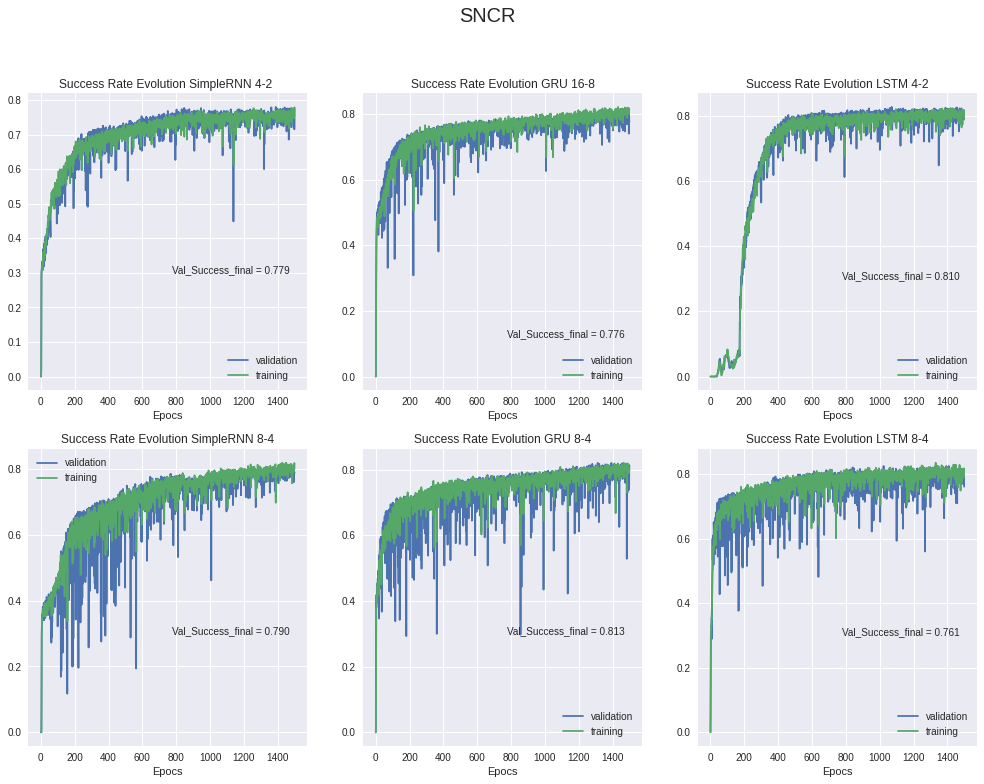

In [18]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 4-2
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 18-4
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
           textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 4-2
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [21]:
# Calculo la prediccion para mi conjunto test
predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))
print(rmseRNN84,rmseRNN168,rmseGRU168,rmseGRU1684,rmseLSTM84,rmseLSTM168)

1.7718357794414135 1.5730641857749454 1.498493692503663 1.5365982774896185 1.5171155319146303 1.9793083109144531


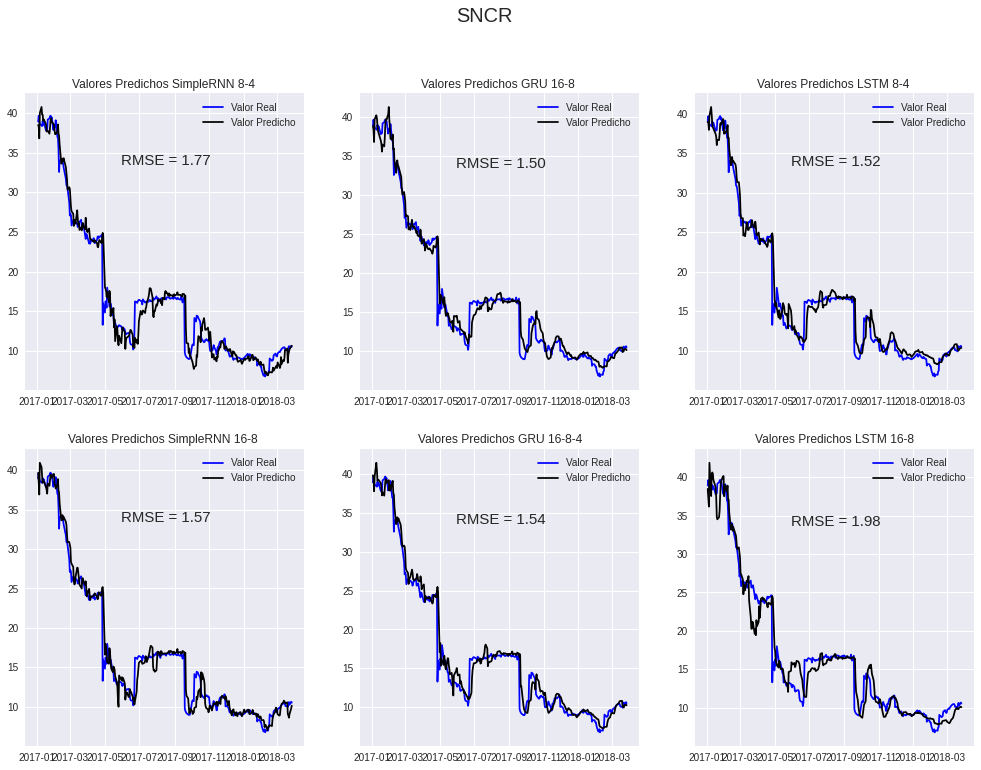

In [20]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [69]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedRNN84
# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({-1.0: 162, 1.0: 146})


In [60]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26     75765.4        0      0  10.65  10.3344   0
Valor Final = 75765.38
Ganancia con margen = -24234.62


In [44]:
print(movimientos_alza)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [61]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/SNRC/Alza3GRU-1684.csv")

In [62]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      323696        0         16056      0  10.65  10.3344   0
Valor Final = 152699.23
Ganancia con margen = 52699.23


In [50]:
print(movimientos_ab)

            presupuesto     acciones acciones_debo estado    valor     pred  \
2016-12-30           37         2610             0      0     38.3  42.7767   
2017-01-03       203252            0          2610     -1    38.93  42.6769   
2017-01-04       203252            0          2568      0    39.66  42.2528   
2017-01-05        36.24         2648             0      1    38.96  41.5931   
2017-01-06        36.24         2648             0      0    38.62  42.4012   
2017-01-09       203667            0          2648     -1    38.45  42.4629   
2017-01-10       203667            0          2587      0    38.36  42.2726   
2017-01-11       203667            0          2587      0       39  42.0309   
2017-01-12       203667            0          2587      0    38.52  41.9139   
2017-01-13       203667            0          2587      0    38.81  41.8959   
2017-01-17       203667            0          2587      0     37.8  41.7773   
2017-01-18       203667            0          2587  

In [63]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/SNRC/AlzaBaja3GRU-1684.csv")

In [70]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      185774        0             0      1  10.65  10.5659   1
Valor Final = 185773.74
Ganancia con margen = 85773.74


In [53]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2016-12-30      100000        0             0      0     38.3  43.1799  NaN
2017-01-03      199972        0          2568     -1    38.93   43.227   -1
2017-01-04      199972        0          2568      0    39.66  42.9557   -1
2017-01-05       99923        0             0      1    38.96  42.5517    1
2017-01-06      199833        0          2587     -1    38.62  43.4381   -1
2017-01-09      199833        0          2587      0    38.45  43.3545   -1
2017-01-10      199833        0          2587      0    38.36  43.0065   -1
2017-01-11      199833        0          2587      0       39  42.6662   -1
2017-01-12      199833        0          2587      0    38.52  42.4598   -1
2017-01-13      199833        0          2587      0    38.81  42.3253   -1
2017-01-17      199833        0          2587      0     37.8  42.1163   -1
2017-01-18      199833        0          2587      0    37.95  41.9717   -1
2017-01-19  

In [71]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/SNRC/Baja0RNN-84.csv")